In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook
import sys
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns       
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
from PIL import ImageOps

sns.set_style("darkgrid")

PATH = '/home/robot/Anand/'
sys.path.append(PATH)
print(sys.path)

from NeuralBlocks.models.mobilenet import MobileNetV2
from NeuralBlocks.models.densenet import DenseNet

['/home/robot/miniconda3/envs/main/lib/python36.zip', '/home/robot/miniconda3/envs/main/lib/python3.6', '/home/robot/miniconda3/envs/main/lib/python3.6/lib-dynload', '', '/home/robot/miniconda3/envs/main/lib/python3.6/site-packages', '/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/IPython/extensions', '/home/robot/.ipython', '/home/robot/Anand/']


In [2]:
torch.manual_seed(2456)
# cudnn.deterministic = True
cudnn.benchmark = True #False
np.random.seed(2456)

NUM_EPOCH = 200
BATCH_SIZE = 128
CHECKPOINT_INTERVAL = 100
LRS = [0.0001, 0.001, 0.003]
NORMS =[None,'BN', 'SN', 'WN','MWN', 'MSN', 'MSNTReLU', 'MWNTReLU']
DATA_PATH = PATH+"NeuralBlocks/data_utils/datasets/FashionMNIST/"
SAVE_PATH = PATH+"NeuralBlocks/experiments/FashionMNIST/"

os.makedirs(SAVE_PATH, exist_ok=True)

In [3]:
transform_train = transforms.Compose(
    [#transforms.RandomAffine(degrees=7, translate=(0.1, 0.1), scale=(0.95, 1.05)), 
     transforms.ToTensor(),
     transforms.Normalize((0.19036,), (0.34743,)),
    ])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.19036,), (0.34743,)),
    ])

trainset = torchvision.datasets.FashionMNIST(root=DATA_PATH,train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

testset = torchvision.datasets.FashionMNIST(root=DATA_PATH,train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [4]:
trainloader.dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        train_loss_log.append(train_loss/(batch_idx+1))
        train_acc_log.append( 100.*correct/total)
        
        if(batch_idx%CHECKPOINT_INTERVAL==0):
             print("Train Epoch [{:3d}/{:3d}]Batch [{:3d}/{:3d}] Loss: {:.3f} Acc {:.3f}%".format(epoch, NUM_EPOCH,batch_idx, len(trainloader),
                train_loss/(batch_idx+1), 100.*correct/total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            test_loss_log.append(test_loss/(batch_idx+1))
            test_acc_log.append( 100.*correct/total)
        
            if(batch_idx%CHECKPOINT_INTERVAL==0):
                print("Test Epoch [{:3d}/{:3d}]Batch [{:3d}/{:3d}] Loss: {:.3f} Acc {:.3f}%".format(epoch, NUM_EPOCH,batch_idx, len(testloader),
                test_loss/(batch_idx+1), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(SAVE_PATH+'checkpoint'):
            os.mkdir(SAVE_PATH+'checkpoint')
        torch.save(state, SAVE_PATH+'checkpoint/ckpt.pth')
        best_acc = acc

In [8]:
best_acc = 0 
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
for lr in tqdm_notebook(LRS):
    for norm in tqdm_notebook(NORMS):
        net =   MobileNetV2(1, num_class=10, norm=norm).cuda()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=lr)

        train_loss_log =[]
        train_acc_log = []
        test_loss_log =[]
        test_acc_log =[]

        for epoch in tqdm_notebook(range(NUM_EPOCH)):
            train(epoch)
            test(epoch)

        np.save(SAVE_PATH+"MobileNet_Train_loss_{}_{}.npy".format(norm,lr), train_loss_log)  
        np.save(SAVE_PATH+"MobileNet_Test_loss_{}_{}.npy".format(norm,lr), test_loss_log)    
        np.save(SAVE_PATH+"MobileNet_Train_Acc_{}_{}.npy".format(norm,lr), train_acc_log)    
        np.save(SAVE_PATH+"MobileNet_Test_Acc_{}_{}.npy".format(norm,lr), test_acc_log)   
        del net

Train Epoch [  0/200]Batch [  0/469] Loss: 2.316 Acc 3.125%
Train Epoch [  0/200]Batch [100/469] Loss: 1.971 Acc 48.128%
Train Epoch [  0/200]Batch [200/469] Loss: 1.689 Acc 58.182%
Train Epoch [  0/200]Batch [300/469] Loss: 1.483 Acc 62.749%
Train Epoch [  0/200]Batch [400/469] Loss: 1.334 Acc 65.555%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.747 Acc 75.781%
Saving..
Train Epoch [  1/200]Batch [  0/469] Loss: 0.793 Acc 79.688%
Train Epoch [  1/200]Batch [100/469] Loss: 0.748 Acc 75.456%
Train Epoch [  1/200]Batch [200/469] Loss: 0.725 Acc 75.789%
Train Epoch [  1/200]Batch [300/469] Loss: 0.707 Acc 75.999%
Train Epoch [  1/200]Batch [400/469] Loss: 0.690 Acc 76.335%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.595 Acc 76.562%
Saving..
Train Epoch [  2/200]Batch [  0/469] Loss: 0.614 Acc 78.125%
Train Epoch [  2/200]Batch [100/469] Loss: 0.601 Acc 78.241%
Train Epoch [  2/200]Batch [200/469] Loss: 0.587 Acc 78.681%
Train Epoch [  2/200]Batch [300/469] Loss: 0.580 Acc 78.836%
Train Epo

Train Epoch [ 22/200]Batch [100/469] Loss: 0.263 Acc 90.617%
Train Epoch [ 22/200]Batch [200/469] Loss: 0.261 Acc 90.699%
Train Epoch [ 22/200]Batch [300/469] Loss: 0.262 Acc 90.729%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.259 Acc 90.777%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.308 Acc 88.281%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.206 Acc 93.750%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.259 Acc 90.780%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.257 Acc 90.827%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.257 Acc 90.856%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.258 Acc 90.783%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.338 Acc 90.625%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.301 Acc 89.062%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.260 Acc 90.811%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.259 Acc 90.878%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.254 Acc 91.001%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.254 Acc 91.019%
Test Epoch [ 24/200]Batch 

Train Epoch [ 44/200]Batch [200/469] Loss: 0.213 Acc 92.502%
Train Epoch [ 44/200]Batch [300/469] Loss: 0.216 Acc 92.325%
Train Epoch [ 44/200]Batch [400/469] Loss: 0.219 Acc 92.184%
Test Epoch [ 44/200]Batch [  0/ 79] Loss: 0.247 Acc 90.625%
Train Epoch [ 45/200]Batch [  0/469] Loss: 0.169 Acc 94.531%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.217 Acc 92.528%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.218 Acc 92.281%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.218 Acc 92.247%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.218 Acc 92.258%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.234 Acc 92.969%
Saving..
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.261 Acc 89.062%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.217 Acc 92.048%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.220 Acc 92.051%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.216 Acc 92.273%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.216 Acc 92.320%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.253 Acc 91.406%
Train Epoch [ 47/2

Train Epoch [ 66/200]Batch [400/469] Loss: 0.197 Acc 92.977%
Test Epoch [ 66/200]Batch [  0/ 79] Loss: 0.214 Acc 92.188%
Train Epoch [ 67/200]Batch [  0/469] Loss: 0.121 Acc 96.875%
Train Epoch [ 67/200]Batch [100/469] Loss: 0.188 Acc 93.448%
Train Epoch [ 67/200]Batch [200/469] Loss: 0.191 Acc 93.299%
Train Epoch [ 67/200]Batch [300/469] Loss: 0.195 Acc 93.119%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.195 Acc 93.053%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.248 Acc 91.406%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.210 Acc 89.844%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.202 Acc 92.713%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.194 Acc 93.062%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.196 Acc 92.979%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.196 Acc 93.031%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.234 Acc 91.406%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.233 Acc 90.625%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.195 Acc 92.992%
Train Epoch [ 69/200]Batch 

Train Epoch [ 89/200]Batch [100/469] Loss: 0.180 Acc 93.580%
Train Epoch [ 89/200]Batch [200/469] Loss: 0.176 Acc 93.793%
Train Epoch [ 89/200]Batch [300/469] Loss: 0.178 Acc 93.670%
Train Epoch [ 89/200]Batch [400/469] Loss: 0.178 Acc 93.653%
Test Epoch [ 89/200]Batch [  0/ 79] Loss: 0.255 Acc 91.406%
Train Epoch [ 90/200]Batch [  0/469] Loss: 0.194 Acc 93.750%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.172 Acc 94.199%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.176 Acc 93.878%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.178 Acc 93.755%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.179 Acc 93.639%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.215 Acc 92.188%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.180 Acc 94.531%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.184 Acc 93.448%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.183 Acc 93.404%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.177 Acc 93.651%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.179 Acc 93.557%
Test Epoch [ 91/200]Batch 

Train Epoch [111/200]Batch [400/469] Loss: 0.167 Acc 94.085%
Test Epoch [111/200]Batch [  0/ 79] Loss: 0.214 Acc 92.188%
Train Epoch [112/200]Batch [  0/469] Loss: 0.166 Acc 90.625%
Train Epoch [112/200]Batch [100/469] Loss: 0.163 Acc 94.098%
Train Epoch [112/200]Batch [200/469] Loss: 0.165 Acc 94.073%
Train Epoch [112/200]Batch [300/469] Loss: 0.164 Acc 94.134%
Train Epoch [112/200]Batch [400/469] Loss: 0.165 Acc 94.140%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.249 Acc 91.406%
Train Epoch [113/200]Batch [  0/469] Loss: 0.104 Acc 98.438%
Train Epoch [113/200]Batch [100/469] Loss: 0.164 Acc 94.469%
Train Epoch [113/200]Batch [200/469] Loss: 0.162 Acc 94.329%
Train Epoch [113/200]Batch [300/469] Loss: 0.165 Acc 94.189%
Train Epoch [113/200]Batch [400/469] Loss: 0.165 Acc 94.190%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.220 Acc 92.188%
Train Epoch [114/200]Batch [  0/469] Loss: 0.243 Acc 93.750%
Train Epoch [114/200]Batch [100/469] Loss: 0.167 Acc 94.067%
Train Epoch [114/200]Batch 

Train Epoch [134/200]Batch [100/469] Loss: 0.157 Acc 94.423%
Train Epoch [134/200]Batch [200/469] Loss: 0.160 Acc 94.317%
Train Epoch [134/200]Batch [300/469] Loss: 0.158 Acc 94.396%
Train Epoch [134/200]Batch [400/469] Loss: 0.156 Acc 94.504%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.163 Acc 93.750%
Train Epoch [135/200]Batch [  0/469] Loss: 0.219 Acc 92.188%
Train Epoch [135/200]Batch [100/469] Loss: 0.152 Acc 94.469%
Train Epoch [135/200]Batch [200/469] Loss: 0.157 Acc 94.345%
Train Epoch [135/200]Batch [300/469] Loss: 0.156 Acc 94.357%
Train Epoch [135/200]Batch [400/469] Loss: 0.156 Acc 94.434%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.174 Acc 92.969%
Train Epoch [136/200]Batch [  0/469] Loss: 0.094 Acc 96.875%
Train Epoch [136/200]Batch [100/469] Loss: 0.151 Acc 94.640%
Train Epoch [136/200]Batch [200/469] Loss: 0.152 Acc 94.543%
Train Epoch [136/200]Batch [300/469] Loss: 0.154 Acc 94.505%
Train Epoch [136/200]Batch [400/469] Loss: 0.154 Acc 94.483%
Test Epoch [136/200]Batch 

Train Epoch [156/200]Batch [400/469] Loss: 0.147 Acc 94.794%
Test Epoch [156/200]Batch [  0/ 79] Loss: 0.219 Acc 92.188%
Train Epoch [157/200]Batch [  0/469] Loss: 0.150 Acc 96.094%
Train Epoch [157/200]Batch [100/469] Loss: 0.142 Acc 94.887%
Train Epoch [157/200]Batch [200/469] Loss: 0.140 Acc 95.044%
Train Epoch [157/200]Batch [300/469] Loss: 0.142 Acc 94.944%
Train Epoch [157/200]Batch [400/469] Loss: 0.143 Acc 94.917%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.182 Acc 93.750%
Train Epoch [158/200]Batch [  0/469] Loss: 0.232 Acc 91.406%
Train Epoch [158/200]Batch [100/469] Loss: 0.140 Acc 94.972%
Train Epoch [158/200]Batch [200/469] Loss: 0.143 Acc 94.955%
Train Epoch [158/200]Batch [300/469] Loss: 0.146 Acc 94.884%
Train Epoch [158/200]Batch [400/469] Loss: 0.144 Acc 94.878%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.186 Acc 92.969%
Train Epoch [159/200]Batch [  0/469] Loss: 0.148 Acc 94.531%
Train Epoch [159/200]Batch [100/469] Loss: 0.145 Acc 94.833%
Train Epoch [159/200]Batch 

Train Epoch [179/200]Batch [100/469] Loss: 0.135 Acc 95.135%
Train Epoch [179/200]Batch [200/469] Loss: 0.134 Acc 95.297%
Train Epoch [179/200]Batch [300/469] Loss: 0.134 Acc 95.315%
Train Epoch [179/200]Batch [400/469] Loss: 0.134 Acc 95.264%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.192 Acc 91.406%
Train Epoch [180/200]Batch [  0/469] Loss: 0.156 Acc 94.531%
Train Epoch [180/200]Batch [100/469] Loss: 0.131 Acc 95.429%
Train Epoch [180/200]Batch [200/469] Loss: 0.134 Acc 95.309%
Train Epoch [180/200]Batch [300/469] Loss: 0.132 Acc 95.349%
Train Epoch [180/200]Batch [400/469] Loss: 0.135 Acc 95.264%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.198 Acc 91.406%
Train Epoch [181/200]Batch [  0/469] Loss: 0.076 Acc 98.438%
Train Epoch [181/200]Batch [100/469] Loss: 0.135 Acc 95.119%
Train Epoch [181/200]Batch [200/469] Loss: 0.135 Acc 95.223%
Train Epoch [181/200]Batch [300/469] Loss: 0.135 Acc 95.193%
Train Epoch [181/200]Batch [400/469] Loss: 0.134 Acc 95.260%
Test Epoch [181/200]Batch 

Train Epoch [  0/200]Batch [  0/469] Loss: 2.307 Acc 3.125%
Train Epoch [  0/200]Batch [100/469] Loss: 1.989 Acc 50.449%
Train Epoch [  0/200]Batch [200/469] Loss: 1.662 Acc 60.642%
Train Epoch [  0/200]Batch [300/469] Loss: 1.423 Acc 65.090%
Train Epoch [  0/200]Batch [400/469] Loss: 1.263 Acc 67.682%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.661 Acc 76.562%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.654 Acc 76.562%
Train Epoch [  1/200]Batch [100/469] Loss: 0.645 Acc 77.468%
Train Epoch [  1/200]Batch [200/469] Loss: 0.624 Acc 78.176%
Train Epoch [  1/200]Batch [300/469] Loss: 0.600 Acc 79.127%
Train Epoch [  1/200]Batch [400/469] Loss: 0.582 Acc 79.662%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.484 Acc 82.812%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.487 Acc 85.938%
Train Epoch [  2/200]Batch [100/469] Loss: 0.488 Acc 83.045%
Train Epoch [  2/200]Batch [200/469] Loss: 0.466 Acc 83.901%
Train Epoch [  2/200]Batch [300/469] Loss: 0.456 Acc 84.209%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.208 Acc 92.717%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.209 Acc 92.638%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.264 Acc 90.625%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.244 Acc 91.406%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.203 Acc 92.822%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.201 Acc 92.953%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.205 Acc 92.746%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.206 Acc 92.745%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.260 Acc 89.062%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.137 Acc 96.094%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.198 Acc 92.837%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.199 Acc 92.875%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.201 Acc 92.836%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.201 Acc 92.844%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.273 Acc 87.500%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.231 Acc 92.969%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.199 Acc 92.188%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.150 Acc 94.779%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.155 Acc 94.481%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.156 Acc 94.544%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.157 Acc 94.496%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.252 Acc 89.844%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.212 Acc 92.969%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.151 Acc 94.531%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.152 Acc 94.683%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.153 Acc 94.617%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.156 Acc 94.537%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.254 Acc 89.844%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.126 Acc 94.531%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.159 Acc 94.438%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.156 Acc 94.605%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.154 Acc 94.669%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.126 Acc 95.624%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.126 Acc 95.620%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.251 Acc 90.625%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.134 Acc 93.750%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.126 Acc 95.568%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.126 Acc 95.674%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.125 Acc 95.793%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.125 Acc 95.788%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.242 Acc 89.844%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.068 Acc 98.438%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.117 Acc 96.248%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.125 Acc 95.787%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.125 Acc 95.767%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.123 Acc 95.774%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.262 Acc 89.844%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.139 Acc 95.312%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.073 Acc 97.656%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.097 Acc 96.805%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.099 Acc 96.774%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.101 Acc 96.670%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.100 Acc 96.688%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.231 Acc 90.625%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.084 Acc 97.656%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.095 Acc 96.728%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.098 Acc 96.665%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.097 Acc 96.769%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.098 Acc 96.772%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.258 Acc 90.625%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.073 Acc 99.219%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.097 Acc 96.744%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.099 Acc 96.622%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.099 Acc 96.641%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.079 Acc 97.607%
Train Epoch [112/200]Batch [400/469] Loss: 0.081 Acc 97.481%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.229 Acc 92.188%
Train Epoch [113/200]Batch [  0/469] Loss: 0.126 Acc 96.094%
Train Epoch [113/200]Batch [100/469] Loss: 0.075 Acc 97.455%
Train Epoch [113/200]Batch [200/469] Loss: 0.077 Acc 97.497%
Train Epoch [113/200]Batch [300/469] Loss: 0.077 Acc 97.545%
Train Epoch [113/200]Batch [400/469] Loss: 0.078 Acc 97.537%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.269 Acc 91.406%
Train Epoch [114/200]Batch [  0/469] Loss: 0.082 Acc 97.656%
Train Epoch [114/200]Batch [100/469] Loss: 0.079 Acc 97.625%
Train Epoch [114/200]Batch [200/469] Loss: 0.079 Acc 97.532%
Train Epoch [114/200]Batch [300/469] Loss: 0.079 Acc 97.485%
Train Epoch [114/200]Batch [400/469] Loss: 0.079 Acc 97.461%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.232 Acc 91.406%
Train Epoch [115/200]Batch [  0/469] Loss: 0.072 Acc 96.875%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.037 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.065 Acc 98.113%
Train Epoch [135/200]Batch [200/469] Loss: 0.063 Acc 98.150%
Train Epoch [135/200]Batch [300/469] Loss: 0.062 Acc 98.181%
Train Epoch [135/200]Batch [400/469] Loss: 0.064 Acc 98.058%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.329 Acc 89.062%
Train Epoch [136/200]Batch [  0/469] Loss: 0.053 Acc 98.438%
Train Epoch [136/200]Batch [100/469] Loss: 0.058 Acc 98.314%
Train Epoch [136/200]Batch [200/469] Loss: 0.058 Acc 98.266%
Train Epoch [136/200]Batch [300/469] Loss: 0.062 Acc 98.118%
Train Epoch [136/200]Batch [400/469] Loss: 0.064 Acc 98.061%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.266 Acc 91.406%
Train Epoch [137/200]Batch [  0/469] Loss: 0.050 Acc 97.656%
Train Epoch [137/200]Batch [100/469] Loss: 0.059 Acc 98.190%
Train Epoch [137/200]Batch [200/469] Loss: 0.060 Acc 98.162%
Train Epoch [137/200]Batch [300/469] Loss: 0.061 Acc 98.129%
Train Epoch [137/200]Batc

Train Epoch [157/200]Batch [300/469] Loss: 0.051 Acc 98.562%
Train Epoch [157/200]Batch [400/469] Loss: 0.052 Acc 98.535%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.291 Acc 92.188%
Train Epoch [158/200]Batch [  0/469] Loss: 0.050 Acc 98.438%
Train Epoch [158/200]Batch [100/469] Loss: 0.049 Acc 98.631%
Train Epoch [158/200]Batch [200/469] Loss: 0.049 Acc 98.601%
Train Epoch [158/200]Batch [300/469] Loss: 0.049 Acc 98.614%
Train Epoch [158/200]Batch [400/469] Loss: 0.051 Acc 98.510%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.305 Acc 90.625%
Train Epoch [159/200]Batch [  0/469] Loss: 0.094 Acc 96.875%
Train Epoch [159/200]Batch [100/469] Loss: 0.048 Acc 98.716%
Train Epoch [159/200]Batch [200/469] Loss: 0.048 Acc 98.725%
Train Epoch [159/200]Batch [300/469] Loss: 0.050 Acc 98.663%
Train Epoch [159/200]Batch [400/469] Loss: 0.050 Acc 98.623%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.319 Acc 90.625%
Train Epoch [160/200]Batch [  0/469] Loss: 0.044 Acc 96.875%
Train Epoch [160/200]Batch 

Train Epoch [180/200]Batch [  0/469] Loss: 0.056 Acc 98.438%
Train Epoch [180/200]Batch [100/469] Loss: 0.038 Acc 98.987%
Train Epoch [180/200]Batch [200/469] Loss: 0.040 Acc 98.916%
Train Epoch [180/200]Batch [300/469] Loss: 0.040 Acc 98.848%
Train Epoch [180/200]Batch [400/469] Loss: 0.041 Acc 98.827%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.307 Acc 91.406%
Train Epoch [181/200]Batch [  0/469] Loss: 0.044 Acc 98.438%
Train Epoch [181/200]Batch [100/469] Loss: 0.041 Acc 98.886%
Train Epoch [181/200]Batch [200/469] Loss: 0.040 Acc 98.974%
Train Epoch [181/200]Batch [300/469] Loss: 0.040 Acc 98.957%
Train Epoch [181/200]Batch [400/469] Loss: 0.040 Acc 98.923%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.364 Acc 91.406%
Train Epoch [182/200]Batch [  0/469] Loss: 0.033 Acc 98.438%
Train Epoch [182/200]Batch [100/469] Loss: 0.038 Acc 98.948%
Train Epoch [182/200]Batch [200/469] Loss: 0.039 Acc 98.923%
Train Epoch [182/200]Batch [300/469] Loss: 0.040 Acc 98.897%
Train Epoch [182/200]Batch

Train Epoch [  0/200]Batch [  0/469] Loss: 2.319 Acc 14.844%
Train Epoch [  0/200]Batch [100/469] Loss: 1.953 Acc 46.542%
Train Epoch [  0/200]Batch [200/469] Loss: 1.680 Acc 56.246%
Train Epoch [  0/200]Batch [300/469] Loss: 1.485 Acc 61.049%
Train Epoch [  0/200]Batch [400/469] Loss: 1.345 Acc 63.950%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.775 Acc 76.562%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.712 Acc 82.031%
Train Epoch [  1/200]Batch [100/469] Loss: 0.774 Acc 75.364%
Train Epoch [  1/200]Batch [200/469] Loss: 0.748 Acc 75.498%
Train Epoch [  1/200]Batch [300/469] Loss: 0.725 Acc 76.002%
Train Epoch [  1/200]Batch [400/469] Loss: 0.708 Acc 76.239%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.606 Acc 78.906%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.771 Acc 69.531%
Train Epoch [  2/200]Batch [100/469] Loss: 0.625 Acc 77.731%
Train Epoch [  2/200]Batch [200/469] Loss: 0.614 Acc 78.176%
Train Epoch [  2/200]Batch [300/469] Loss: 0.605 Acc 78.509%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.291 Acc 89.732%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.293 Acc 89.641%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.384 Acc 86.719%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.215 Acc 93.750%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.280 Acc 89.898%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.284 Acc 90.007%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.290 Acc 89.831%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.290 Acc 89.785%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.356 Acc 88.281%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.268 Acc 92.188%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.286 Acc 89.797%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.289 Acc 89.832%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.285 Acc 90.075%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.285 Acc 90.031%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.351 Acc 84.375%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.282 Acc 92.188%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.216 Acc 91.406%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.245 Acc 91.406%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.245 Acc 91.375%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.245 Acc 91.323%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.244 Acc 91.469%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.392 Acc 88.281%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.286 Acc 92.969%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.239 Acc 91.538%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.245 Acc 91.461%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.247 Acc 91.310%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.243 Acc 91.416%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.325 Acc 89.844%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.259 Acc 92.188%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.243 Acc 91.368%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.244 Acc 91.227%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.242 Acc 91.380%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.224 Acc 92.089%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.224 Acc 92.055%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.317 Acc 91.406%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.227 Acc 92.188%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.217 Acc 92.458%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.219 Acc 92.397%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.220 Acc 92.247%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.221 Acc 92.191%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.295 Acc 89.844%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.184 Acc 93.750%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.218 Acc 92.234%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.222 Acc 92.164%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.224 Acc 92.094%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.221 Acc 92.203%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.310 Acc 88.281%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.218 Acc 89.844%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.211 Acc 94.531%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.214 Acc 92.543%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.208 Acc 92.782%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.207 Acc 92.771%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.205 Acc 92.774%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.299 Acc 89.844%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.189 Acc 94.531%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.205 Acc 92.667%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.205 Acc 92.782%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.209 Acc 92.582%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.206 Acc 92.659%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.288 Acc 90.625%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.260 Acc 90.625%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.204 Acc 92.860%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.203 Acc 92.903%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.206 Acc 92.727%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.193 Acc 93.137%
Train Epoch [112/200]Batch [400/469] Loss: 0.196 Acc 93.056%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.270 Acc 90.625%
Train Epoch [113/200]Batch [  0/469] Loss: 0.177 Acc 95.312%
Train Epoch [113/200]Batch [100/469] Loss: 0.193 Acc 92.992%
Train Epoch [113/200]Batch [200/469] Loss: 0.196 Acc 92.910%
Train Epoch [113/200]Batch [300/469] Loss: 0.195 Acc 93.021%
Train Epoch [113/200]Batch [400/469] Loss: 0.194 Acc 93.017%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.286 Acc 91.406%
Train Epoch [114/200]Batch [  0/469] Loss: 0.247 Acc 91.406%
Train Epoch [114/200]Batch [100/469] Loss: 0.188 Acc 93.410%
Train Epoch [114/200]Batch [200/469] Loss: 0.195 Acc 93.179%
Train Epoch [114/200]Batch [300/469] Loss: 0.195 Acc 93.202%
Train Epoch [114/200]Batch [400/469] Loss: 0.194 Acc 93.208%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.270 Acc 89.844%
Train Epoch [115/200]Batch [  0/469] Loss: 0.164 Acc 94.531%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.147 Acc 96.094%
Train Epoch [135/200]Batch [100/469] Loss: 0.190 Acc 93.356%
Train Epoch [135/200]Batch [200/469] Loss: 0.187 Acc 93.431%
Train Epoch [135/200]Batch [300/469] Loss: 0.186 Acc 93.441%
Train Epoch [135/200]Batch [400/469] Loss: 0.185 Acc 93.460%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.254 Acc 91.406%
Train Epoch [136/200]Batch [  0/469] Loss: 0.133 Acc 95.312%
Train Epoch [136/200]Batch [100/469] Loss: 0.185 Acc 93.278%
Train Epoch [136/200]Batch [200/469] Loss: 0.184 Acc 93.420%
Train Epoch [136/200]Batch [300/469] Loss: 0.184 Acc 93.418%
Train Epoch [136/200]Batch [400/469] Loss: 0.185 Acc 93.393%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.269 Acc 92.969%
Train Epoch [137/200]Batch [  0/469] Loss: 0.177 Acc 94.531%
Train Epoch [137/200]Batch [100/469] Loss: 0.188 Acc 93.371%
Train Epoch [137/200]Batch [200/469] Loss: 0.185 Acc 93.455%
Train Epoch [137/200]Batch [300/469] Loss: 0.184 Acc 93.524%
Train Epoch [137/200]Batch

Train Epoch [157/200]Batch [300/469] Loss: 0.178 Acc 93.680%
Train Epoch [157/200]Batch [400/469] Loss: 0.178 Acc 93.668%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.240 Acc 91.406%
Train Epoch [158/200]Batch [  0/469] Loss: 0.178 Acc 92.188%
Train Epoch [158/200]Batch [100/469] Loss: 0.174 Acc 93.858%
Train Epoch [158/200]Batch [200/469] Loss: 0.179 Acc 93.801%
Train Epoch [158/200]Batch [300/469] Loss: 0.179 Acc 93.690%
Train Epoch [158/200]Batch [400/469] Loss: 0.180 Acc 93.618%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.287 Acc 90.625%
Train Epoch [159/200]Batch [  0/469] Loss: 0.234 Acc 89.844%
Train Epoch [159/200]Batch [100/469] Loss: 0.177 Acc 93.982%
Train Epoch [159/200]Batch [200/469] Loss: 0.179 Acc 93.766%
Train Epoch [159/200]Batch [300/469] Loss: 0.181 Acc 93.615%
Train Epoch [159/200]Batch [400/469] Loss: 0.181 Acc 93.660%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.227 Acc 93.750%
Train Epoch [160/200]Batch [  0/469] Loss: 0.150 Acc 94.531%
Train Epoch [160/200]Batch 

Train Epoch [180/200]Batch [  0/469] Loss: 0.134 Acc 95.312%
Train Epoch [180/200]Batch [100/469] Loss: 0.164 Acc 94.090%
Train Epoch [180/200]Batch [200/469] Loss: 0.173 Acc 93.801%
Train Epoch [180/200]Batch [300/469] Loss: 0.173 Acc 93.859%
Train Epoch [180/200]Batch [400/469] Loss: 0.172 Acc 93.886%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.227 Acc 93.750%
Train Epoch [181/200]Batch [  0/469] Loss: 0.153 Acc 93.750%
Train Epoch [181/200]Batch [100/469] Loss: 0.174 Acc 93.773%
Train Epoch [181/200]Batch [200/469] Loss: 0.171 Acc 93.999%
Train Epoch [181/200]Batch [300/469] Loss: 0.172 Acc 93.914%
Train Epoch [181/200]Batch [400/469] Loss: 0.172 Acc 93.918%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.229 Acc 92.969%
Train Epoch [182/200]Batch [  0/469] Loss: 0.128 Acc 96.094%
Train Epoch [182/200]Batch [100/469] Loss: 0.165 Acc 94.183%
Train Epoch [182/200]Batch [200/469] Loss: 0.167 Acc 94.154%
Train Epoch [182/200]Batch [300/469] Loss: 0.169 Acc 94.023%
Train Epoch [182/200]Batch

Train Epoch [  0/200]Batch [  0/469] Loss: 2.344 Acc 8.594%
Train Epoch [  0/200]Batch [100/469] Loss: 1.927 Acc 44.640%
Train Epoch [  0/200]Batch [200/469] Loss: 1.634 Acc 55.410%
Train Epoch [  0/200]Batch [300/469] Loss: 1.434 Acc 60.621%
Train Epoch [  0/200]Batch [400/469] Loss: 1.292 Acc 63.837%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.720 Acc 77.344%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.801 Acc 77.344%
Train Epoch [  1/200]Batch [100/469] Loss: 0.724 Acc 76.238%
Train Epoch [  1/200]Batch [200/469] Loss: 0.705 Acc 76.314%
Train Epoch [  1/200]Batch [300/469] Loss: 0.684 Acc 76.723%
Train Epoch [  1/200]Batch [400/469] Loss: 0.667 Acc 77.048%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.584 Acc 78.125%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.634 Acc 78.125%
Train Epoch [  2/200]Batch [100/469] Loss: 0.583 Acc 78.945%
Train Epoch [  2/200]Batch [200/469] Loss: 0.572 Acc 79.400%
Train Epoch [  2/200]Batch [300/469] Loss: 0.558 Acc 79.903%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.251 Acc 91.162%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.251 Acc 91.182%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.320 Acc 87.500%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.239 Acc 92.188%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.245 Acc 91.228%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.245 Acc 91.192%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.249 Acc 91.069%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.246 Acc 91.188%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.344 Acc 88.281%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.293 Acc 89.062%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.251 Acc 91.004%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.248 Acc 91.107%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.244 Acc 91.263%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.245 Acc 91.274%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.313 Acc 87.500%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.246 Acc 90.625%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.140 Acc 93.750%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.201 Acc 93.000%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.205 Acc 92.848%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.207 Acc 92.691%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.208 Acc 92.575%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.279 Acc 90.625%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.177 Acc 94.531%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.199 Acc 92.791%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.206 Acc 92.623%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.204 Acc 92.759%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.206 Acc 92.727%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.276 Acc 88.281%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.251 Acc 91.406%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.207 Acc 92.652%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.208 Acc 92.646%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.207 Acc 92.595%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.189 Acc 93.249%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.186 Acc 93.401%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.279 Acc 89.844%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.184 Acc 92.969%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.188 Acc 93.448%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.185 Acc 93.556%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.185 Acc 93.449%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.187 Acc 93.442%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.288 Acc 91.406%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.198 Acc 92.188%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.181 Acc 93.286%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.183 Acc 93.462%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.185 Acc 93.387%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.183 Acc 93.487%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.285 Acc 90.625%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.186 Acc 93.750%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.215 Acc 93.750%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.167 Acc 94.075%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.168 Acc 94.096%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.169 Acc 94.002%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.170 Acc 93.966%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.260 Acc 89.844%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.123 Acc 95.312%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.175 Acc 93.866%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.174 Acc 93.781%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.173 Acc 93.830%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.172 Acc 93.853%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.272 Acc 91.406%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.195 Acc 93.750%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.170 Acc 94.044%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.170 Acc 94.049%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.170 Acc 94.017%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.159 Acc 94.373%
Train Epoch [112/200]Batch [400/469] Loss: 0.159 Acc 94.371%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.251 Acc 90.625%
Train Epoch [113/200]Batch [  0/469] Loss: 0.166 Acc 91.406%
Train Epoch [113/200]Batch [100/469] Loss: 0.163 Acc 94.106%
Train Epoch [113/200]Batch [200/469] Loss: 0.161 Acc 94.310%
Train Epoch [113/200]Batch [300/469] Loss: 0.159 Acc 94.339%
Train Epoch [113/200]Batch [400/469] Loss: 0.159 Acc 94.356%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.252 Acc 91.406%
Train Epoch [114/200]Batch [  0/469] Loss: 0.195 Acc 92.969%
Train Epoch [114/200]Batch [100/469] Loss: 0.158 Acc 94.663%
Train Epoch [114/200]Batch [200/469] Loss: 0.158 Acc 94.578%
Train Epoch [114/200]Batch [300/469] Loss: 0.156 Acc 94.625%
Train Epoch [114/200]Batch [400/469] Loss: 0.156 Acc 94.586%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.242 Acc 91.406%
Train Epoch [115/200]Batch [  0/469] Loss: 0.195 Acc 93.750%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.160 Acc 94.531%
Train Epoch [135/200]Batch [100/469] Loss: 0.148 Acc 94.856%
Train Epoch [135/200]Batch [200/469] Loss: 0.148 Acc 94.799%
Train Epoch [135/200]Batch [300/469] Loss: 0.148 Acc 94.822%
Train Epoch [135/200]Batch [400/469] Loss: 0.147 Acc 94.880%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.272 Acc 92.188%
Saving..
Train Epoch [136/200]Batch [  0/469] Loss: 0.089 Acc 97.656%
Train Epoch [136/200]Batch [100/469] Loss: 0.140 Acc 95.135%
Train Epoch [136/200]Batch [200/469] Loss: 0.143 Acc 94.994%
Train Epoch [136/200]Batch [300/469] Loss: 0.144 Acc 94.952%
Train Epoch [136/200]Batch [400/469] Loss: 0.144 Acc 94.991%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.247 Acc 90.625%
Train Epoch [137/200]Batch [  0/469] Loss: 0.177 Acc 93.750%
Train Epoch [137/200]Batch [100/469] Loss: 0.150 Acc 94.779%
Train Epoch [137/200]Batch [200/469] Loss: 0.149 Acc 94.733%
Train Epoch [137/200]Batch [300/469] Loss: 0.148 Acc 94.778%
Train Epoch [137/

Train Epoch [157/200]Batch [300/469] Loss: 0.137 Acc 95.183%
Train Epoch [157/200]Batch [400/469] Loss: 0.138 Acc 95.141%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.232 Acc 92.188%
Train Epoch [158/200]Batch [  0/469] Loss: 0.118 Acc 96.094%
Train Epoch [158/200]Batch [100/469] Loss: 0.130 Acc 95.606%
Train Epoch [158/200]Batch [200/469] Loss: 0.133 Acc 95.371%
Train Epoch [158/200]Batch [300/469] Loss: 0.138 Acc 95.248%
Train Epoch [158/200]Batch [400/469] Loss: 0.139 Acc 95.219%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.267 Acc 91.406%
Train Epoch [159/200]Batch [  0/469] Loss: 0.126 Acc 94.531%
Train Epoch [159/200]Batch [100/469] Loss: 0.136 Acc 95.189%
Train Epoch [159/200]Batch [200/469] Loss: 0.135 Acc 95.250%
Train Epoch [159/200]Batch [300/469] Loss: 0.137 Acc 95.188%
Train Epoch [159/200]Batch [400/469] Loss: 0.137 Acc 95.178%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.225 Acc 91.406%
Train Epoch [160/200]Batch [  0/469] Loss: 0.262 Acc 89.062%
Train Epoch [160/200]Batch 

Train Epoch [180/200]Batch [  0/469] Loss: 0.143 Acc 95.312%
Train Epoch [180/200]Batch [100/469] Loss: 0.135 Acc 95.305%
Train Epoch [180/200]Batch [200/469] Loss: 0.131 Acc 95.515%
Train Epoch [180/200]Batch [300/469] Loss: 0.130 Acc 95.559%
Train Epoch [180/200]Batch [400/469] Loss: 0.131 Acc 95.505%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.239 Acc 92.188%
Train Epoch [181/200]Batch [  0/469] Loss: 0.074 Acc 98.438%
Train Epoch [181/200]Batch [100/469] Loss: 0.126 Acc 95.730%
Train Epoch [181/200]Batch [200/469] Loss: 0.127 Acc 95.635%
Train Epoch [181/200]Batch [300/469] Loss: 0.129 Acc 95.541%
Train Epoch [181/200]Batch [400/469] Loss: 0.129 Acc 95.566%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.225 Acc 91.406%
Train Epoch [182/200]Batch [  0/469] Loss: 0.173 Acc 94.531%
Train Epoch [182/200]Batch [100/469] Loss: 0.131 Acc 95.413%
Train Epoch [182/200]Batch [200/469] Loss: 0.133 Acc 95.429%
Train Epoch [182/200]Batch [300/469] Loss: 0.131 Acc 95.481%
Train Epoch [182/200]Batch

Train Epoch [  0/200]Batch [  0/469] Loss: 2.274 Acc 3.906%
Train Epoch [  0/200]Batch [100/469] Loss: 1.903 Acc 50.085%
Train Epoch [  0/200]Batch [200/469] Loss: 1.625 Acc 58.512%
Train Epoch [  0/200]Batch [300/469] Loss: 1.429 Acc 62.814%
Train Epoch [  0/200]Batch [400/469] Loss: 1.293 Acc 65.508%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.740 Acc 78.125%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.802 Acc 73.438%
Train Epoch [  1/200]Batch [100/469] Loss: 0.743 Acc 75.866%
Train Epoch [  1/200]Batch [200/469] Loss: 0.712 Acc 76.337%
Train Epoch [  1/200]Batch [300/469] Loss: 0.690 Acc 76.700%
Train Epoch [  1/200]Batch [400/469] Loss: 0.671 Acc 77.153%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.584 Acc 76.562%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.560 Acc 78.906%
Train Epoch [  2/200]Batch [100/469] Loss: 0.590 Acc 78.991%
Train Epoch [  2/200]Batch [200/469] Loss: 0.572 Acc 79.917%
Train Epoch [  2/200]Batch [300/469] Loss: 0.562 Acc 80.111%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.246 Acc 91.437%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.245 Acc 91.418%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.287 Acc 89.844%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.244 Acc 92.188%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.240 Acc 91.507%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.243 Acc 91.352%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.240 Acc 91.448%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.242 Acc 91.385%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.293 Acc 88.281%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.262 Acc 88.281%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.248 Acc 91.422%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.243 Acc 91.577%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.241 Acc 91.604%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.242 Acc 91.472%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.304 Acc 87.500%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.240 Acc 90.625%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.203 Acc 92.969%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.207 Acc 92.567%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.208 Acc 92.471%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.207 Acc 92.600%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.206 Acc 92.651%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.242 Acc 90.625%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.174 Acc 95.312%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.201 Acc 92.837%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.205 Acc 92.720%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.203 Acc 92.709%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.202 Acc 92.821%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.216 Acc 92.969%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.187 Acc 93.750%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.199 Acc 92.915%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.198 Acc 92.891%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.202 Acc 92.829%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.180 Acc 93.586%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.180 Acc 93.590%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.213 Acc 92.188%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.205 Acc 91.406%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.171 Acc 94.005%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.175 Acc 93.808%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.180 Acc 93.602%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.180 Acc 93.559%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.209 Acc 91.406%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.173 Acc 95.312%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.179 Acc 93.688%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.180 Acc 93.696%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.178 Acc 93.685%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.179 Acc 93.668%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.223 Acc 89.844%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.228 Acc 90.625%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.178 Acc 93.750%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.165 Acc 94.369%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.164 Acc 94.290%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.166 Acc 94.189%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.165 Acc 94.177%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.175 Acc 93.750%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.108 Acc 96.094%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.155 Acc 94.593%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.161 Acc 94.333%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.165 Acc 94.222%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.163 Acc 94.243%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.208 Acc 91.406%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.172 Acc 93.750%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.161 Acc 94.206%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.162 Acc 94.197%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.162 Acc 94.176%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.151 Acc 94.705%
Train Epoch [112/200]Batch [400/469] Loss: 0.150 Acc 94.722%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.213 Acc 92.969%
Train Epoch [113/200]Batch [  0/469] Loss: 0.097 Acc 96.094%
Train Epoch [113/200]Batch [100/469] Loss: 0.152 Acc 94.655%
Train Epoch [113/200]Batch [200/469] Loss: 0.151 Acc 94.593%
Train Epoch [113/200]Batch [300/469] Loss: 0.152 Acc 94.625%
Train Epoch [113/200]Batch [400/469] Loss: 0.151 Acc 94.635%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.208 Acc 89.844%
Train Epoch [114/200]Batch [  0/469] Loss: 0.214 Acc 92.188%
Train Epoch [114/200]Batch [100/469] Loss: 0.142 Acc 95.003%
Train Epoch [114/200]Batch [200/469] Loss: 0.149 Acc 94.675%
Train Epoch [114/200]Batch [300/469] Loss: 0.150 Acc 94.651%
Train Epoch [114/200]Batch [400/469] Loss: 0.150 Acc 94.693%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.216 Acc 91.406%
Train Epoch [115/200]Batch [  0/469] Loss: 0.100 Acc 96.875%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.075 Acc 98.438%
Train Epoch [135/200]Batch [100/469] Loss: 0.145 Acc 94.787%
Train Epoch [135/200]Batch [200/469] Loss: 0.142 Acc 94.955%
Train Epoch [135/200]Batch [300/469] Loss: 0.140 Acc 95.061%
Train Epoch [135/200]Batch [400/469] Loss: 0.139 Acc 95.104%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.197 Acc 92.188%
Train Epoch [136/200]Batch [  0/469] Loss: 0.131 Acc 96.094%
Train Epoch [136/200]Batch [100/469] Loss: 0.138 Acc 95.142%
Train Epoch [136/200]Batch [200/469] Loss: 0.139 Acc 95.192%
Train Epoch [136/200]Batch [300/469] Loss: 0.140 Acc 95.089%
Train Epoch [136/200]Batch [400/469] Loss: 0.139 Acc 95.079%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.179 Acc 92.969%
Train Epoch [137/200]Batch [  0/469] Loss: 0.045 Acc 99.219%
Train Epoch [137/200]Batch [100/469] Loss: 0.133 Acc 95.289%
Train Epoch [137/200]Batch [200/469] Loss: 0.135 Acc 95.126%
Train Epoch [137/200]Batch [300/469] Loss: 0.135 Acc 95.165%
Train Epoch [137/200]Batch

Train Epoch [157/200]Batch [300/469] Loss: 0.128 Acc 95.562%
Train Epoch [157/200]Batch [400/469] Loss: 0.127 Acc 95.531%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.168 Acc 92.969%
Train Epoch [158/200]Batch [  0/469] Loss: 0.094 Acc 98.438%
Train Epoch [158/200]Batch [100/469] Loss: 0.125 Acc 95.599%
Train Epoch [158/200]Batch [200/469] Loss: 0.126 Acc 95.600%
Train Epoch [158/200]Batch [300/469] Loss: 0.128 Acc 95.559%
Train Epoch [158/200]Batch [400/469] Loss: 0.127 Acc 95.552%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.224 Acc 92.188%
Train Epoch [159/200]Batch [  0/469] Loss: 0.141 Acc 96.875%
Train Epoch [159/200]Batch [100/469] Loss: 0.125 Acc 95.800%
Train Epoch [159/200]Batch [200/469] Loss: 0.126 Acc 95.725%
Train Epoch [159/200]Batch [300/469] Loss: 0.125 Acc 95.699%
Train Epoch [159/200]Batch [400/469] Loss: 0.128 Acc 95.556%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.194 Acc 92.188%
Train Epoch [160/200]Batch [  0/469] Loss: 0.113 Acc 94.531%
Train Epoch [160/200]Batch 

Train Epoch [180/200]Batch [  0/469] Loss: 0.135 Acc 94.531%
Train Epoch [180/200]Batch [100/469] Loss: 0.118 Acc 95.815%
Train Epoch [180/200]Batch [200/469] Loss: 0.117 Acc 95.923%
Train Epoch [180/200]Batch [300/469] Loss: 0.116 Acc 96.016%
Train Epoch [180/200]Batch [400/469] Loss: 0.117 Acc 95.950%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.182 Acc 94.531%
Train Epoch [181/200]Batch [  0/469] Loss: 0.058 Acc 99.219%
Train Epoch [181/200]Batch [100/469] Loss: 0.121 Acc 95.699%
Train Epoch [181/200]Batch [200/469] Loss: 0.118 Acc 95.853%
Train Epoch [181/200]Batch [300/469] Loss: 0.117 Acc 95.935%
Train Epoch [181/200]Batch [400/469] Loss: 0.117 Acc 95.930%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.195 Acc 90.625%
Train Epoch [182/200]Batch [  0/469] Loss: 0.114 Acc 95.312%
Train Epoch [182/200]Batch [100/469] Loss: 0.113 Acc 96.148%
Train Epoch [182/200]Batch [200/469] Loss: 0.117 Acc 96.020%
Train Epoch [182/200]Batch [300/469] Loss: 0.115 Acc 96.013%
Train Epoch [182/200]Batch

Train Epoch [  0/200]Batch [  0/469] Loss: 2.270 Acc 14.062%
Train Epoch [  0/200]Batch [100/469] Loss: 1.915 Acc 49.110%
Train Epoch [  0/200]Batch [200/469] Loss: 1.637 Acc 58.271%
Train Epoch [  0/200]Batch [300/469] Loss: 1.447 Acc 62.469%
Train Epoch [  0/200]Batch [400/469] Loss: 1.312 Acc 65.050%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.766 Acc 75.781%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.734 Acc 75.781%
Train Epoch [  1/200]Batch [100/469] Loss: 0.747 Acc 75.944%
Train Epoch [  1/200]Batch [200/469] Loss: 0.728 Acc 75.715%
Train Epoch [  1/200]Batch [300/469] Loss: 0.708 Acc 75.966%
Train Epoch [  1/200]Batch [400/469] Loss: 0.693 Acc 76.165%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.615 Acc 76.562%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.501 Acc 82.031%
Train Epoch [  2/200]Batch [100/469] Loss: 0.605 Acc 78.311%
Train Epoch [  2/200]Batch [200/469] Loss: 0.601 Acc 78.183%
Train Epoch [  2/200]Batch [300/469] Loss: 0.591 Acc 78.532%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.282 Acc 89.958%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.282 Acc 89.961%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.362 Acc 85.156%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.264 Acc 89.062%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.280 Acc 90.068%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.276 Acc 90.260%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.281 Acc 90.098%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.279 Acc 90.200%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.344 Acc 85.938%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.393 Acc 84.375%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.288 Acc 89.844%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.281 Acc 89.918%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.280 Acc 89.976%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.277 Acc 90.138%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.326 Acc 85.938%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.305 Acc 89.844%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.216 Acc 93.750%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.241 Acc 91.507%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.240 Acc 91.597%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.241 Acc 91.583%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.238 Acc 91.630%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.280 Acc 89.062%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.129 Acc 96.875%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.229 Acc 91.762%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.230 Acc 91.787%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.233 Acc 91.668%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.234 Acc 91.656%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.264 Acc 92.188%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.146 Acc 94.531%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.234 Acc 91.932%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.231 Acc 91.935%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.231 Acc 91.876%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.212 Acc 92.540%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.213 Acc 92.488%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.282 Acc 90.625%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.216 Acc 93.750%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.206 Acc 92.683%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.211 Acc 92.526%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.214 Acc 92.473%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.214 Acc 92.480%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.273 Acc 88.281%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.222 Acc 90.625%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.210 Acc 92.458%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.213 Acc 92.409%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.211 Acc 92.522%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.212 Acc 92.521%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.256 Acc 90.625%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.140 Acc 94.531%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.194 Acc 93.750%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.194 Acc 92.907%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.197 Acc 92.848%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.199 Acc 92.868%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.198 Acc 92.977%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.248 Acc 92.969%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.206 Acc 91.406%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.188 Acc 93.178%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.190 Acc 93.272%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.195 Acc 93.070%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.195 Acc 93.084%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.265 Acc 90.625%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.290 Acc 89.062%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.195 Acc 93.178%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.195 Acc 93.148%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.195 Acc 93.179%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.188 Acc 93.394%
Train Epoch [112/200]Batch [400/469] Loss: 0.186 Acc 93.425%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.219 Acc 90.625%
Train Epoch [113/200]Batch [  0/469] Loss: 0.201 Acc 92.969%
Train Epoch [113/200]Batch [100/469] Loss: 0.183 Acc 93.472%
Train Epoch [113/200]Batch [200/469] Loss: 0.188 Acc 93.470%
Train Epoch [113/200]Batch [300/469] Loss: 0.186 Acc 93.449%
Train Epoch [113/200]Batch [400/469] Loss: 0.189 Acc 93.290%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.218 Acc 91.406%
Train Epoch [114/200]Batch [  0/469] Loss: 0.170 Acc 92.969%
Train Epoch [114/200]Batch [100/469] Loss: 0.183 Acc 93.464%
Train Epoch [114/200]Batch [200/469] Loss: 0.183 Acc 93.369%
Train Epoch [114/200]Batch [300/469] Loss: 0.184 Acc 93.304%
Train Epoch [114/200]Batch [400/469] Loss: 0.185 Acc 93.351%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.239 Acc 91.406%
Train Epoch [115/200]Batch [  0/469] Loss: 0.144 Acc 94.531%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.171 Acc 92.969%
Train Epoch [135/200]Batch [100/469] Loss: 0.173 Acc 93.704%
Train Epoch [135/200]Batch [200/469] Loss: 0.176 Acc 93.801%
Train Epoch [135/200]Batch [300/469] Loss: 0.176 Acc 93.786%
Train Epoch [135/200]Batch [400/469] Loss: 0.177 Acc 93.760%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.237 Acc 91.406%
Train Epoch [136/200]Batch [  0/469] Loss: 0.138 Acc 96.094%
Train Epoch [136/200]Batch [100/469] Loss: 0.171 Acc 93.959%
Train Epoch [136/200]Batch [200/469] Loss: 0.174 Acc 93.820%
Train Epoch [136/200]Batch [300/469] Loss: 0.175 Acc 93.797%
Train Epoch [136/200]Batch [400/469] Loss: 0.175 Acc 93.793%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.229 Acc 90.625%
Train Epoch [137/200]Batch [  0/469] Loss: 0.122 Acc 96.094%
Train Epoch [137/200]Batch [100/469] Loss: 0.178 Acc 93.804%
Train Epoch [137/200]Batch [200/469] Loss: 0.177 Acc 93.797%
Train Epoch [137/200]Batch [300/469] Loss: 0.176 Acc 93.763%
Train Epoch [137/200]Batch

Train Epoch [157/200]Batch [300/469] Loss: 0.168 Acc 94.098%
Train Epoch [157/200]Batch [400/469] Loss: 0.168 Acc 94.021%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.208 Acc 93.750%
Train Epoch [158/200]Batch [  0/469] Loss: 0.125 Acc 94.531%
Train Epoch [158/200]Batch [100/469] Loss: 0.169 Acc 94.005%
Train Epoch [158/200]Batch [200/469] Loss: 0.169 Acc 94.069%
Train Epoch [158/200]Batch [300/469] Loss: 0.169 Acc 94.051%
Train Epoch [158/200]Batch [400/469] Loss: 0.170 Acc 94.009%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.230 Acc 92.188%
Train Epoch [159/200]Batch [  0/469] Loss: 0.133 Acc 96.875%
Train Epoch [159/200]Batch [100/469] Loss: 0.168 Acc 93.851%
Train Epoch [159/200]Batch [200/469] Loss: 0.169 Acc 93.952%
Train Epoch [159/200]Batch [300/469] Loss: 0.169 Acc 93.952%
Train Epoch [159/200]Batch [400/469] Loss: 0.168 Acc 94.019%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.220 Acc 92.969%
Train Epoch [160/200]Batch [  0/469] Loss: 0.236 Acc 90.625%
Train Epoch [160/200]Batch 

Train Epoch [180/200]Batch [  0/469] Loss: 0.233 Acc 92.969%
Train Epoch [180/200]Batch [100/469] Loss: 0.153 Acc 94.779%
Train Epoch [180/200]Batch [200/469] Loss: 0.157 Acc 94.555%
Train Epoch [180/200]Batch [300/469] Loss: 0.160 Acc 94.373%
Train Epoch [180/200]Batch [400/469] Loss: 0.163 Acc 94.301%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.231 Acc 90.625%
Train Epoch [181/200]Batch [  0/469] Loss: 0.138 Acc 95.312%
Train Epoch [181/200]Batch [100/469] Loss: 0.157 Acc 94.624%
Train Epoch [181/200]Batch [200/469] Loss: 0.156 Acc 94.628%
Train Epoch [181/200]Batch [300/469] Loss: 0.160 Acc 94.453%
Train Epoch [181/200]Batch [400/469] Loss: 0.160 Acc 94.428%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.191 Acc 94.531%
Train Epoch [182/200]Batch [  0/469] Loss: 0.126 Acc 96.094%
Train Epoch [182/200]Batch [100/469] Loss: 0.164 Acc 94.353%
Train Epoch [182/200]Batch [200/469] Loss: 0.161 Acc 94.341%
Train Epoch [182/200]Batch [300/469] Loss: 0.161 Acc 94.311%
Train Epoch [182/200]Batch

Train Epoch [  0/200]Batch [  0/469] Loss: 2.356 Acc 16.406%
Train Epoch [  0/200]Batch [100/469] Loss: 1.956 Acc 49.482%
Train Epoch [  0/200]Batch [200/469] Loss: 1.664 Acc 59.103%
Train Epoch [  0/200]Batch [300/469] Loss: 1.462 Acc 63.162%
Train Epoch [  0/200]Batch [400/469] Loss: 1.321 Acc 65.660%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.751 Acc 75.000%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.781 Acc 76.562%
Train Epoch [  1/200]Batch [100/469] Loss: 0.745 Acc 75.657%
Train Epoch [  1/200]Batch [200/469] Loss: 0.723 Acc 75.847%
Train Epoch [  1/200]Batch [300/469] Loss: 0.702 Acc 76.176%
Train Epoch [  1/200]Batch [400/469] Loss: 0.685 Acc 76.473%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.602 Acc 76.562%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.683 Acc 77.344%
Train Epoch [  2/200]Batch [100/469] Loss: 0.597 Acc 78.396%
Train Epoch [  2/200]Batch [200/469] Loss: 0.591 Acc 78.696%
Train Epoch [  2/200]Batch [300/469] Loss: 0.586 Acc 79.000%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.284 Acc 89.971%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.282 Acc 89.933%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.318 Acc 87.500%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.328 Acc 86.719%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.273 Acc 90.424%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.271 Acc 90.493%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.275 Acc 90.288%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.279 Acc 90.117%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.322 Acc 87.500%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.271 Acc 89.062%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.281 Acc 89.975%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.277 Acc 90.034%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.277 Acc 90.168%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.277 Acc 90.161%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.311 Acc 87.500%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.382 Acc 86.719%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.230 Acc 91.406%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.229 Acc 91.878%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.232 Acc 91.768%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.236 Acc 91.632%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.237 Acc 91.599%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.250 Acc 90.625%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.308 Acc 88.281%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.234 Acc 91.832%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.235 Acc 91.686%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.236 Acc 91.702%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.234 Acc 91.753%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.252 Acc 86.719%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.195 Acc 93.750%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.235 Acc 91.530%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.233 Acc 91.733%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.232 Acc 91.713%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.217 Acc 92.284%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.217 Acc 92.285%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.236 Acc 89.062%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.220 Acc 92.969%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.216 Acc 92.203%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.215 Acc 92.428%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.216 Acc 92.343%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.216 Acc 92.281%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.231 Acc 91.406%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.244 Acc 92.969%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.210 Acc 92.528%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.214 Acc 92.401%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.215 Acc 92.424%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.214 Acc 92.412%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.217 Acc 92.188%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.100 Acc 97.656%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.183 Acc 92.969%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.198 Acc 92.814%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.202 Acc 92.697%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.200 Acc 92.883%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.201 Acc 92.819%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.210 Acc 92.188%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.178 Acc 92.188%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.199 Acc 93.116%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.202 Acc 92.856%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.200 Acc 92.899%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.199 Acc 92.943%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.204 Acc 92.188%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.249 Acc 90.625%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.196 Acc 92.907%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.198 Acc 92.969%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.199 Acc 92.886%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.192 Acc 93.200%
Train Epoch [112/200]Batch [400/469] Loss: 0.189 Acc 93.302%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.204 Acc 92.969%
Train Epoch [113/200]Batch [  0/469] Loss: 0.146 Acc 94.531%
Train Epoch [113/200]Batch [100/469] Loss: 0.189 Acc 93.464%
Train Epoch [113/200]Batch [200/469] Loss: 0.187 Acc 93.427%
Train Epoch [113/200]Batch [300/469] Loss: 0.186 Acc 93.426%
Train Epoch [113/200]Batch [400/469] Loss: 0.188 Acc 93.368%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.195 Acc 92.969%
Train Epoch [114/200]Batch [  0/469] Loss: 0.146 Acc 94.531%
Train Epoch [114/200]Batch [100/469] Loss: 0.186 Acc 93.379%
Train Epoch [114/200]Batch [200/469] Loss: 0.188 Acc 93.439%
Train Epoch [114/200]Batch [300/469] Loss: 0.186 Acc 93.457%
Train Epoch [114/200]Batch [400/469] Loss: 0.189 Acc 93.341%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.202 Acc 92.188%
Train Epoch [115/200]Batch [  0/469] Loss: 0.158 Acc 95.312%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.068 Acc 98.438%
Train Epoch [135/200]Batch [100/469] Loss: 0.177 Acc 93.742%
Train Epoch [135/200]Batch [200/469] Loss: 0.177 Acc 93.734%
Train Epoch [135/200]Batch [300/469] Loss: 0.179 Acc 93.555%
Train Epoch [135/200]Batch [400/469] Loss: 0.180 Acc 93.499%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.187 Acc 90.625%
Train Epoch [136/200]Batch [  0/469] Loss: 0.238 Acc 90.625%
Train Epoch [136/200]Batch [100/469] Loss: 0.178 Acc 93.518%
Train Epoch [136/200]Batch [200/469] Loss: 0.179 Acc 93.497%
Train Epoch [136/200]Batch [300/469] Loss: 0.178 Acc 93.615%
Train Epoch [136/200]Batch [400/469] Loss: 0.178 Acc 93.666%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.182 Acc 92.188%
Train Epoch [137/200]Batch [  0/469] Loss: 0.139 Acc 96.094%
Train Epoch [137/200]Batch [100/469] Loss: 0.174 Acc 93.874%
Train Epoch [137/200]Batch [200/469] Loss: 0.178 Acc 93.618%
Train Epoch [137/200]Batch [300/469] Loss: 0.179 Acc 93.693%
Train Epoch [137/200]Batch

Train Epoch [157/200]Batch [300/469] Loss: 0.168 Acc 93.989%
Train Epoch [157/200]Batch [400/469] Loss: 0.170 Acc 93.882%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.201 Acc 92.188%
Train Epoch [158/200]Batch [  0/469] Loss: 0.170 Acc 91.406%
Train Epoch [158/200]Batch [100/469] Loss: 0.170 Acc 93.673%
Train Epoch [158/200]Batch [200/469] Loss: 0.168 Acc 93.801%
Train Epoch [158/200]Batch [300/469] Loss: 0.171 Acc 93.789%
Train Epoch [158/200]Batch [400/469] Loss: 0.171 Acc 93.881%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.178 Acc 92.969%
Train Epoch [159/200]Batch [  0/469] Loss: 0.161 Acc 93.750%
Train Epoch [159/200]Batch [100/469] Loss: 0.170 Acc 93.765%
Train Epoch [159/200]Batch [200/469] Loss: 0.169 Acc 93.956%
Train Epoch [159/200]Batch [300/469] Loss: 0.169 Acc 94.030%
Train Epoch [159/200]Batch [400/469] Loss: 0.170 Acc 93.972%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.195 Acc 91.406%
Train Epoch [160/200]Batch [  0/469] Loss: 0.254 Acc 90.625%
Train Epoch [160/200]Batch 

Train Epoch [180/200]Batch [  0/469] Loss: 0.094 Acc 98.438%
Train Epoch [180/200]Batch [100/469] Loss: 0.169 Acc 93.943%
Train Epoch [180/200]Batch [200/469] Loss: 0.169 Acc 94.038%
Train Epoch [180/200]Batch [300/469] Loss: 0.166 Acc 94.178%
Train Epoch [180/200]Batch [400/469] Loss: 0.165 Acc 94.157%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.199 Acc 92.969%
Train Epoch [181/200]Batch [  0/469] Loss: 0.255 Acc 89.844%
Train Epoch [181/200]Batch [100/469] Loss: 0.166 Acc 94.137%
Train Epoch [181/200]Batch [200/469] Loss: 0.164 Acc 94.170%
Train Epoch [181/200]Batch [300/469] Loss: 0.164 Acc 94.215%
Train Epoch [181/200]Batch [400/469] Loss: 0.163 Acc 94.262%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.190 Acc 92.969%
Train Epoch [182/200]Batch [  0/469] Loss: 0.219 Acc 89.844%
Train Epoch [182/200]Batch [100/469] Loss: 0.156 Acc 94.446%
Train Epoch [182/200]Batch [200/469] Loss: 0.159 Acc 94.275%
Train Epoch [182/200]Batch [300/469] Loss: 0.165 Acc 94.121%
Train Epoch [182/200]Batch

Train Epoch [  0/200]Batch [  0/469] Loss: 2.345 Acc 5.469%
Train Epoch [  0/200]Batch [100/469] Loss: 1.991 Acc 46.024%
Train Epoch [  0/200]Batch [200/469] Loss: 1.697 Acc 57.303%
Train Epoch [  0/200]Batch [300/469] Loss: 1.478 Acc 62.477%
Train Epoch [  0/200]Batch [400/469] Loss: 1.323 Acc 65.475%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.731 Acc 75.781%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.812 Acc 70.312%
Train Epoch [  1/200]Batch [100/469] Loss: 0.716 Acc 76.207%
Train Epoch [  1/200]Batch [200/469] Loss: 0.696 Acc 76.520%
Train Epoch [  1/200]Batch [300/469] Loss: 0.674 Acc 76.975%
Train Epoch [  1/200]Batch [400/469] Loss: 0.658 Acc 77.416%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.570 Acc 77.344%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.540 Acc 80.469%
Train Epoch [  2/200]Batch [100/469] Loss: 0.563 Acc 80.353%
Train Epoch [  2/200]Batch [200/469] Loss: 0.556 Acc 80.601%
Train Epoch [  2/200]Batch [300/469] Loss: 0.550 Acc 80.817%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.245 Acc 91.305%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.244 Acc 91.317%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.292 Acc 90.625%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.180 Acc 94.531%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.239 Acc 91.847%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.238 Acc 91.733%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.239 Acc 91.663%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.241 Acc 91.587%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.273 Acc 89.844%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.276 Acc 89.844%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.241 Acc 91.561%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.243 Acc 91.410%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.239 Acc 91.515%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.240 Acc 91.531%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.280 Acc 91.406%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.163 Acc 95.312%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.140 Acc 95.312%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.196 Acc 92.984%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.197 Acc 92.973%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.198 Acc 92.904%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.199 Acc 92.938%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.231 Acc 90.625%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.123 Acc 96.094%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.193 Acc 93.193%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.198 Acc 92.973%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.198 Acc 93.005%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.197 Acc 93.025%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.230 Acc 90.625%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.202 Acc 93.750%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.202 Acc 92.806%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.198 Acc 93.105%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.198 Acc 93.096%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.177 Acc 93.750%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.177 Acc 93.775%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.176 Acc 92.969%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.096 Acc 96.094%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.171 Acc 94.098%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.180 Acc 93.851%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.176 Acc 93.901%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.174 Acc 93.949%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.214 Acc 91.406%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.123 Acc 96.094%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.171 Acc 94.098%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.174 Acc 93.894%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.173 Acc 93.945%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.175 Acc 93.921%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.199 Acc 91.406%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.278 Acc 89.844%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.199 Acc 91.406%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.160 Acc 94.438%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.157 Acc 94.558%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.159 Acc 94.485%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.159 Acc 94.440%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.226 Acc 89.844%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.172 Acc 96.094%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.167 Acc 94.230%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.162 Acc 94.333%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.161 Acc 94.401%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.160 Acc 94.418%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.198 Acc 92.188%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.118 Acc 94.531%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.152 Acc 94.740%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.155 Acc 94.656%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.158 Acc 94.451%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.145 Acc 95.035%
Train Epoch [112/200]Batch [400/469] Loss: 0.148 Acc 94.913%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.182 Acc 93.750%
Train Epoch [113/200]Batch [  0/469] Loss: 0.128 Acc 95.312%
Train Epoch [113/200]Batch [100/469] Loss: 0.149 Acc 94.701%
Train Epoch [113/200]Batch [200/469] Loss: 0.144 Acc 95.002%
Train Epoch [113/200]Batch [300/469] Loss: 0.147 Acc 94.910%
Train Epoch [113/200]Batch [400/469] Loss: 0.147 Acc 94.870%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.191 Acc 92.969%
Train Epoch [114/200]Batch [  0/469] Loss: 0.173 Acc 95.312%
Train Epoch [114/200]Batch [100/469] Loss: 0.147 Acc 94.895%
Train Epoch [114/200]Batch [200/469] Loss: 0.145 Acc 94.951%
Train Epoch [114/200]Batch [300/469] Loss: 0.146 Acc 94.972%
Train Epoch [114/200]Batch [400/469] Loss: 0.147 Acc 94.921%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.187 Acc 92.188%
Train Epoch [115/200]Batch [  0/469] Loss: 0.167 Acc 92.969%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.194 Acc 93.750%
Train Epoch [135/200]Batch [100/469] Loss: 0.140 Acc 94.941%
Train Epoch [135/200]Batch [200/469] Loss: 0.135 Acc 95.336%
Train Epoch [135/200]Batch [300/469] Loss: 0.135 Acc 95.385%
Train Epoch [135/200]Batch [400/469] Loss: 0.135 Acc 95.379%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.165 Acc 93.750%
Train Epoch [136/200]Batch [  0/469] Loss: 0.111 Acc 96.875%
Train Epoch [136/200]Batch [100/469] Loss: 0.128 Acc 95.483%
Train Epoch [136/200]Batch [200/469] Loss: 0.134 Acc 95.254%
Train Epoch [136/200]Batch [300/469] Loss: 0.134 Acc 95.331%
Train Epoch [136/200]Batch [400/469] Loss: 0.136 Acc 95.260%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.168 Acc 92.969%
Train Epoch [137/200]Batch [  0/469] Loss: 0.189 Acc 94.531%
Train Epoch [137/200]Batch [100/469] Loss: 0.129 Acc 95.591%
Train Epoch [137/200]Batch [200/469] Loss: 0.131 Acc 95.557%
Train Epoch [137/200]Batch [300/469] Loss: 0.132 Acc 95.406%
Train Epoch [137/200]Batch

Train Epoch [157/200]Batch [300/469] Loss: 0.126 Acc 95.559%
Train Epoch [157/200]Batch [400/469] Loss: 0.126 Acc 95.562%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.178 Acc 95.312%
Train Epoch [158/200]Batch [  0/469] Loss: 0.178 Acc 96.094%
Train Epoch [158/200]Batch [100/469] Loss: 0.124 Acc 95.668%
Train Epoch [158/200]Batch [200/469] Loss: 0.124 Acc 95.709%
Train Epoch [158/200]Batch [300/469] Loss: 0.124 Acc 95.702%
Train Epoch [158/200]Batch [400/469] Loss: 0.125 Acc 95.671%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.151 Acc 95.312%
Train Epoch [159/200]Batch [  0/469] Loss: 0.179 Acc 94.531%
Train Epoch [159/200]Batch [100/469] Loss: 0.120 Acc 95.854%
Train Epoch [159/200]Batch [200/469] Loss: 0.125 Acc 95.658%
Train Epoch [159/200]Batch [300/469] Loss: 0.124 Acc 95.673%
Train Epoch [159/200]Batch [400/469] Loss: 0.124 Acc 95.657%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.167 Acc 92.969%
Train Epoch [160/200]Batch [  0/469] Loss: 0.143 Acc 94.531%
Train Epoch [160/200]Batch 

Train Epoch [180/200]Batch [  0/469] Loss: 0.192 Acc 92.969%
Train Epoch [180/200]Batch [100/469] Loss: 0.116 Acc 96.047%
Train Epoch [180/200]Batch [200/469] Loss: 0.118 Acc 96.028%
Train Epoch [180/200]Batch [300/469] Loss: 0.116 Acc 96.052%
Train Epoch [180/200]Batch [400/469] Loss: 0.115 Acc 96.049%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.156 Acc 94.531%
Train Epoch [181/200]Batch [  0/469] Loss: 0.100 Acc 96.875%
Train Epoch [181/200]Batch [100/469] Loss: 0.113 Acc 96.233%
Train Epoch [181/200]Batch [200/469] Loss: 0.119 Acc 95.958%
Train Epoch [181/200]Batch [300/469] Loss: 0.118 Acc 95.915%
Train Epoch [181/200]Batch [400/469] Loss: 0.116 Acc 95.957%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.175 Acc 92.969%
Train Epoch [182/200]Batch [  0/469] Loss: 0.063 Acc 97.656%
Train Epoch [182/200]Batch [100/469] Loss: 0.115 Acc 96.001%
Train Epoch [182/200]Batch [200/469] Loss: 0.112 Acc 96.137%
Train Epoch [182/200]Batch [300/469] Loss: 0.112 Acc 96.148%
Train Epoch [182/200]Batch

Train Epoch [  0/200]Batch [  0/469] Loss: 2.325 Acc 11.719%
Train Epoch [  0/200]Batch [100/469] Loss: 1.002 Acc 68.866%
Train Epoch [  0/200]Batch [200/469] Loss: 0.787 Acc 73.888%
Train Epoch [  0/200]Batch [300/469] Loss: 0.683 Acc 76.858%
Train Epoch [  0/200]Batch [400/469] Loss: 0.618 Acc 78.949%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.481 Acc 80.469%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.439 Acc 83.594%
Train Epoch [  1/200]Batch [100/469] Loss: 0.352 Acc 87.647%
Train Epoch [  1/200]Batch [200/469] Loss: 0.346 Acc 87.811%
Train Epoch [  1/200]Batch [300/469] Loss: 0.343 Acc 87.910%
Train Epoch [  1/200]Batch [400/469] Loss: 0.333 Acc 88.305%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.373 Acc 89.062%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.375 Acc 88.281%
Train Epoch [  2/200]Batch [100/469] Loss: 0.294 Acc 89.519%
Train Epoch [  2/200]Batch [200/469] Loss: 0.287 Acc 89.774%
Train Epoch [  2/200]Batch [300/469] Loss: 0.286 Acc 89.802%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.143 Acc 94.856%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.144 Acc 94.855%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.251 Acc 90.625%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.169 Acc 91.406%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.131 Acc 95.429%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.134 Acc 95.328%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.137 Acc 95.113%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.140 Acc 95.007%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.263 Acc 91.406%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.111 Acc 96.094%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.137 Acc 94.918%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.135 Acc 95.068%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.138 Acc 95.001%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.139 Acc 95.055%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.241 Acc 92.188%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.131 Acc 95.312%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.100 Acc 96.094%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.087 Acc 96.921%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.086 Acc 97.038%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.085 Acc 97.054%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.085 Acc 97.000%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.289 Acc 92.188%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.061 Acc 96.875%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.082 Acc 97.262%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.080 Acc 97.318%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.081 Acc 97.244%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.082 Acc 97.187%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.279 Acc 91.406%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.052 Acc 99.219%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.081 Acc 97.339%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.081 Acc 97.349%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.082 Acc 97.277%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.049 Acc 98.367%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.050 Acc 98.311%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.345 Acc 92.969%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.015 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.042 Acc 98.708%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.044 Acc 98.574%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.049 Acc 98.391%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.050 Acc 98.336%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.323 Acc 91.406%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.041 Acc 98.438%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.045 Acc 98.615%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.046 Acc 98.535%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.047 Acc 98.479%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.049 Acc 98.404%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.306 Acc 91.406%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.051 Acc 97.656%
Train Epoch [ 70/200]Batch

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.066 Acc 99.219%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.034 Acc 98.878%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.029 Acc 99.094%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.027 Acc 99.151%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.028 Acc 99.112%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.427 Acc 90.625%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.042 Acc 98.438%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.028 Acc 99.041%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.031 Acc 98.962%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.032 Acc 98.910%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.032 Acc 98.882%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.373 Acc 92.188%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.012 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.026 Acc 99.172%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.031 Acc 98.966%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.030 Acc 98.972%
Train Epoch [ 92/200]Batc

Train Epoch [112/200]Batch [300/469] Loss: 0.019 Acc 99.382%
Train Epoch [112/200]Batch [400/469] Loss: 0.020 Acc 99.334%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.355 Acc 91.406%
Train Epoch [113/200]Batch [  0/469] Loss: 0.004 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.017 Acc 99.397%
Train Epoch [113/200]Batch [200/469] Loss: 0.018 Acc 99.320%
Train Epoch [113/200]Batch [300/469] Loss: 0.020 Acc 99.304%
Train Epoch [113/200]Batch [400/469] Loss: 0.022 Acc 99.227%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.357 Acc 91.406%
Train Epoch [114/200]Batch [  0/469] Loss: 0.053 Acc 98.438%
Train Epoch [114/200]Batch [100/469] Loss: 0.033 Acc 98.832%
Train Epoch [114/200]Batch [200/469] Loss: 0.027 Acc 99.032%
Train Epoch [114/200]Batch [300/469] Loss: 0.025 Acc 99.125%
Train Epoch [114/200]Batch [400/469] Loss: 0.025 Acc 99.110%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.391 Acc 92.969%
Train Epoch [115/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [115/200]Batc

Train Epoch [135/200]Batch [  0/469] Loss: 0.008 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.011 Acc 99.691%
Train Epoch [135/200]Batch [200/469] Loss: 0.010 Acc 99.732%
Train Epoch [135/200]Batch [300/469] Loss: 0.010 Acc 99.722%
Train Epoch [135/200]Batch [400/469] Loss: 0.011 Acc 99.682%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.446 Acc 91.406%
Train Epoch [136/200]Batch [  0/469] Loss: 0.011 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.012 Acc 99.667%
Train Epoch [136/200]Batch [200/469] Loss: 0.016 Acc 99.468%
Train Epoch [136/200]Batch [300/469] Loss: 0.023 Acc 99.156%
Train Epoch [136/200]Batch [400/469] Loss: 0.030 Acc 98.905%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.389 Acc 91.406%
Train Epoch [137/200]Batch [  0/469] Loss: 0.046 Acc 99.219%
Train Epoch [137/200]Batch [100/469] Loss: 0.037 Acc 98.461%
Train Epoch [137/200]Batch [200/469] Loss: 0.031 Acc 98.748%
Train Epoch [137/200]Batch [300/469] Loss: 0.028 Acc 98.889%
Train Epoch [137/200]Bat

Train Epoch [157/200]Batch [300/469] Loss: 0.011 Acc 99.712%
Train Epoch [157/200]Batch [400/469] Loss: 0.010 Acc 99.729%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.422 Acc 92.969%
Train Epoch [158/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.005 Acc 99.930%
Train Epoch [158/200]Batch [200/469] Loss: 0.005 Acc 99.930%
Train Epoch [158/200]Batch [300/469] Loss: 0.005 Acc 99.922%
Train Epoch [158/200]Batch [400/469] Loss: 0.005 Acc 99.910%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.462 Acc 91.406%
Train Epoch [159/200]Batch [  0/469] Loss: 0.004 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.005 Acc 99.946%
Train Epoch [159/200]Batch [200/469] Loss: 0.004 Acc 99.953%
Train Epoch [159/200]Batch [300/469] Loss: 0.005 Acc 99.925%
Train Epoch [159/200]Batch [400/469] Loss: 0.006 Acc 99.858%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.385 Acc 92.969%
Train Epoch [160/200]Batch [  0/469] Loss: 0.014 Acc 99.219%
Train Epoch [160/200]Batc

Train Epoch [180/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.008 Acc 99.814%
Train Epoch [180/200]Batch [200/469] Loss: 0.010 Acc 99.708%
Train Epoch [180/200]Batch [300/469] Loss: 0.010 Acc 99.717%
Train Epoch [180/200]Batch [400/469] Loss: 0.010 Acc 99.692%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.408 Acc 91.406%
Train Epoch [181/200]Batch [  0/469] Loss: 0.004 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.010 Acc 99.729%
Train Epoch [181/200]Batch [200/469] Loss: 0.009 Acc 99.743%
Train Epoch [181/200]Batch [300/469] Loss: 0.010 Acc 99.691%
Train Epoch [181/200]Batch [400/469] Loss: 0.014 Acc 99.546%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.375 Acc 92.969%
Train Epoch [182/200]Batch [  0/469] Loss: 0.011 Acc 99.219%
Train Epoch [182/200]Batch [100/469] Loss: 0.018 Acc 99.358%
Train Epoch [182/200]Batch [200/469] Loss: 0.024 Acc 99.122%
Train Epoch [182/200]Batch [300/469] Loss: 0.024 Acc 99.118%
Train Epoch [182/200]Bat

Train Epoch [  0/200]Batch [  0/469] Loss: 2.318 Acc 10.156%
Train Epoch [  0/200]Batch [100/469] Loss: 0.946 Acc 70.452%
Train Epoch [  0/200]Batch [200/469] Loss: 0.715 Acc 76.574%
Train Epoch [  0/200]Batch [300/469] Loss: 0.607 Acc 79.682%
Train Epoch [  0/200]Batch [400/469] Loss: 0.543 Acc 81.589%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.371 Acc 86.719%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.397 Acc 90.625%
Train Epoch [  1/200]Batch [100/469] Loss: 0.317 Acc 88.312%
Train Epoch [  1/200]Batch [200/469] Loss: 0.304 Acc 89.051%
Train Epoch [  1/200]Batch [300/469] Loss: 0.297 Acc 89.281%
Train Epoch [  1/200]Batch [400/469] Loss: 0.291 Acc 89.479%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.310 Acc 88.281%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.226 Acc 89.844%
Train Epoch [  2/200]Batch [100/469] Loss: 0.245 Acc 91.282%
Train Epoch [  2/200]Batch [200/469] Loss: 0.250 Acc 91.266%
Train Epoch [  2/200]Batch [300/469] Loss: 0.253 Acc 91.066%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.115 Acc 95.912%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.116 Acc 95.872%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.237 Acc 93.750%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.086 Acc 94.531%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.099 Acc 96.341%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.106 Acc 96.074%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.110 Acc 95.946%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.113 Acc 95.905%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.312 Acc 91.406%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.094 Acc 95.312%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.100 Acc 96.519%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.102 Acc 96.327%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.106 Acc 96.216%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.111 Acc 96.022%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.219 Acc 92.969%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.136 Acc 96.094%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.147 Acc 94.531%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.064 Acc 97.695%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.062 Acc 97.792%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.065 Acc 97.693%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.064 Acc 97.715%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.370 Acc 91.406%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.069 Acc 97.656%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.059 Acc 97.958%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.057 Acc 98.025%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.060 Acc 97.825%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.064 Acc 97.684%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.344 Acc 92.188%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.034 Acc 98.438%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.052 Acc 98.151%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.057 Acc 97.983%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.061 Acc 97.830%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.040 Acc 98.505%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.042 Acc 98.406%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.240 Acc 93.750%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.011 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.030 Acc 98.902%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.033 Acc 98.818%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.037 Acc 98.661%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.039 Acc 98.574%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.302 Acc 92.969%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.013 Acc 99.219%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.042 Acc 98.515%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.042 Acc 98.488%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.044 Acc 98.378%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.046 Acc 98.287%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.349 Acc 92.969%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.010 Acc 100.000%
Train Epoch [ 70/200]Batc

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.007 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.024 Acc 99.219%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.025 Acc 99.172%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.026 Acc 99.097%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.028 Acc 99.045%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.260 Acc 93.750%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.042 Acc 98.438%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.021 Acc 99.288%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.020 Acc 99.366%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.021 Acc 99.304%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.023 Acc 99.230%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.318 Acc 92.188%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.011 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.024 Acc 99.188%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.025 Acc 99.071%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.029 Acc 98.900%
Train Epoch [ 92/200]Bat

Train Epoch [112/200]Batch [300/469] Loss: 0.026 Acc 99.034%
Train Epoch [112/200]Batch [400/469] Loss: 0.028 Acc 98.991%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.285 Acc 94.531%
Train Epoch [113/200]Batch [  0/469] Loss: 0.032 Acc 98.438%
Train Epoch [113/200]Batch [100/469] Loss: 0.024 Acc 99.172%
Train Epoch [113/200]Batch [200/469] Loss: 0.022 Acc 99.273%
Train Epoch [113/200]Batch [300/469] Loss: 0.022 Acc 99.265%
Train Epoch [113/200]Batch [400/469] Loss: 0.023 Acc 99.211%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.353 Acc 92.188%
Train Epoch [114/200]Batch [  0/469] Loss: 0.031 Acc 98.438%
Train Epoch [114/200]Batch [100/469] Loss: 0.018 Acc 99.397%
Train Epoch [114/200]Batch [200/469] Loss: 0.019 Acc 99.355%
Train Epoch [114/200]Batch [300/469] Loss: 0.019 Acc 99.359%
Train Epoch [114/200]Batch [400/469] Loss: 0.021 Acc 99.273%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.419 Acc 91.406%
Train Epoch [115/200]Batch [  0/469] Loss: 0.025 Acc 98.438%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.011 Acc 99.219%
Train Epoch [135/200]Batch [100/469] Loss: 0.013 Acc 99.551%
Train Epoch [135/200]Batch [200/469] Loss: 0.015 Acc 99.491%
Train Epoch [135/200]Batch [300/469] Loss: 0.016 Acc 99.432%
Train Epoch [135/200]Batch [400/469] Loss: 0.018 Acc 99.359%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.343 Acc 92.969%
Train Epoch [136/200]Batch [  0/469] Loss: 0.072 Acc 96.875%
Train Epoch [136/200]Batch [100/469] Loss: 0.027 Acc 98.948%
Train Epoch [136/200]Batch [200/469] Loss: 0.027 Acc 99.001%
Train Epoch [136/200]Batch [300/469] Loss: 0.028 Acc 98.920%
Train Epoch [136/200]Batch [400/469] Loss: 0.031 Acc 98.827%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.285 Acc 92.969%
Train Epoch [137/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [137/200]Batch [100/469] Loss: 0.024 Acc 99.080%
Train Epoch [137/200]Batch [200/469] Loss: 0.023 Acc 99.133%
Train Epoch [137/200]Batch [300/469] Loss: 0.024 Acc 99.076%
Train Epoch [137/200]Batc

Train Epoch [157/200]Batch [300/469] Loss: 0.011 Acc 99.670%
Train Epoch [157/200]Batch [400/469] Loss: 0.012 Acc 99.605%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.349 Acc 93.750%
Train Epoch [158/200]Batch [  0/469] Loss: 0.006 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.013 Acc 99.598%
Train Epoch [158/200]Batch [200/469] Loss: 0.014 Acc 99.541%
Train Epoch [158/200]Batch [300/469] Loss: 0.016 Acc 99.424%
Train Epoch [158/200]Batch [400/469] Loss: 0.018 Acc 99.332%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.446 Acc 94.531%
Train Epoch [159/200]Batch [  0/469] Loss: 0.026 Acc 99.219%
Train Epoch [159/200]Batch [100/469] Loss: 0.020 Acc 99.366%
Train Epoch [159/200]Batch [200/469] Loss: 0.021 Acc 99.296%
Train Epoch [159/200]Batch [300/469] Loss: 0.020 Acc 99.304%
Train Epoch [159/200]Batch [400/469] Loss: 0.021 Acc 99.273%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.424 Acc 92.188%
Train Epoch [160/200]Batch [  0/469] Loss: 0.007 Acc 100.000%
Train Epoch [160/200]Batc

Train Epoch [180/200]Batch [  0/469] Loss: 0.019 Acc 99.219%
Train Epoch [180/200]Batch [100/469] Loss: 0.014 Acc 99.489%
Train Epoch [180/200]Batch [200/469] Loss: 0.013 Acc 99.522%
Train Epoch [180/200]Batch [300/469] Loss: 0.013 Acc 99.522%
Train Epoch [180/200]Batch [400/469] Loss: 0.014 Acc 99.501%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.533 Acc 89.844%
Train Epoch [181/200]Batch [  0/469] Loss: 0.005 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.013 Acc 99.536%
Train Epoch [181/200]Batch [200/469] Loss: 0.016 Acc 99.405%
Train Epoch [181/200]Batch [300/469] Loss: 0.015 Acc 99.471%
Train Epoch [181/200]Batch [400/469] Loss: 0.015 Acc 99.431%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.374 Acc 93.750%
Train Epoch [182/200]Batch [  0/469] Loss: 0.035 Acc 97.656%
Train Epoch [182/200]Batch [100/469] Loss: 0.011 Acc 99.606%
Train Epoch [182/200]Batch [200/469] Loss: 0.012 Acc 99.576%
Train Epoch [182/200]Batch [300/469] Loss: 0.013 Acc 99.564%
Train Epoch [182/200]Batc

Train Epoch [  0/200]Batch [  0/469] Loss: 2.307 Acc 9.375%
Train Epoch [  0/200]Batch [100/469] Loss: 0.972 Acc 68.812%
Train Epoch [  0/200]Batch [200/469] Loss: 0.777 Acc 73.671%
Train Epoch [  0/200]Batch [300/469] Loss: 0.685 Acc 76.415%
Train Epoch [  0/200]Batch [400/469] Loss: 0.626 Acc 78.226%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.408 Acc 84.375%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.441 Acc 85.156%
Train Epoch [  1/200]Batch [100/469] Loss: 0.396 Acc 85.644%
Train Epoch [  1/200]Batch [200/469] Loss: 0.389 Acc 86.027%
Train Epoch [  1/200]Batch [300/469] Loss: 0.383 Acc 86.332%
Train Epoch [  1/200]Batch [400/469] Loss: 0.376 Acc 86.493%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.373 Acc 87.500%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.225 Acc 93.750%
Train Epoch [  2/200]Batch [100/469] Loss: 0.339 Acc 88.041%
Train Epoch [  2/200]Batch [200/469] Loss: 0.340 Acc 87.873%
Train Epoch [  2/200]Batch [300/469] Loss: 0.335 Acc 88.035%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.195 Acc 93.041%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.194 Acc 93.060%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.209 Acc 92.188%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.170 Acc 94.531%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.190 Acc 93.108%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.194 Acc 93.078%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.192 Acc 93.179%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.192 Acc 93.171%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.277 Acc 90.625%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.219 Acc 89.844%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.193 Acc 93.062%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.193 Acc 93.167%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.193 Acc 93.137%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.194 Acc 93.109%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.257 Acc 92.188%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.120 Acc 96.875%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.235 Acc 92.188%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.170 Acc 93.943%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.163 Acc 94.306%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.163 Acc 94.191%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.161 Acc 94.301%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.234 Acc 89.844%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.207 Acc 95.312%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.156 Acc 94.384%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.156 Acc 94.446%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.160 Acc 94.235%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.160 Acc 94.313%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.270 Acc 89.844%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.142 Acc 95.312%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.153 Acc 94.315%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.160 Acc 94.294%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.158 Acc 94.347%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.138 Acc 95.017%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.140 Acc 94.966%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.229 Acc 92.969%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.125 Acc 94.531%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.141 Acc 95.127%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.136 Acc 95.301%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.137 Acc 95.180%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.139 Acc 95.135%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.308 Acc 90.625%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.129 Acc 95.312%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.144 Acc 94.756%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.144 Acc 94.799%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.142 Acc 94.882%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.141 Acc 94.960%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.353 Acc 92.188%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.113 Acc 96.875%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.111 Acc 94.531%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.121 Acc 95.529%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.123 Acc 95.519%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.123 Acc 95.619%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.124 Acc 95.591%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.222 Acc 93.750%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.078 Acc 96.875%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.121 Acc 95.661%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.122 Acc 95.612%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.124 Acc 95.518%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.125 Acc 95.523%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.261 Acc 92.188%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.106 Acc 96.875%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.122 Acc 95.599%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.119 Acc 95.756%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.121 Acc 95.691%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.110 Acc 96.029%
Train Epoch [112/200]Batch [400/469] Loss: 0.114 Acc 95.897%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.273 Acc 93.750%
Train Epoch [113/200]Batch [  0/469] Loss: 0.128 Acc 96.094%
Train Epoch [113/200]Batch [100/469] Loss: 0.109 Acc 96.016%
Train Epoch [113/200]Batch [200/469] Loss: 0.109 Acc 96.047%
Train Epoch [113/200]Batch [300/469] Loss: 0.112 Acc 96.013%
Train Epoch [113/200]Batch [400/469] Loss: 0.112 Acc 96.063%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.237 Acc 93.750%
Train Epoch [114/200]Batch [  0/469] Loss: 0.085 Acc 97.656%
Train Epoch [114/200]Batch [100/469] Loss: 0.107 Acc 96.225%
Train Epoch [114/200]Batch [200/469] Loss: 0.107 Acc 96.276%
Train Epoch [114/200]Batch [300/469] Loss: 0.106 Acc 96.346%
Train Epoch [114/200]Batch [400/469] Loss: 0.108 Acc 96.289%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.242 Acc 92.969%
Train Epoch [115/200]Batch [  0/469] Loss: 0.202 Acc 93.750%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.122 Acc 94.531%
Train Epoch [135/200]Batch [100/469] Loss: 0.105 Acc 96.388%
Train Epoch [135/200]Batch [200/469] Loss: 0.102 Acc 96.486%
Train Epoch [135/200]Batch [300/469] Loss: 0.103 Acc 96.392%
Train Epoch [135/200]Batch [400/469] Loss: 0.103 Acc 96.367%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.273 Acc 93.750%
Train Epoch [136/200]Batch [  0/469] Loss: 0.064 Acc 97.656%
Train Epoch [136/200]Batch [100/469] Loss: 0.091 Acc 96.867%
Train Epoch [136/200]Batch [200/469] Loss: 0.098 Acc 96.529%
Train Epoch [136/200]Batch [300/469] Loss: 0.100 Acc 96.431%
Train Epoch [136/200]Batch [400/469] Loss: 0.101 Acc 96.458%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.264 Acc 92.969%
Train Epoch [137/200]Batch [  0/469] Loss: 0.071 Acc 99.219%
Train Epoch [137/200]Batch [100/469] Loss: 0.093 Acc 96.651%
Train Epoch [137/200]Batch [200/469] Loss: 0.102 Acc 96.335%
Train Epoch [137/200]Batch [300/469] Loss: 0.101 Acc 96.361%
Train Epoch [137/200]Batch

Train Epoch [157/200]Batch [300/469] Loss: 0.090 Acc 96.870%
Train Epoch [157/200]Batch [400/469] Loss: 0.090 Acc 96.832%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.297 Acc 91.406%
Train Epoch [158/200]Batch [  0/469] Loss: 0.078 Acc 96.094%
Train Epoch [158/200]Batch [100/469] Loss: 0.095 Acc 96.860%
Train Epoch [158/200]Batch [200/469] Loss: 0.092 Acc 96.809%
Train Epoch [158/200]Batch [300/469] Loss: 0.094 Acc 96.711%
Train Epoch [158/200]Batch [400/469] Loss: 0.095 Acc 96.639%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.302 Acc 90.625%
Train Epoch [159/200]Batch [  0/469] Loss: 0.096 Acc 96.094%
Train Epoch [159/200]Batch [100/469] Loss: 0.093 Acc 96.852%
Train Epoch [159/200]Batch [200/469] Loss: 0.094 Acc 96.770%
Train Epoch [159/200]Batch [300/469] Loss: 0.094 Acc 96.756%
Train Epoch [159/200]Batch [400/469] Loss: 0.093 Acc 96.776%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.268 Acc 92.969%
Train Epoch [160/200]Batch [  0/469] Loss: 0.108 Acc 94.531%
Train Epoch [160/200]Batch 

Train Epoch [180/200]Batch [  0/469] Loss: 0.030 Acc 99.219%
Train Epoch [180/200]Batch [100/469] Loss: 0.085 Acc 96.976%
Train Epoch [180/200]Batch [200/469] Loss: 0.088 Acc 96.871%
Train Epoch [180/200]Batch [300/469] Loss: 0.085 Acc 97.020%
Train Epoch [180/200]Batch [400/469] Loss: 0.086 Acc 97.043%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.302 Acc 91.406%
Train Epoch [181/200]Batch [  0/469] Loss: 0.041 Acc 98.438%
Train Epoch [181/200]Batch [100/469] Loss: 0.081 Acc 97.068%
Train Epoch [181/200]Batch [200/469] Loss: 0.082 Acc 97.147%
Train Epoch [181/200]Batch [300/469] Loss: 0.083 Acc 97.116%
Train Epoch [181/200]Batch [400/469] Loss: 0.086 Acc 96.994%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.298 Acc 91.406%
Train Epoch [182/200]Batch [  0/469] Loss: 0.071 Acc 97.656%
Train Epoch [182/200]Batch [100/469] Loss: 0.080 Acc 97.169%
Train Epoch [182/200]Batch [200/469] Loss: 0.082 Acc 97.019%
Train Epoch [182/200]Batch [300/469] Loss: 0.085 Acc 96.935%
Train Epoch [182/200]Batch

Train Epoch [  0/200]Batch [  0/469] Loss: 2.359 Acc 2.344%
Train Epoch [  0/200]Batch [100/469] Loss: 0.985 Acc 68.216%
Train Epoch [  0/200]Batch [200/469] Loss: 0.776 Acc 73.787%
Train Epoch [  0/200]Batch [300/469] Loss: 0.671 Acc 77.017%
Train Epoch [  0/200]Batch [400/469] Loss: 0.608 Acc 78.972%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.392 Acc 81.250%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.481 Acc 81.250%
Train Epoch [  1/200]Batch [100/469] Loss: 0.367 Acc 87.183%
Train Epoch [  1/200]Batch [200/469] Loss: 0.356 Acc 87.465%
Train Epoch [  1/200]Batch [300/469] Loss: 0.343 Acc 87.832%
Train Epoch [  1/200]Batch [400/469] Loss: 0.339 Acc 87.878%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.308 Acc 87.500%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.395 Acc 85.938%
Train Epoch [  2/200]Batch [100/469] Loss: 0.295 Acc 89.426%
Train Epoch [  2/200]Batch [200/469] Loss: 0.286 Acc 89.782%
Train Epoch [  2/200]Batch [300/469] Loss: 0.283 Acc 89.735%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.156 Acc 94.409%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.154 Acc 94.496%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.196 Acc 90.625%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.195 Acc 92.969%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.152 Acc 94.593%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.151 Acc 94.578%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.149 Acc 94.643%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.149 Acc 94.631%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.277 Acc 89.844%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.214 Acc 91.406%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.140 Acc 94.980%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.143 Acc 94.862%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.146 Acc 94.796%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.148 Acc 94.751%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.204 Acc 91.406%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.176 Acc 93.750%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.085 Acc 96.094%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.091 Acc 96.921%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.095 Acc 96.723%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.097 Acc 96.647%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.100 Acc 96.513%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.341 Acc 91.406%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.190 Acc 96.094%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.105 Acc 96.434%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.103 Acc 96.444%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.101 Acc 96.480%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.102 Acc 96.367%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.225 Acc 92.969%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.068 Acc 96.875%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.089 Acc 96.782%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.092 Acc 96.716%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.091 Acc 96.789%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.064 Acc 97.828%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.066 Acc 97.773%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.334 Acc 94.531%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.136 Acc 96.094%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.069 Acc 97.672%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.065 Acc 97.676%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.067 Acc 97.643%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.069 Acc 97.578%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.303 Acc 92.188%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.059 Acc 98.438%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.063 Acc 97.757%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.065 Acc 97.726%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.064 Acc 97.770%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.064 Acc 97.783%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.286 Acc 93.750%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.036 Acc 99.219%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.037 Acc 98.438%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.040 Acc 98.731%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.039 Acc 98.752%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.040 Acc 98.710%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.041 Acc 98.632%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.490 Acc 92.969%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.037 Acc 99.219%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.036 Acc 98.662%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.039 Acc 98.597%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.042 Acc 98.523%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.043 Acc 98.478%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.361 Acc 92.969%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.034 Acc 98.438%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.040 Acc 98.716%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.041 Acc 98.616%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.043 Acc 98.536%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.026 Acc 99.229%
Train Epoch [112/200]Batch [400/469] Loss: 0.028 Acc 99.073%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.423 Acc 92.188%
Train Epoch [113/200]Batch [  0/469] Loss: 0.040 Acc 97.656%
Train Epoch [113/200]Batch [100/469] Loss: 0.031 Acc 98.925%
Train Epoch [113/200]Batch [200/469] Loss: 0.032 Acc 98.916%
Train Epoch [113/200]Batch [300/469] Loss: 0.030 Acc 98.988%
Train Epoch [113/200]Batch [400/469] Loss: 0.032 Acc 98.893%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.345 Acc 94.531%
Train Epoch [114/200]Batch [  0/469] Loss: 0.031 Acc 99.219%
Train Epoch [114/200]Batch [100/469] Loss: 0.025 Acc 99.219%
Train Epoch [114/200]Batch [200/469] Loss: 0.025 Acc 99.172%
Train Epoch [114/200]Batch [300/469] Loss: 0.029 Acc 98.988%
Train Epoch [114/200]Batch [400/469] Loss: 0.030 Acc 98.938%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.440 Acc 89.844%
Train Epoch [115/200]Batch [  0/469] Loss: 0.042 Acc 98.438%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.016 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.020 Acc 99.335%
Train Epoch [135/200]Batch [200/469] Loss: 0.017 Acc 99.479%
Train Epoch [135/200]Batch [300/469] Loss: 0.016 Acc 99.541%
Train Epoch [135/200]Batch [400/469] Loss: 0.018 Acc 99.431%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.432 Acc 91.406%
Train Epoch [136/200]Batch [  0/469] Loss: 0.045 Acc 98.438%
Train Epoch [136/200]Batch [100/469] Loss: 0.025 Acc 99.141%
Train Epoch [136/200]Batch [200/469] Loss: 0.028 Acc 98.993%
Train Epoch [136/200]Batch [300/469] Loss: 0.028 Acc 98.975%
Train Epoch [136/200]Batch [400/469] Loss: 0.027 Acc 99.016%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.430 Acc 92.188%
Train Epoch [137/200]Batch [  0/469] Loss: 0.020 Acc 99.219%
Train Epoch [137/200]Batch [100/469] Loss: 0.017 Acc 99.513%
Train Epoch [137/200]Batch [200/469] Loss: 0.019 Acc 99.409%
Train Epoch [137/200]Batch [300/469] Loss: 0.020 Acc 99.369%
Train Epoch [137/200]Batc

Train Epoch [157/200]Batch [300/469] Loss: 0.017 Acc 99.465%
Train Epoch [157/200]Batch [400/469] Loss: 0.018 Acc 99.425%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.620 Acc 90.625%
Train Epoch [158/200]Batch [  0/469] Loss: 0.008 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.024 Acc 99.033%
Train Epoch [158/200]Batch [200/469] Loss: 0.023 Acc 99.164%
Train Epoch [158/200]Batch [300/469] Loss: 0.022 Acc 99.214%
Train Epoch [158/200]Batch [400/469] Loss: 0.021 Acc 99.250%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.548 Acc 91.406%
Train Epoch [159/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.015 Acc 99.505%
Train Epoch [159/200]Batch [200/469] Loss: 0.014 Acc 99.600%
Train Epoch [159/200]Batch [300/469] Loss: 0.014 Acc 99.616%
Train Epoch [159/200]Batch [400/469] Loss: 0.014 Acc 99.571%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.509 Acc 91.406%
Train Epoch [160/200]Batch [  0/469] Loss: 0.005 Acc 100.000%
Train Epoch [160/200]Bat

Train Epoch [180/200]Batch [  0/469] Loss: 0.015 Acc 99.219%
Train Epoch [180/200]Batch [100/469] Loss: 0.013 Acc 99.598%
Train Epoch [180/200]Batch [200/469] Loss: 0.012 Acc 99.619%
Train Epoch [180/200]Batch [300/469] Loss: 0.012 Acc 99.624%
Train Epoch [180/200]Batch [400/469] Loss: 0.015 Acc 99.480%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.510 Acc 90.625%
Train Epoch [181/200]Batch [  0/469] Loss: 0.013 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.025 Acc 98.948%
Train Epoch [181/200]Batch [200/469] Loss: 0.023 Acc 99.106%
Train Epoch [181/200]Batch [300/469] Loss: 0.022 Acc 99.182%
Train Epoch [181/200]Batch [400/469] Loss: 0.022 Acc 99.178%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.556 Acc 92.188%
Train Epoch [182/200]Batch [  0/469] Loss: 0.035 Acc 98.438%
Train Epoch [182/200]Batch [100/469] Loss: 0.021 Acc 99.188%
Train Epoch [182/200]Batch [200/469] Loss: 0.021 Acc 99.242%
Train Epoch [182/200]Batch [300/469] Loss: 0.023 Acc 99.143%
Train Epoch [182/200]Batc

Train Epoch [  0/200]Batch [  0/469] Loss: 2.319 Acc 11.719%
Train Epoch [  0/200]Batch [100/469] Loss: 0.994 Acc 67.992%
Train Epoch [  0/200]Batch [200/469] Loss: 0.779 Acc 73.733%
Train Epoch [  0/200]Batch [300/469] Loss: 0.682 Acc 76.524%
Train Epoch [  0/200]Batch [400/469] Loss: 0.617 Acc 78.530%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.421 Acc 88.281%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.416 Acc 81.250%
Train Epoch [  1/200]Batch [100/469] Loss: 0.354 Acc 87.214%
Train Epoch [  1/200]Batch [200/469] Loss: 0.344 Acc 87.516%
Train Epoch [  1/200]Batch [300/469] Loss: 0.336 Acc 87.856%
Train Epoch [  1/200]Batch [400/469] Loss: 0.327 Acc 88.309%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.327 Acc 85.156%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.262 Acc 91.406%
Train Epoch [  2/200]Batch [100/469] Loss: 0.280 Acc 90.176%
Train Epoch [  2/200]Batch [200/469] Loss: 0.279 Acc 90.081%
Train Epoch [  2/200]Batch [300/469] Loss: 0.279 Acc 90.036%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.140 Acc 95.006%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.138 Acc 95.057%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.186 Acc 93.750%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.092 Acc 96.094%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.134 Acc 95.374%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.133 Acc 95.375%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.136 Acc 95.294%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.137 Acc 95.215%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.137 Acc 93.750%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.077 Acc 96.875%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.126 Acc 95.583%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.128 Acc 95.581%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.129 Acc 95.518%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.133 Acc 95.326%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.159 Acc 93.750%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.066 Acc 97.656%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.074 Acc 96.875%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.081 Acc 97.246%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.080 Acc 97.233%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.082 Acc 97.140%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.084 Acc 97.082%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.156 Acc 95.312%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.127 Acc 97.656%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.074 Acc 97.563%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.077 Acc 97.349%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.079 Acc 97.308%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.080 Acc 97.230%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.196 Acc 94.531%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.051 Acc 98.438%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.068 Acc 97.834%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.074 Acc 97.462%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.078 Acc 97.288%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.050 Acc 98.282%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.051 Acc 98.254%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.137 Acc 94.531%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.050 Acc 98.438%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.049 Acc 98.260%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.049 Acc 98.274%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.051 Acc 98.230%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.052 Acc 98.153%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.204 Acc 92.969%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.016 Acc 99.219%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.040 Acc 98.654%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.040 Acc 98.651%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.042 Acc 98.583%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.044 Acc 98.523%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.186 Acc 94.531%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.020 Acc 99.219%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.020 Acc 99.219%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.028 Acc 98.963%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.029 Acc 98.974%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.030 Acc 98.933%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.033 Acc 98.817%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.280 Acc 92.969%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.011 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.033 Acc 98.979%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.031 Acc 98.978%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.030 Acc 98.946%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.031 Acc 98.934%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.268 Acc 93.750%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.020 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.021 Acc 99.373%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.022 Acc 99.351%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.024 Acc 99.252%
Train Epoch [ 92/200]Bat

Train Epoch [112/200]Batch [300/469] Loss: 0.020 Acc 99.362%
Train Epoch [112/200]Batch [400/469] Loss: 0.023 Acc 99.228%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.371 Acc 90.625%
Train Epoch [113/200]Batch [  0/469] Loss: 0.009 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.019 Acc 99.404%
Train Epoch [113/200]Batch [200/469] Loss: 0.018 Acc 99.452%
Train Epoch [113/200]Batch [300/469] Loss: 0.017 Acc 99.450%
Train Epoch [113/200]Batch [400/469] Loss: 0.018 Acc 99.410%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.327 Acc 92.188%
Train Epoch [114/200]Batch [  0/469] Loss: 0.021 Acc 98.438%
Train Epoch [114/200]Batch [100/469] Loss: 0.016 Acc 99.459%
Train Epoch [114/200]Batch [200/469] Loss: 0.017 Acc 99.452%
Train Epoch [114/200]Batch [300/469] Loss: 0.017 Acc 99.411%
Train Epoch [114/200]Batch [400/469] Loss: 0.019 Acc 99.287%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.419 Acc 92.188%
Train Epoch [115/200]Batch [  0/469] Loss: 0.006 Acc 100.000%
Train Epoch [115/200]Batc

Train Epoch [135/200]Batch [  0/469] Loss: 0.025 Acc 98.438%
Train Epoch [135/200]Batch [100/469] Loss: 0.009 Acc 99.752%
Train Epoch [135/200]Batch [200/469] Loss: 0.013 Acc 99.615%
Train Epoch [135/200]Batch [300/469] Loss: 0.014 Acc 99.559%
Train Epoch [135/200]Batch [400/469] Loss: 0.018 Acc 99.406%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.356 Acc 91.406%
Train Epoch [136/200]Batch [  0/469] Loss: 0.016 Acc 99.219%
Train Epoch [136/200]Batch [100/469] Loss: 0.030 Acc 98.871%
Train Epoch [136/200]Batch [200/469] Loss: 0.025 Acc 99.083%
Train Epoch [136/200]Batch [300/469] Loss: 0.023 Acc 99.182%
Train Epoch [136/200]Batch [400/469] Loss: 0.022 Acc 99.201%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.301 Acc 92.188%
Train Epoch [137/200]Batch [  0/469] Loss: 0.008 Acc 100.000%
Train Epoch [137/200]Batch [100/469] Loss: 0.014 Acc 99.513%
Train Epoch [137/200]Batch [200/469] Loss: 0.013 Acc 99.604%
Train Epoch [137/200]Batch [300/469] Loss: 0.014 Acc 99.559%
Train Epoch [137/200]Batc

Train Epoch [157/200]Batch [300/469] Loss: 0.008 Acc 99.790%
Train Epoch [157/200]Batch [400/469] Loss: 0.016 Acc 99.474%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.354 Acc 92.969%
Train Epoch [158/200]Batch [  0/469] Loss: 0.054 Acc 97.656%
Train Epoch [158/200]Batch [100/469] Loss: 0.049 Acc 98.229%
Train Epoch [158/200]Batch [200/469] Loss: 0.045 Acc 98.348%
Train Epoch [158/200]Batch [300/469] Loss: 0.042 Acc 98.461%
Train Epoch [158/200]Batch [400/469] Loss: 0.037 Acc 98.632%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.352 Acc 92.969%
Train Epoch [159/200]Batch [  0/469] Loss: 0.017 Acc 99.219%
Train Epoch [159/200]Batch [100/469] Loss: 0.012 Acc 99.613%
Train Epoch [159/200]Batch [200/469] Loss: 0.012 Acc 99.631%
Train Epoch [159/200]Batch [300/469] Loss: 0.011 Acc 99.670%
Train Epoch [159/200]Batch [400/469] Loss: 0.011 Acc 99.663%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.335 Acc 93.750%
Train Epoch [160/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [160/200]Batch

Train Epoch [180/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.006 Acc 99.861%
Train Epoch [180/200]Batch [200/469] Loss: 0.007 Acc 99.825%
Train Epoch [180/200]Batch [300/469] Loss: 0.020 Acc 99.351%
Train Epoch [180/200]Batch [400/469] Loss: 0.028 Acc 99.047%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.403 Acc 92.188%
Train Epoch [181/200]Batch [  0/469] Loss: 0.056 Acc 97.656%
Train Epoch [181/200]Batch [100/469] Loss: 0.038 Acc 98.654%
Train Epoch [181/200]Batch [200/469] Loss: 0.030 Acc 98.958%
Train Epoch [181/200]Batch [300/469] Loss: 0.026 Acc 99.071%
Train Epoch [181/200]Batch [400/469] Loss: 0.024 Acc 99.114%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.321 Acc 92.188%
Train Epoch [182/200]Batch [  0/469] Loss: 0.026 Acc 99.219%
Train Epoch [182/200]Batch [100/469] Loss: 0.007 Acc 99.822%
Train Epoch [182/200]Batch [200/469] Loss: 0.006 Acc 99.872%
Train Epoch [182/200]Batch [300/469] Loss: 0.005 Acc 99.883%
Train Epoch [182/200]Batc

Train Epoch [  0/200]Batch [  0/469] Loss: 2.310 Acc 17.188%
Train Epoch [  0/200]Batch [100/469] Loss: 0.946 Acc 70.800%
Train Epoch [  0/200]Batch [200/469] Loss: 0.749 Acc 75.505%
Train Epoch [  0/200]Batch [300/469] Loss: 0.659 Acc 77.956%
Train Epoch [  0/200]Batch [400/469] Loss: 0.600 Acc 79.650%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.411 Acc 84.375%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.293 Acc 90.625%
Train Epoch [  1/200]Batch [100/469] Loss: 0.379 Acc 86.433%
Train Epoch [  1/200]Batch [200/469] Loss: 0.365 Acc 86.925%
Train Epoch [  1/200]Batch [300/469] Loss: 0.357 Acc 87.227%
Train Epoch [  1/200]Batch [400/469] Loss: 0.356 Acc 87.297%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.418 Acc 82.031%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.325 Acc 88.281%
Train Epoch [  2/200]Batch [100/469] Loss: 0.324 Acc 88.413%
Train Epoch [  2/200]Batch [200/469] Loss: 0.317 Acc 88.674%
Train Epoch [  2/200]Batch [300/469] Loss: 0.312 Acc 88.826%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.191 Acc 93.192%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.190 Acc 93.255%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.291 Acc 90.625%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.175 Acc 93.750%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.187 Acc 93.394%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.188 Acc 93.319%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.186 Acc 93.358%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.185 Acc 93.360%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.232 Acc 93.750%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.161 Acc 96.094%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.189 Acc 92.992%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.184 Acc 93.404%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.181 Acc 93.457%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.182 Acc 93.444%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.249 Acc 92.188%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.147 Acc 93.750%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.086 Acc 98.438%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.144 Acc 94.933%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.153 Acc 94.485%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.154 Acc 94.448%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.154 Acc 94.446%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.238 Acc 91.406%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.140 Acc 92.188%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.152 Acc 94.593%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.151 Acc 94.558%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.152 Acc 94.557%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.153 Acc 94.547%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.237 Acc 92.188%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.177 Acc 94.531%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.149 Acc 94.678%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.155 Acc 94.415%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.152 Acc 94.622%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.137 Acc 95.066%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.137 Acc 95.069%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.230 Acc 92.969%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.160 Acc 93.750%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.137 Acc 95.212%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.136 Acc 95.130%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.135 Acc 95.178%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.133 Acc 95.200%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.244 Acc 92.188%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.162 Acc 95.312%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.131 Acc 95.367%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.130 Acc 95.456%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.135 Acc 95.229%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.135 Acc 95.211%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.308 Acc 92.969%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.145 Acc 96.094%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.064 Acc 97.656%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.120 Acc 95.614%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.119 Acc 95.705%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.121 Acc 95.663%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.120 Acc 95.708%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.293 Acc 92.188%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.104 Acc 97.656%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.122 Acc 95.552%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.121 Acc 95.542%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.119 Acc 95.699%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.118 Acc 95.753%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.237 Acc 92.188%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.109 Acc 94.531%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.113 Acc 95.869%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.115 Acc 95.701%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.118 Acc 95.676%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.107 Acc 96.247%
Train Epoch [112/200]Batch [400/469] Loss: 0.109 Acc 96.148%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.246 Acc 95.312%
Train Epoch [113/200]Batch [  0/469] Loss: 0.098 Acc 97.656%
Train Epoch [113/200]Batch [100/469] Loss: 0.106 Acc 96.310%
Train Epoch [113/200]Batch [200/469] Loss: 0.104 Acc 96.444%
Train Epoch [113/200]Batch [300/469] Loss: 0.106 Acc 96.278%
Train Epoch [113/200]Batch [400/469] Loss: 0.105 Acc 96.224%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.298 Acc 92.969%
Train Epoch [114/200]Batch [  0/469] Loss: 0.098 Acc 95.312%
Train Epoch [114/200]Batch [100/469] Loss: 0.107 Acc 96.032%
Train Epoch [114/200]Batch [200/469] Loss: 0.107 Acc 96.078%
Train Epoch [114/200]Batch [300/469] Loss: 0.106 Acc 96.102%
Train Epoch [114/200]Batch [400/469] Loss: 0.107 Acc 96.063%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.233 Acc 94.531%
Train Epoch [115/200]Batch [  0/469] Loss: 0.093 Acc 96.094%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.100 Acc 96.875%
Train Epoch [135/200]Batch [100/469] Loss: 0.095 Acc 96.573%
Train Epoch [135/200]Batch [200/469] Loss: 0.097 Acc 96.486%
Train Epoch [135/200]Batch [300/469] Loss: 0.100 Acc 96.371%
Train Epoch [135/200]Batch [400/469] Loss: 0.101 Acc 96.361%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.282 Acc 93.750%
Train Epoch [136/200]Batch [  0/469] Loss: 0.053 Acc 98.438%
Train Epoch [136/200]Batch [100/469] Loss: 0.092 Acc 96.790%
Train Epoch [136/200]Batch [200/469] Loss: 0.095 Acc 96.599%
Train Epoch [136/200]Batch [300/469] Loss: 0.096 Acc 96.597%
Train Epoch [136/200]Batch [400/469] Loss: 0.098 Acc 96.476%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.198 Acc 95.312%
Train Epoch [137/200]Batch [  0/469] Loss: 0.083 Acc 94.531%
Train Epoch [137/200]Batch [100/469] Loss: 0.090 Acc 96.852%
Train Epoch [137/200]Batch [200/469] Loss: 0.093 Acc 96.762%
Train Epoch [137/200]Batch [300/469] Loss: 0.097 Acc 96.587%
Train Epoch [137/200]Batch

Train Epoch [157/200]Batch [300/469] Loss: 0.086 Acc 96.885%
Train Epoch [157/200]Batch [400/469] Loss: 0.088 Acc 96.828%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.272 Acc 94.531%
Train Epoch [158/200]Batch [  0/469] Loss: 0.043 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.088 Acc 96.968%
Train Epoch [158/200]Batch [200/469] Loss: 0.088 Acc 96.906%
Train Epoch [158/200]Batch [300/469] Loss: 0.088 Acc 96.875%
Train Epoch [158/200]Batch [400/469] Loss: 0.089 Acc 96.844%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.324 Acc 91.406%
Train Epoch [159/200]Batch [  0/469] Loss: 0.035 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.085 Acc 96.774%
Train Epoch [159/200]Batch [200/469] Loss: 0.089 Acc 96.716%
Train Epoch [159/200]Batch [300/469] Loss: 0.091 Acc 96.636%
Train Epoch [159/200]Batch [400/469] Loss: 0.092 Acc 96.624%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.305 Acc 92.188%
Train Epoch [160/200]Batch [  0/469] Loss: 0.035 Acc 98.438%
Train Epoch [160/200]Batc

Train Epoch [180/200]Batch [  0/469] Loss: 0.068 Acc 97.656%
Train Epoch [180/200]Batch [100/469] Loss: 0.078 Acc 97.262%
Train Epoch [180/200]Batch [200/469] Loss: 0.078 Acc 97.279%
Train Epoch [180/200]Batch [300/469] Loss: 0.082 Acc 97.119%
Train Epoch [180/200]Batch [400/469] Loss: 0.083 Acc 97.015%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.248 Acc 92.969%
Train Epoch [181/200]Batch [  0/469] Loss: 0.109 Acc 95.312%
Train Epoch [181/200]Batch [100/469] Loss: 0.074 Acc 97.471%
Train Epoch [181/200]Batch [200/469] Loss: 0.078 Acc 97.213%
Train Epoch [181/200]Batch [300/469] Loss: 0.080 Acc 97.124%
Train Epoch [181/200]Batch [400/469] Loss: 0.083 Acc 96.955%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.282 Acc 92.188%
Train Epoch [182/200]Batch [  0/469] Loss: 0.052 Acc 97.656%
Train Epoch [182/200]Batch [100/469] Loss: 0.080 Acc 97.231%
Train Epoch [182/200]Batch [200/469] Loss: 0.078 Acc 97.248%
Train Epoch [182/200]Batch [300/469] Loss: 0.079 Acc 97.244%
Train Epoch [182/200]Batch

Train Epoch [  0/200]Batch [  0/469] Loss: 2.327 Acc 10.938%
Train Epoch [  0/200]Batch [100/469] Loss: 0.995 Acc 67.814%
Train Epoch [  0/200]Batch [200/469] Loss: 0.795 Acc 72.956%
Train Epoch [  0/200]Batch [300/469] Loss: 0.701 Acc 75.763%
Train Epoch [  0/200]Batch [400/469] Loss: 0.640 Acc 77.780%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.429 Acc 84.375%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.455 Acc 81.250%
Train Epoch [  1/200]Batch [100/469] Loss: 0.406 Acc 85.412%
Train Epoch [  1/200]Batch [200/469] Loss: 0.392 Acc 85.922%
Train Epoch [  1/200]Batch [300/469] Loss: 0.382 Acc 86.314%
Train Epoch [  1/200]Batch [400/469] Loss: 0.374 Acc 86.621%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.416 Acc 83.594%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.514 Acc 79.688%
Train Epoch [  2/200]Batch [100/469] Loss: 0.327 Acc 88.127%
Train Epoch [  2/200]Batch [200/469] Loss: 0.325 Acc 88.378%
Train Epoch [  2/200]Batch [300/469] Loss: 0.324 Acc 88.364%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.196 Acc 92.932%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.193 Acc 93.060%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.287 Acc 88.281%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.117 Acc 97.656%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.185 Acc 93.441%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.186 Acc 93.435%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.188 Acc 93.348%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.188 Acc 93.353%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.259 Acc 90.625%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.143 Acc 93.750%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.194 Acc 93.139%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.191 Acc 93.221%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.190 Acc 93.335%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.188 Acc 93.349%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.353 Acc 88.281%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.134 Acc 96.875%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.146 Acc 93.750%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.148 Acc 94.670%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.154 Acc 94.450%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.153 Acc 94.464%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.155 Acc 94.430%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.175 Acc 95.312%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.171 Acc 95.312%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.156 Acc 94.384%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.159 Acc 94.329%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.157 Acc 94.378%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.157 Acc 94.350%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.199 Acc 93.750%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.203 Acc 90.625%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.154 Acc 94.469%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.155 Acc 94.469%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.151 Acc 94.542%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.138 Acc 95.170%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.136 Acc 95.207%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.156 Acc 94.531%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.083 Acc 98.438%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.131 Acc 95.181%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.134 Acc 95.192%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.135 Acc 95.185%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.137 Acc 95.147%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.180 Acc 93.750%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.247 Acc 93.750%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.131 Acc 95.266%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.131 Acc 95.270%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.131 Acc 95.253%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.133 Acc 95.221%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.189 Acc 94.531%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.073 Acc 97.656%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.125 Acc 94.531%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.118 Acc 95.931%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.118 Acc 95.670%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.120 Acc 95.632%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.121 Acc 95.587%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.160 Acc 95.312%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.124 Acc 96.094%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.114 Acc 96.063%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.119 Acc 95.798%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.120 Acc 95.730%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.119 Acc 95.708%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.201 Acc 93.750%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.077 Acc 97.656%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.124 Acc 95.800%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.124 Acc 95.709%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.121 Acc 95.759%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.108 Acc 96.013%
Train Epoch [112/200]Batch [400/469] Loss: 0.109 Acc 96.006%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.194 Acc 94.531%
Train Epoch [113/200]Batch [  0/469] Loss: 0.104 Acc 94.531%
Train Epoch [113/200]Batch [100/469] Loss: 0.110 Acc 96.272%
Train Epoch [113/200]Batch [200/469] Loss: 0.109 Acc 96.311%
Train Epoch [113/200]Batch [300/469] Loss: 0.109 Acc 96.174%
Train Epoch [113/200]Batch [400/469] Loss: 0.108 Acc 96.185%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.203 Acc 92.969%
Train Epoch [114/200]Batch [  0/469] Loss: 0.061 Acc 98.438%
Train Epoch [114/200]Batch [100/469] Loss: 0.107 Acc 96.078%
Train Epoch [114/200]Batch [200/469] Loss: 0.105 Acc 96.226%
Train Epoch [114/200]Batch [300/469] Loss: 0.106 Acc 96.198%
Train Epoch [114/200]Batch [400/469] Loss: 0.107 Acc 96.158%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.140 Acc 93.750%
Train Epoch [115/200]Batch [  0/469] Loss: 0.092 Acc 96.875%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.284 Acc 89.844%
Train Epoch [135/200]Batch [100/469] Loss: 0.101 Acc 96.326%
Train Epoch [135/200]Batch [200/469] Loss: 0.098 Acc 96.455%
Train Epoch [135/200]Batch [300/469] Loss: 0.099 Acc 96.410%
Train Epoch [135/200]Batch [400/469] Loss: 0.098 Acc 96.456%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.178 Acc 93.750%
Train Epoch [136/200]Batch [  0/469] Loss: 0.100 Acc 96.875%
Train Epoch [136/200]Batch [100/469] Loss: 0.089 Acc 96.929%
Train Epoch [136/200]Batch [200/469] Loss: 0.094 Acc 96.661%
Train Epoch [136/200]Batch [300/469] Loss: 0.097 Acc 96.514%
Train Epoch [136/200]Batch [400/469] Loss: 0.098 Acc 96.503%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.209 Acc 92.969%
Train Epoch [137/200]Batch [  0/469] Loss: 0.120 Acc 96.094%
Train Epoch [137/200]Batch [100/469] Loss: 0.091 Acc 96.774%
Train Epoch [137/200]Batch [200/469] Loss: 0.090 Acc 96.805%
Train Epoch [137/200]Batch [300/469] Loss: 0.095 Acc 96.641%
Train Epoch [137/200]Batch

Train Epoch [157/200]Batch [300/469] Loss: 0.091 Acc 96.602%
Train Epoch [157/200]Batch [400/469] Loss: 0.092 Acc 96.567%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.197 Acc 93.750%
Train Epoch [158/200]Batch [  0/469] Loss: 0.030 Acc 99.219%
Train Epoch [158/200]Batch [100/469] Loss: 0.089 Acc 96.751%
Train Epoch [158/200]Batch [200/469] Loss: 0.091 Acc 96.692%
Train Epoch [158/200]Batch [300/469] Loss: 0.093 Acc 96.660%
Train Epoch [158/200]Batch [400/469] Loss: 0.093 Acc 96.672%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.236 Acc 93.750%
Train Epoch [159/200]Batch [  0/469] Loss: 0.066 Acc 98.438%
Train Epoch [159/200]Batch [100/469] Loss: 0.079 Acc 97.355%
Train Epoch [159/200]Batch [200/469] Loss: 0.085 Acc 97.073%
Train Epoch [159/200]Batch [300/469] Loss: 0.086 Acc 96.927%
Train Epoch [159/200]Batch [400/469] Loss: 0.089 Acc 96.789%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.198 Acc 94.531%
Train Epoch [160/200]Batch [  0/469] Loss: 0.128 Acc 94.531%
Train Epoch [160/200]Batch 

Train Epoch [180/200]Batch [  0/469] Loss: 0.053 Acc 98.438%
Train Epoch [180/200]Batch [100/469] Loss: 0.074 Acc 97.347%
Train Epoch [180/200]Batch [200/469] Loss: 0.077 Acc 97.299%
Train Epoch [180/200]Batch [300/469] Loss: 0.080 Acc 97.179%
Train Epoch [180/200]Batch [400/469] Loss: 0.081 Acc 97.120%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.258 Acc 94.531%
Train Epoch [181/200]Batch [  0/469] Loss: 0.073 Acc 97.656%
Train Epoch [181/200]Batch [100/469] Loss: 0.081 Acc 97.161%
Train Epoch [181/200]Batch [200/469] Loss: 0.080 Acc 97.112%
Train Epoch [181/200]Batch [300/469] Loss: 0.081 Acc 97.036%
Train Epoch [181/200]Batch [400/469] Loss: 0.082 Acc 96.974%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.182 Acc 95.312%
Train Epoch [182/200]Batch [  0/469] Loss: 0.087 Acc 96.875%
Train Epoch [182/200]Batch [100/469] Loss: 0.081 Acc 97.076%
Train Epoch [182/200]Batch [200/469] Loss: 0.081 Acc 97.081%
Train Epoch [182/200]Batch [300/469] Loss: 0.081 Acc 97.129%
Train Epoch [182/200]Batch

Train Epoch [  0/200]Batch [  0/469] Loss: 2.305 Acc 6.250%
Train Epoch [  0/200]Batch [100/469] Loss: 0.992 Acc 67.992%
Train Epoch [  0/200]Batch [200/469] Loss: 0.778 Acc 73.539%
Train Epoch [  0/200]Batch [300/469] Loss: 0.676 Acc 76.710%
Train Epoch [  0/200]Batch [400/469] Loss: 0.613 Acc 78.723%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.424 Acc 84.375%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.272 Acc 87.500%
Train Epoch [  1/200]Batch [100/469] Loss: 0.362 Acc 86.935%
Train Epoch [  1/200]Batch [200/469] Loss: 0.347 Acc 87.446%
Train Epoch [  1/200]Batch [300/469] Loss: 0.335 Acc 88.058%
Train Epoch [  1/200]Batch [400/469] Loss: 0.329 Acc 88.264%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.318 Acc 87.500%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.232 Acc 92.188%
Train Epoch [  2/200]Batch [100/469] Loss: 0.284 Acc 89.743%
Train Epoch [  2/200]Batch [200/469] Loss: 0.287 Acc 89.521%
Train Epoch [  2/200]Batch [300/469] Loss: 0.285 Acc 89.724%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.143 Acc 94.850%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.142 Acc 94.919%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.242 Acc 91.406%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.068 Acc 98.438%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.129 Acc 95.320%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.135 Acc 95.192%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.137 Acc 95.149%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.139 Acc 95.083%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.207 Acc 92.188%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.146 Acc 94.531%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.132 Acc 95.374%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.131 Acc 95.417%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.132 Acc 95.294%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.133 Acc 95.270%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.287 Acc 90.625%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.256 Acc 93.750%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.076 Acc 97.656%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.077 Acc 97.478%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.081 Acc 97.275%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.085 Acc 97.062%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.084 Acc 97.095%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.249 Acc 90.625%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.127 Acc 96.875%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.080 Acc 97.378%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.081 Acc 97.186%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.082 Acc 97.225%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.082 Acc 97.159%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.248 Acc 90.625%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.154 Acc 94.531%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.079 Acc 97.215%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.076 Acc 97.326%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.079 Acc 97.272%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.049 Acc 98.399%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.049 Acc 98.391%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.272 Acc 92.188%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.057 Acc 96.094%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.043 Acc 98.561%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.044 Acc 98.539%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.045 Acc 98.448%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.047 Acc 98.395%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.245 Acc 92.188%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.038 Acc 97.656%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.048 Acc 98.221%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.047 Acc 98.329%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.048 Acc 98.266%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.050 Acc 98.212%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.249 Acc 91.406%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.033 Acc 99.219%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.022 Acc 99.219%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.027 Acc 99.080%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.027 Acc 99.110%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.029 Acc 98.993%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.031 Acc 98.882%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.315 Acc 91.406%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.013 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.030 Acc 99.033%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.030 Acc 99.024%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.030 Acc 98.975%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.033 Acc 98.788%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.221 Acc 93.750%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.034 Acc 99.219%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.027 Acc 99.126%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.026 Acc 99.192%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.027 Acc 99.128%
Train Epoch [ 92/200]Batc

Train Epoch [112/200]Batch [300/469] Loss: 0.022 Acc 99.229%
Train Epoch [112/200]Batch [400/469] Loss: 0.023 Acc 99.201%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.366 Acc 92.969%
Train Epoch [113/200]Batch [  0/469] Loss: 0.026 Acc 98.438%
Train Epoch [113/200]Batch [100/469] Loss: 0.021 Acc 99.265%
Train Epoch [113/200]Batch [200/469] Loss: 0.019 Acc 99.382%
Train Epoch [113/200]Batch [300/469] Loss: 0.019 Acc 99.390%
Train Epoch [113/200]Batch [400/469] Loss: 0.022 Acc 99.269%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.234 Acc 93.750%
Train Epoch [114/200]Batch [  0/469] Loss: 0.070 Acc 97.656%
Train Epoch [114/200]Batch [100/469] Loss: 0.019 Acc 99.358%
Train Epoch [114/200]Batch [200/469] Loss: 0.026 Acc 99.129%
Train Epoch [114/200]Batch [300/469] Loss: 0.023 Acc 99.211%
Train Epoch [114/200]Batch [400/469] Loss: 0.025 Acc 99.145%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.255 Acc 92.969%
Train Epoch [115/200]Batch [  0/469] Loss: 0.025 Acc 98.438%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.033 Acc 98.438%
Train Epoch [135/200]Batch [100/469] Loss: 0.014 Acc 99.528%
Train Epoch [135/200]Batch [200/469] Loss: 0.014 Acc 99.526%
Train Epoch [135/200]Batch [300/469] Loss: 0.015 Acc 99.520%
Train Epoch [135/200]Batch [400/469] Loss: 0.014 Acc 99.542%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.308 Acc 92.969%
Train Epoch [136/200]Batch [  0/469] Loss: 0.016 Acc 99.219%
Train Epoch [136/200]Batch [100/469] Loss: 0.013 Acc 99.536%
Train Epoch [136/200]Batch [200/469] Loss: 0.014 Acc 99.514%
Train Epoch [136/200]Batch [300/469] Loss: 0.016 Acc 99.471%
Train Epoch [136/200]Batch [400/469] Loss: 0.018 Acc 99.351%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.314 Acc 95.312%
Train Epoch [137/200]Batch [  0/469] Loss: 0.055 Acc 97.656%
Train Epoch [137/200]Batch [100/469] Loss: 0.021 Acc 99.203%
Train Epoch [137/200]Batch [200/469] Loss: 0.019 Acc 99.312%
Train Epoch [137/200]Batch [300/469] Loss: 0.019 Acc 99.338%
Train Epoch [137/200]Batch

Train Epoch [157/200]Batch [300/469] Loss: 0.009 Acc 99.707%
Train Epoch [157/200]Batch [400/469] Loss: 0.011 Acc 99.649%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.308 Acc 93.750%
Train Epoch [158/200]Batch [  0/469] Loss: 0.015 Acc 99.219%
Train Epoch [158/200]Batch [100/469] Loss: 0.016 Acc 99.412%
Train Epoch [158/200]Batch [200/469] Loss: 0.017 Acc 99.382%
Train Epoch [158/200]Batch [300/469] Loss: 0.016 Acc 99.411%
Train Epoch [158/200]Batch [400/469] Loss: 0.017 Acc 99.390%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.313 Acc 92.969%
Train Epoch [159/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.018 Acc 99.366%
Train Epoch [159/200]Batch [200/469] Loss: 0.016 Acc 99.456%
Train Epoch [159/200]Batch [300/469] Loss: 0.015 Acc 99.496%
Train Epoch [159/200]Batch [400/469] Loss: 0.015 Acc 99.492%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.341 Acc 92.969%
Train Epoch [160/200]Batch [  0/469] Loss: 0.048 Acc 97.656%
Train Epoch [160/200]Batch

Train Epoch [180/200]Batch [  0/469] Loss: 0.009 Acc 99.219%
Train Epoch [180/200]Batch [100/469] Loss: 0.018 Acc 99.288%
Train Epoch [180/200]Batch [200/469] Loss: 0.017 Acc 99.347%
Train Epoch [180/200]Batch [300/469] Loss: 0.015 Acc 99.445%
Train Epoch [180/200]Batch [400/469] Loss: 0.015 Acc 99.454%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.451 Acc 90.625%
Train Epoch [181/200]Batch [  0/469] Loss: 0.005 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.014 Acc 99.513%
Train Epoch [181/200]Batch [200/469] Loss: 0.011 Acc 99.666%
Train Epoch [181/200]Batch [300/469] Loss: 0.009 Acc 99.722%
Train Epoch [181/200]Batch [400/469] Loss: 0.009 Acc 99.714%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.355 Acc 92.188%
Train Epoch [182/200]Batch [  0/469] Loss: 0.006 Acc 100.000%
Train Epoch [182/200]Batch [100/469] Loss: 0.011 Acc 99.683%
Train Epoch [182/200]Batch [200/469] Loss: 0.011 Acc 99.650%
Train Epoch [182/200]Batch [300/469] Loss: 0.014 Acc 99.515%
Train Epoch [182/200]Bat

Train Epoch [  0/200]Batch [  0/469] Loss: 2.250 Acc 17.188%
Train Epoch [  0/200]Batch [100/469] Loss: 0.791 Acc 71.635%
Train Epoch [  0/200]Batch [200/469] Loss: 0.636 Acc 76.905%
Train Epoch [  0/200]Batch [300/469] Loss: 0.558 Acc 79.822%
Train Epoch [  0/200]Batch [400/469] Loss: 0.508 Acc 81.667%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.312 Acc 85.938%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.328 Acc 94.531%
Train Epoch [  1/200]Batch [100/469] Loss: 0.316 Acc 89.016%
Train Epoch [  1/200]Batch [200/469] Loss: 0.309 Acc 89.062%
Train Epoch [  1/200]Batch [300/469] Loss: 0.302 Acc 89.265%
Train Epoch [  1/200]Batch [400/469] Loss: 0.294 Acc 89.511%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.275 Acc 90.625%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.229 Acc 95.312%
Train Epoch [  2/200]Batch [100/469] Loss: 0.260 Acc 90.548%
Train Epoch [  2/200]Batch [200/469] Loss: 0.258 Acc 90.742%
Train Epoch [  2/200]Batch [300/469] Loss: 0.260 Acc 90.656%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.117 Acc 95.824%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.116 Acc 95.807%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.269 Acc 92.188%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.124 Acc 96.094%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.111 Acc 96.117%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.108 Acc 96.140%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.111 Acc 96.029%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.113 Acc 95.936%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.183 Acc 93.750%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.083 Acc 96.094%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.105 Acc 96.125%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.103 Acc 96.241%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.105 Acc 96.198%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.109 Acc 96.051%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.230 Acc 94.531%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.104 Acc 96.094%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.018 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.055 Acc 98.229%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.058 Acc 98.033%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.061 Acc 97.854%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.062 Acc 97.730%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.344 Acc 89.062%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.040 Acc 99.219%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.059 Acc 97.888%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.057 Acc 97.971%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.060 Acc 97.851%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.059 Acc 97.835%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.335 Acc 91.406%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.092 Acc 98.438%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.054 Acc 98.074%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.053 Acc 98.127%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.054 Acc 98.053%
Train Epoch [ 47/200]Batc

Train Epoch [ 67/200]Batch [300/469] Loss: 0.038 Acc 98.674%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.040 Acc 98.605%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.447 Acc 89.062%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.032 Acc 99.219%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.034 Acc 98.817%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.037 Acc 98.713%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.038 Acc 98.585%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.040 Acc 98.521%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.438 Acc 90.625%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.059 Acc 97.656%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.032 Acc 98.755%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.039 Acc 98.550%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.042 Acc 98.456%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.043 Acc 98.406%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.431 Acc 89.844%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.041 Acc 98.438%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.088 Acc 97.656%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.028 Acc 99.010%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.029 Acc 98.989%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.029 Acc 98.988%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.029 Acc 98.928%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.429 Acc 91.406%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.046 Acc 97.656%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.028 Acc 99.056%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.025 Acc 99.118%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.025 Acc 99.138%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.027 Acc 98.995%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.353 Acc 91.406%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.022 Acc 99.219%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.025 Acc 99.010%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.027 Acc 99.013%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.029 Acc 98.894%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.023 Acc 99.190%
Train Epoch [112/200]Batch [400/469] Loss: 0.022 Acc 99.193%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.427 Acc 92.969%
Train Epoch [113/200]Batch [  0/469] Loss: 0.009 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.021 Acc 99.180%
Train Epoch [113/200]Batch [200/469] Loss: 0.022 Acc 99.227%
Train Epoch [113/200]Batch [300/469] Loss: 0.023 Acc 99.154%
Train Epoch [113/200]Batch [400/469] Loss: 0.025 Acc 99.051%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.426 Acc 93.750%
Train Epoch [114/200]Batch [  0/469] Loss: 0.013 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.029 Acc 98.987%
Train Epoch [114/200]Batch [200/469] Loss: 0.026 Acc 99.040%
Train Epoch [114/200]Batch [300/469] Loss: 0.027 Acc 99.009%
Train Epoch [114/200]Batch [400/469] Loss: 0.028 Acc 98.981%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.349 Acc 92.188%
Train Epoch [115/200]Batch [  0/469] Loss: 0.052 Acc 98.438%
Train Epoch [115/200]Batc

Train Epoch [135/200]Batch [  0/469] Loss: 0.013 Acc 99.219%
Train Epoch [135/200]Batch [100/469] Loss: 0.017 Acc 99.435%
Train Epoch [135/200]Batch [200/469] Loss: 0.018 Acc 99.386%
Train Epoch [135/200]Batch [300/469] Loss: 0.019 Acc 99.349%
Train Epoch [135/200]Batch [400/469] Loss: 0.019 Acc 99.330%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.573 Acc 90.625%
Train Epoch [136/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.014 Acc 99.520%
Train Epoch [136/200]Batch [200/469] Loss: 0.014 Acc 99.471%
Train Epoch [136/200]Batch [300/469] Loss: 0.017 Acc 99.349%
Train Epoch [136/200]Batch [400/469] Loss: 0.019 Acc 99.267%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.668 Acc 90.625%
Train Epoch [137/200]Batch [  0/469] Loss: 0.029 Acc 98.438%
Train Epoch [137/200]Batch [100/469] Loss: 0.019 Acc 99.335%
Train Epoch [137/200]Batch [200/469] Loss: 0.022 Acc 99.199%
Train Epoch [137/200]Batch [300/469] Loss: 0.023 Acc 99.136%
Train Epoch [137/200]Batc

Train Epoch [157/200]Batch [300/469] Loss: 0.019 Acc 99.330%
Train Epoch [157/200]Batch [400/469] Loss: 0.020 Acc 99.295%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.663 Acc 89.844%
Train Epoch [158/200]Batch [  0/469] Loss: 0.029 Acc 99.219%
Train Epoch [158/200]Batch [100/469] Loss: 0.019 Acc 99.288%
Train Epoch [158/200]Batch [200/469] Loss: 0.020 Acc 99.246%
Train Epoch [158/200]Batch [300/469] Loss: 0.020 Acc 99.247%
Train Epoch [158/200]Batch [400/469] Loss: 0.020 Acc 99.246%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.594 Acc 89.844%
Train Epoch [159/200]Batch [  0/469] Loss: 0.005 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.011 Acc 99.660%
Train Epoch [159/200]Batch [200/469] Loss: 0.011 Acc 99.619%
Train Epoch [159/200]Batch [300/469] Loss: 0.013 Acc 99.548%
Train Epoch [159/200]Batch [400/469] Loss: 0.016 Acc 99.404%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.507 Acc 89.062%
Train Epoch [160/200]Batch [  0/469] Loss: 0.004 Acc 100.000%
Train Epoch [160/200]Batc

Train Epoch [180/200]Batch [  0/469] Loss: 0.032 Acc 98.438%
Train Epoch [180/200]Batch [100/469] Loss: 0.017 Acc 99.381%
Train Epoch [180/200]Batch [200/469] Loss: 0.015 Acc 99.456%
Train Epoch [180/200]Batch [300/469] Loss: 0.016 Acc 99.400%
Train Epoch [180/200]Batch [400/469] Loss: 0.019 Acc 99.332%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.525 Acc 90.625%
Train Epoch [181/200]Batch [  0/469] Loss: 0.004 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.027 Acc 99.103%
Train Epoch [181/200]Batch [200/469] Loss: 0.026 Acc 99.059%
Train Epoch [181/200]Batch [300/469] Loss: 0.024 Acc 99.120%
Train Epoch [181/200]Batch [400/469] Loss: 0.024 Acc 99.115%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.585 Acc 89.844%
Train Epoch [182/200]Batch [  0/469] Loss: 0.063 Acc 98.438%
Train Epoch [182/200]Batch [100/469] Loss: 0.022 Acc 99.234%
Train Epoch [182/200]Batch [200/469] Loss: 0.019 Acc 99.331%
Train Epoch [182/200]Batch [300/469] Loss: 0.018 Acc 99.400%
Train Epoch [182/200]Batc

Train Epoch [  0/200]Batch [  0/469] Loss: 2.334 Acc 10.156%
Train Epoch [  0/200]Batch [100/469] Loss: 0.658 Acc 76.624%
Train Epoch [  0/200]Batch [200/469] Loss: 0.514 Acc 81.674%
Train Epoch [  0/200]Batch [300/469] Loss: 0.456 Acc 83.773%
Train Epoch [  0/200]Batch [400/469] Loss: 0.421 Acc 84.967%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.383 Acc 85.156%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.304 Acc 90.625%
Train Epoch [  1/200]Batch [100/469] Loss: 0.260 Acc 90.633%
Train Epoch [  1/200]Batch [200/469] Loss: 0.260 Acc 90.722%
Train Epoch [  1/200]Batch [300/469] Loss: 0.258 Acc 90.799%
Train Epoch [  1/200]Batch [400/469] Loss: 0.257 Acc 90.787%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.253 Acc 89.844%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.231 Acc 92.188%
Train Epoch [  2/200]Batch [100/469] Loss: 0.239 Acc 91.437%
Train Epoch [  2/200]Batch [200/469] Loss: 0.233 Acc 91.702%
Train Epoch [  2/200]Batch [300/469] Loss: 0.234 Acc 91.596%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.109 Acc 96.065%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.112 Acc 96.002%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.195 Acc 93.750%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.117 Acc 96.094%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.095 Acc 96.519%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.102 Acc 96.273%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.105 Acc 96.153%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.106 Acc 96.137%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.238 Acc 92.969%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.065 Acc 98.438%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.094 Acc 96.813%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.101 Acc 96.327%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.104 Acc 96.221%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.105 Acc 96.127%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.189 Acc 95.312%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.034 Acc 100.000%
Train Epoch [ 25/200]Batch

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.024 Acc 99.219%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.053 Acc 98.035%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.054 Acc 97.936%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.059 Acc 97.789%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.060 Acc 97.709%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.316 Acc 93.750%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.064 Acc 96.875%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.050 Acc 98.291%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.048 Acc 98.274%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.052 Acc 98.126%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.055 Acc 98.026%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.299 Acc 92.969%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.027 Acc 99.219%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.051 Acc 98.283%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.051 Acc 98.197%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.053 Acc 98.082%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.036 Acc 98.630%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.037 Acc 98.621%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.349 Acc 92.188%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.020 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.031 Acc 98.909%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.033 Acc 98.850%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.034 Acc 98.770%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.035 Acc 98.732%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.360 Acc 95.312%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.062 Acc 96.875%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.036 Acc 98.755%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.032 Acc 98.830%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.033 Acc 98.783%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.034 Acc 98.771%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.263 Acc 94.531%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.036 Acc 97.656%
Train Epoch [ 70/200]Batch

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.051 Acc 99.219%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.027 Acc 99.025%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.030 Acc 98.884%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.031 Acc 98.829%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.032 Acc 98.821%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.336 Acc 95.312%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.011 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.023 Acc 99.095%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.025 Acc 99.021%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.026 Acc 99.009%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.027 Acc 98.969%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.405 Acc 93.750%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.011 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.026 Acc 99.056%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.024 Acc 99.160%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.023 Acc 99.151%
Train Epoch [ 92/200]Bat

Train Epoch [112/200]Batch [300/469] Loss: 0.022 Acc 99.177%
Train Epoch [112/200]Batch [400/469] Loss: 0.022 Acc 99.162%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.480 Acc 93.750%
Train Epoch [113/200]Batch [  0/469] Loss: 0.047 Acc 99.219%
Train Epoch [113/200]Batch [100/469] Loss: 0.018 Acc 99.358%
Train Epoch [113/200]Batch [200/469] Loss: 0.017 Acc 99.382%
Train Epoch [113/200]Batch [300/469] Loss: 0.017 Acc 99.393%
Train Epoch [113/200]Batch [400/469] Loss: 0.018 Acc 99.341%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.351 Acc 94.531%
Train Epoch [114/200]Batch [  0/469] Loss: 0.011 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.025 Acc 99.165%
Train Epoch [114/200]Batch [200/469] Loss: 0.025 Acc 99.063%
Train Epoch [114/200]Batch [300/469] Loss: 0.026 Acc 99.040%
Train Epoch [114/200]Batch [400/469] Loss: 0.025 Acc 99.055%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.372 Acc 95.312%
Train Epoch [115/200]Batch [  0/469] Loss: 0.024 Acc 99.219%
Train Epoch [115/200]Batch

Train Epoch [135/200]Batch [  0/469] Loss: 0.006 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.015 Acc 99.482%
Train Epoch [135/200]Batch [200/469] Loss: 0.016 Acc 99.460%
Train Epoch [135/200]Batch [300/469] Loss: 0.018 Acc 99.343%
Train Epoch [135/200]Batch [400/469] Loss: 0.018 Acc 99.338%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.330 Acc 92.969%
Train Epoch [136/200]Batch [  0/469] Loss: 0.013 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.016 Acc 99.443%
Train Epoch [136/200]Batch [200/469] Loss: 0.015 Acc 99.479%
Train Epoch [136/200]Batch [300/469] Loss: 0.015 Acc 99.447%
Train Epoch [136/200]Batch [400/469] Loss: 0.017 Acc 99.382%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.356 Acc 94.531%
Train Epoch [137/200]Batch [  0/469] Loss: 0.021 Acc 99.219%
Train Epoch [137/200]Batch [100/469] Loss: 0.016 Acc 99.482%
Train Epoch [137/200]Batch [200/469] Loss: 0.016 Acc 99.460%
Train Epoch [137/200]Batch [300/469] Loss: 0.018 Acc 99.393%
Train Epoch [137/200]Bat

Train Epoch [157/200]Batch [300/469] Loss: 0.009 Acc 99.709%
Train Epoch [157/200]Batch [400/469] Loss: 0.010 Acc 99.675%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.491 Acc 93.750%
Train Epoch [158/200]Batch [  0/469] Loss: 0.011 Acc 99.219%
Train Epoch [158/200]Batch [100/469] Loss: 0.021 Acc 99.257%
Train Epoch [158/200]Batch [200/469] Loss: 0.022 Acc 99.250%
Train Epoch [158/200]Batch [300/469] Loss: 0.024 Acc 99.159%
Train Epoch [158/200]Batch [400/469] Loss: 0.026 Acc 99.075%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.579 Acc 92.969%
Train Epoch [159/200]Batch [  0/469] Loss: 0.010 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.019 Acc 99.373%
Train Epoch [159/200]Batch [200/469] Loss: 0.020 Acc 99.304%
Train Epoch [159/200]Batch [300/469] Loss: 0.021 Acc 99.252%
Train Epoch [159/200]Batch [400/469] Loss: 0.022 Acc 99.180%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.490 Acc 92.188%
Train Epoch [160/200]Batch [  0/469] Loss: 0.007 Acc 100.000%
Train Epoch [160/200]Batc

Train Epoch [180/200]Batch [  0/469] Loss: 0.009 Acc 99.219%
Train Epoch [180/200]Batch [100/469] Loss: 0.010 Acc 99.667%
Train Epoch [180/200]Batch [200/469] Loss: 0.008 Acc 99.736%
Train Epoch [180/200]Batch [300/469] Loss: 0.009 Acc 99.694%
Train Epoch [180/200]Batch [400/469] Loss: 0.009 Acc 99.667%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.479 Acc 92.969%
Train Epoch [181/200]Batch [  0/469] Loss: 0.015 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.011 Acc 99.621%
Train Epoch [181/200]Batch [200/469] Loss: 0.014 Acc 99.545%
Train Epoch [181/200]Batch [300/469] Loss: 0.017 Acc 99.439%
Train Epoch [181/200]Batch [400/469] Loss: 0.019 Acc 99.330%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.471 Acc 90.625%
Train Epoch [182/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [182/200]Batch [100/469] Loss: 0.021 Acc 99.180%
Train Epoch [182/200]Batch [200/469] Loss: 0.019 Acc 99.250%
Train Epoch [182/200]Batch [300/469] Loss: 0.019 Acc 99.258%
Train Epoch [182/200]Bat

Train Epoch [  0/200]Batch [  0/469] Loss: 2.337 Acc 10.156%
Train Epoch [  0/200]Batch [100/469] Loss: 0.763 Acc 73.020%
Train Epoch [  0/200]Batch [200/469] Loss: 0.622 Acc 77.445%
Train Epoch [  0/200]Batch [300/469] Loss: 0.557 Acc 79.812%
Train Epoch [  0/200]Batch [400/469] Loss: 0.517 Acc 81.264%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.388 Acc 85.156%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.322 Acc 89.062%
Train Epoch [  1/200]Batch [100/469] Loss: 0.364 Acc 86.750%
Train Epoch [  1/200]Batch [200/469] Loss: 0.355 Acc 87.010%
Train Epoch [  1/200]Batch [300/469] Loss: 0.350 Acc 87.318%
Train Epoch [  1/200]Batch [400/469] Loss: 0.343 Acc 87.662%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.417 Acc 84.375%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.234 Acc 90.625%
Train Epoch [  2/200]Batch [100/469] Loss: 0.309 Acc 89.109%
Train Epoch [  2/200]Batch [200/469] Loss: 0.304 Acc 89.370%
Train Epoch [  2/200]Batch [300/469] Loss: 0.298 Acc 89.441%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.183 Acc 93.509%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.184 Acc 93.436%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.223 Acc 92.969%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.122 Acc 95.312%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.179 Acc 93.487%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.181 Acc 93.536%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.181 Acc 93.464%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.180 Acc 93.543%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.243 Acc 91.406%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.171 Acc 95.312%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.178 Acc 93.619%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.182 Acc 93.451%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.180 Acc 93.605%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.179 Acc 93.647%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.189 Acc 92.969%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.259 Acc 90.625%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.300 Acc 90.625%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.142 Acc 94.841%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.147 Acc 94.733%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.147 Acc 94.754%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.147 Acc 94.757%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.241 Acc 95.312%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.146 Acc 94.531%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.143 Acc 94.887%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.145 Acc 94.675%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.147 Acc 94.581%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.148 Acc 94.539%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.273 Acc 90.625%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.138 Acc 94.531%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.141 Acc 94.926%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.145 Acc 94.710%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.148 Acc 94.705%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.127 Acc 95.533%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.128 Acc 95.416%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.245 Acc 93.750%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.138 Acc 94.531%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.115 Acc 95.738%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.122 Acc 95.596%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.125 Acc 95.518%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.128 Acc 95.359%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.313 Acc 93.750%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.174 Acc 93.750%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.128 Acc 95.305%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.127 Acc 95.406%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.125 Acc 95.515%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.128 Acc 95.416%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.270 Acc 92.188%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.057 Acc 98.438%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.079 Acc 98.438%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.112 Acc 96.009%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.113 Acc 96.004%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.114 Acc 95.935%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.114 Acc 95.905%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.377 Acc 92.188%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.097 Acc 94.531%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.107 Acc 96.210%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.108 Acc 96.137%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.109 Acc 96.018%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.111 Acc 95.990%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.319 Acc 92.969%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.079 Acc 96.875%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.106 Acc 96.225%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.110 Acc 95.989%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.111 Acc 95.951%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.105 Acc 96.265%
Train Epoch [112/200]Batch [400/469] Loss: 0.104 Acc 96.294%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.359 Acc 91.406%
Train Epoch [113/200]Batch [  0/469] Loss: 0.042 Acc 99.219%
Train Epoch [113/200]Batch [100/469] Loss: 0.100 Acc 96.132%
Train Epoch [113/200]Batch [200/469] Loss: 0.102 Acc 96.137%
Train Epoch [113/200]Batch [300/469] Loss: 0.104 Acc 96.102%
Train Epoch [113/200]Batch [400/469] Loss: 0.103 Acc 96.127%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.416 Acc 91.406%
Train Epoch [114/200]Batch [  0/469] Loss: 0.092 Acc 96.875%
Train Epoch [114/200]Batch [100/469] Loss: 0.096 Acc 96.419%
Train Epoch [114/200]Batch [200/469] Loss: 0.098 Acc 96.284%
Train Epoch [114/200]Batch [300/469] Loss: 0.101 Acc 96.213%
Train Epoch [114/200]Batch [400/469] Loss: 0.101 Acc 96.226%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.416 Acc 92.188%
Train Epoch [115/200]Batch [  0/469] Loss: 0.285 Acc 87.500%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.071 Acc 96.875%
Train Epoch [135/200]Batch [100/469] Loss: 0.089 Acc 96.976%
Train Epoch [135/200]Batch [200/469] Loss: 0.090 Acc 96.832%
Train Epoch [135/200]Batch [300/469] Loss: 0.091 Acc 96.779%
Train Epoch [135/200]Batch [400/469] Loss: 0.092 Acc 96.709%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.408 Acc 91.406%
Train Epoch [136/200]Batch [  0/469] Loss: 0.124 Acc 95.312%
Train Epoch [136/200]Batch [100/469] Loss: 0.082 Acc 97.161%
Train Epoch [136/200]Batch [200/469] Loss: 0.088 Acc 96.797%
Train Epoch [136/200]Batch [300/469] Loss: 0.091 Acc 96.675%
Train Epoch [136/200]Batch [400/469] Loss: 0.093 Acc 96.653%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.413 Acc 89.844%
Train Epoch [137/200]Batch [  0/469] Loss: 0.055 Acc 98.438%
Train Epoch [137/200]Batch [100/469] Loss: 0.091 Acc 96.643%
Train Epoch [137/200]Batch [200/469] Loss: 0.093 Acc 96.607%
Train Epoch [137/200]Batch [300/469] Loss: 0.092 Acc 96.662%
Train Epoch [137/200]Batch

Train Epoch [157/200]Batch [300/469] Loss: 0.082 Acc 97.109%
Train Epoch [157/200]Batch [400/469] Loss: 0.084 Acc 97.019%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.447 Acc 89.062%
Train Epoch [158/200]Batch [  0/469] Loss: 0.048 Acc 98.438%
Train Epoch [158/200]Batch [100/469] Loss: 0.084 Acc 96.960%
Train Epoch [158/200]Batch [200/469] Loss: 0.084 Acc 96.999%
Train Epoch [158/200]Batch [300/469] Loss: 0.081 Acc 97.098%
Train Epoch [158/200]Batch [400/469] Loss: 0.083 Acc 97.002%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.475 Acc 89.844%
Train Epoch [159/200]Batch [  0/469] Loss: 0.131 Acc 95.312%
Train Epoch [159/200]Batch [100/469] Loss: 0.083 Acc 97.006%
Train Epoch [159/200]Batch [200/469] Loss: 0.084 Acc 96.937%
Train Epoch [159/200]Batch [300/469] Loss: 0.088 Acc 96.784%
Train Epoch [159/200]Batch [400/469] Loss: 0.088 Acc 96.840%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.496 Acc 91.406%
Train Epoch [160/200]Batch [  0/469] Loss: 0.052 Acc 97.656%
Train Epoch [160/200]Batch 

Train Epoch [180/200]Batch [  0/469] Loss: 0.064 Acc 97.656%
Train Epoch [180/200]Batch [100/469] Loss: 0.081 Acc 97.099%
Train Epoch [180/200]Batch [200/469] Loss: 0.083 Acc 97.011%
Train Epoch [180/200]Batch [300/469] Loss: 0.082 Acc 96.997%
Train Epoch [180/200]Batch [400/469] Loss: 0.082 Acc 96.982%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.470 Acc 90.625%
Train Epoch [181/200]Batch [  0/469] Loss: 0.049 Acc 96.875%
Train Epoch [181/200]Batch [100/469] Loss: 0.077 Acc 97.192%
Train Epoch [181/200]Batch [200/469] Loss: 0.080 Acc 97.050%
Train Epoch [181/200]Batch [300/469] Loss: 0.080 Acc 97.088%
Train Epoch [181/200]Batch [400/469] Loss: 0.080 Acc 97.074%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.493 Acc 90.625%
Train Epoch [182/200]Batch [  0/469] Loss: 0.041 Acc 99.219%
Train Epoch [182/200]Batch [100/469] Loss: 0.076 Acc 97.269%
Train Epoch [182/200]Batch [200/469] Loss: 0.076 Acc 97.256%
Train Epoch [182/200]Batch [300/469] Loss: 0.077 Acc 97.249%
Train Epoch [182/200]Batch

Train Epoch [  0/200]Batch [  0/469] Loss: 2.331 Acc 13.281%
Train Epoch [  0/200]Batch [100/469] Loss: 0.752 Acc 72.826%
Train Epoch [  0/200]Batch [200/469] Loss: 0.605 Acc 77.942%
Train Epoch [  0/200]Batch [300/469] Loss: 0.541 Acc 80.266%
Train Epoch [  0/200]Batch [400/469] Loss: 0.496 Acc 82.010%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.401 Acc 85.938%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.346 Acc 86.719%
Train Epoch [  1/200]Batch [100/469] Loss: 0.322 Acc 88.575%
Train Epoch [  1/200]Batch [200/469] Loss: 0.317 Acc 88.635%
Train Epoch [  1/200]Batch [300/469] Loss: 0.309 Acc 88.909%
Train Epoch [  1/200]Batch [400/469] Loss: 0.302 Acc 89.146%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.312 Acc 89.062%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.343 Acc 87.500%
Train Epoch [  2/200]Batch [100/469] Loss: 0.271 Acc 90.161%
Train Epoch [  2/200]Batch [200/469] Loss: 0.267 Acc 90.314%
Train Epoch [  2/200]Batch [300/469] Loss: 0.263 Acc 90.493%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.128 Acc 95.460%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.131 Acc 95.318%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.288 Acc 92.188%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.080 Acc 96.875%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.127 Acc 95.413%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.128 Acc 95.468%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.127 Acc 95.429%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.129 Acc 95.410%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.219 Acc 93.750%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.122 Acc 96.094%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.115 Acc 95.808%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.126 Acc 95.487%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.125 Acc 95.525%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.126 Acc 95.486%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.239 Acc 93.750%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.142 Acc 94.531%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.077 Acc 96.875%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.069 Acc 97.587%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.071 Acc 97.524%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.075 Acc 97.353%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.077 Acc 97.245%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.289 Acc 92.188%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.026 Acc 99.219%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.068 Acc 97.571%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.072 Acc 97.458%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.073 Acc 97.345%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.075 Acc 97.267%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.242 Acc 94.531%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.085 Acc 96.875%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.064 Acc 97.826%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.068 Acc 97.621%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.071 Acc 97.501%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.044 Acc 98.476%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.047 Acc 98.305%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.241 Acc 94.531%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.038 Acc 98.438%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.044 Acc 98.530%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.042 Acc 98.566%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.042 Acc 98.562%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.042 Acc 98.560%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.369 Acc 92.188%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.063 Acc 97.656%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.038 Acc 98.716%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.040 Acc 98.601%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.041 Acc 98.575%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.045 Acc 98.420%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.430 Acc 92.969%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.099 Acc 97.656%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.052 Acc 96.875%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.029 Acc 98.855%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.029 Acc 98.939%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.029 Acc 98.946%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.030 Acc 98.893%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.392 Acc 93.750%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.030 Acc 99.219%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.032 Acc 98.793%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.036 Acc 98.640%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.039 Acc 98.539%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.038 Acc 98.605%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.372 Acc 94.531%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.024 Acc 99.219%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.027 Acc 99.049%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.025 Acc 99.141%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.026 Acc 99.094%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.027 Acc 99.071%
Train Epoch [112/200]Batch [400/469] Loss: 0.026 Acc 99.098%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.466 Acc 94.531%
Train Epoch [113/200]Batch [  0/469] Loss: 0.039 Acc 98.438%
Train Epoch [113/200]Batch [100/469] Loss: 0.021 Acc 99.234%
Train Epoch [113/200]Batch [200/469] Loss: 0.018 Acc 99.382%
Train Epoch [113/200]Batch [300/469] Loss: 0.018 Acc 99.362%
Train Epoch [113/200]Batch [400/469] Loss: 0.019 Acc 99.326%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.386 Acc 93.750%
Train Epoch [114/200]Batch [  0/469] Loss: 0.031 Acc 98.438%
Train Epoch [114/200]Batch [100/469] Loss: 0.030 Acc 98.963%
Train Epoch [114/200]Batch [200/469] Loss: 0.026 Acc 99.059%
Train Epoch [114/200]Batch [300/469] Loss: 0.026 Acc 99.047%
Train Epoch [114/200]Batch [400/469] Loss: 0.026 Acc 99.051%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.357 Acc 94.531%
Train Epoch [115/200]Batch [  0/469] Loss: 0.027 Acc 98.438%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.011 Acc 99.219%
Train Epoch [135/200]Batch [100/469] Loss: 0.013 Acc 99.567%
Train Epoch [135/200]Batch [200/469] Loss: 0.011 Acc 99.627%
Train Epoch [135/200]Batch [300/469] Loss: 0.012 Acc 99.574%
Train Epoch [135/200]Batch [400/469] Loss: 0.014 Acc 99.501%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.381 Acc 95.312%
Train Epoch [136/200]Batch [  0/469] Loss: 0.022 Acc 99.219%
Train Epoch [136/200]Batch [100/469] Loss: 0.017 Acc 99.335%
Train Epoch [136/200]Batch [200/469] Loss: 0.016 Acc 99.401%
Train Epoch [136/200]Batch [300/469] Loss: 0.017 Acc 99.367%
Train Epoch [136/200]Batch [400/469] Loss: 0.018 Acc 99.318%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.394 Acc 95.312%
Train Epoch [137/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [137/200]Batch [100/469] Loss: 0.014 Acc 99.489%
Train Epoch [137/200]Batch [200/469] Loss: 0.014 Acc 99.491%
Train Epoch [137/200]Batch [300/469] Loss: 0.014 Acc 99.476%
Train Epoch [137/200]Batc

Train Epoch [157/200]Batch [300/469] Loss: 0.019 Acc 99.312%
Train Epoch [157/200]Batch [400/469] Loss: 0.018 Acc 99.334%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.428 Acc 95.312%
Train Epoch [158/200]Batch [  0/469] Loss: 0.014 Acc 99.219%
Train Epoch [158/200]Batch [100/469] Loss: 0.015 Acc 99.489%
Train Epoch [158/200]Batch [200/469] Loss: 0.013 Acc 99.545%
Train Epoch [158/200]Batch [300/469] Loss: 0.014 Acc 99.515%
Train Epoch [158/200]Batch [400/469] Loss: 0.015 Acc 99.472%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.429 Acc 93.750%
Train Epoch [159/200]Batch [  0/469] Loss: 0.027 Acc 98.438%
Train Epoch [159/200]Batch [100/469] Loss: 0.009 Acc 99.675%
Train Epoch [159/200]Batch [200/469] Loss: 0.008 Acc 99.740%
Train Epoch [159/200]Batch [300/469] Loss: 0.009 Acc 99.702%
Train Epoch [159/200]Batch [400/469] Loss: 0.011 Acc 99.661%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.495 Acc 96.094%
Train Epoch [160/200]Batch [  0/469] Loss: 0.005 Acc 100.000%
Train Epoch [160/200]Batch

Train Epoch [180/200]Batch [  0/469] Loss: 0.016 Acc 99.219%
Train Epoch [180/200]Batch [100/469] Loss: 0.012 Acc 99.636%
Train Epoch [180/200]Batch [200/469] Loss: 0.012 Acc 99.604%
Train Epoch [180/200]Batch [300/469] Loss: 0.011 Acc 99.629%
Train Epoch [180/200]Batch [400/469] Loss: 0.011 Acc 99.624%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.383 Acc 94.531%
Train Epoch [181/200]Batch [  0/469] Loss: 0.006 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.007 Acc 99.791%
Train Epoch [181/200]Batch [200/469] Loss: 0.007 Acc 99.810%
Train Epoch [181/200]Batch [300/469] Loss: 0.006 Acc 99.831%
Train Epoch [181/200]Batch [400/469] Loss: 0.006 Acc 99.817%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.495 Acc 94.531%
Train Epoch [182/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [182/200]Batch [100/469] Loss: 0.015 Acc 99.482%
Train Epoch [182/200]Batch [200/469] Loss: 0.017 Acc 99.405%
Train Epoch [182/200]Batch [300/469] Loss: 0.021 Acc 99.252%
Train Epoch [182/200]Bat

Train Epoch [  0/200]Batch [  0/469] Loss: 2.325 Acc 10.156%
Train Epoch [  0/200]Batch [100/469] Loss: 0.730 Acc 73.414%
Train Epoch [  0/200]Batch [200/469] Loss: 0.598 Acc 78.222%
Train Epoch [  0/200]Batch [300/469] Loss: 0.529 Acc 80.767%
Train Epoch [  0/200]Batch [400/469] Loss: 0.481 Acc 82.664%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.346 Acc 86.719%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.376 Acc 88.281%
Train Epoch [  1/200]Batch [100/469] Loss: 0.306 Acc 89.039%
Train Epoch [  1/200]Batch [200/469] Loss: 0.297 Acc 89.475%
Train Epoch [  1/200]Batch [300/469] Loss: 0.296 Acc 89.462%
Train Epoch [  1/200]Batch [400/469] Loss: 0.291 Acc 89.649%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.328 Acc 87.500%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.304 Acc 88.281%
Train Epoch [  2/200]Batch [100/469] Loss: 0.264 Acc 90.246%
Train Epoch [  2/200]Batch [200/469] Loss: 0.262 Acc 90.458%
Train Epoch [  2/200]Batch [300/469] Loss: 0.260 Acc 90.630%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.125 Acc 95.473%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.127 Acc 95.453%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.184 Acc 92.969%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.163 Acc 93.750%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.120 Acc 95.800%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.120 Acc 95.767%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.122 Acc 95.730%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.123 Acc 95.714%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.205 Acc 93.750%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.100 Acc 96.875%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.106 Acc 96.086%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.114 Acc 95.907%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.117 Acc 95.790%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.119 Acc 95.729%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.221 Acc 91.406%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.093 Acc 96.875%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.060 Acc 98.438%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.055 Acc 98.074%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.061 Acc 97.738%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.064 Acc 97.661%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.065 Acc 97.586%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.241 Acc 94.531%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.024 Acc 99.219%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.060 Acc 97.888%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.059 Acc 97.913%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.060 Acc 97.898%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.062 Acc 97.767%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.256 Acc 93.750%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.063 Acc 97.656%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.056 Acc 98.167%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.056 Acc 98.045%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.059 Acc 97.866%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.036 Acc 98.689%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.038 Acc 98.628%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.304 Acc 90.625%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.019 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.029 Acc 99.002%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.034 Acc 98.818%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.035 Acc 98.759%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.035 Acc 98.730%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.188 Acc 92.969%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.045 Acc 98.438%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.040 Acc 98.476%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.038 Acc 98.593%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.039 Acc 98.583%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.040 Acc 98.554%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.201 Acc 93.750%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.063 Acc 97.656%
Train Epoch [ 70/200]Batch

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.009 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.023 Acc 99.196%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.025 Acc 99.094%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.025 Acc 99.055%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.026 Acc 99.010%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.345 Acc 89.844%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.033 Acc 99.219%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.024 Acc 99.219%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.024 Acc 99.180%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.025 Acc 99.143%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.027 Acc 99.008%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.193 Acc 93.750%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.012 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.022 Acc 99.257%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.021 Acc 99.262%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.020 Acc 99.281%
Train Epoch [ 92/200]Bat

Train Epoch [112/200]Batch [300/469] Loss: 0.018 Acc 99.382%
Train Epoch [112/200]Batch [400/469] Loss: 0.018 Acc 99.392%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.394 Acc 90.625%
Train Epoch [113/200]Batch [  0/469] Loss: 0.010 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.015 Acc 99.551%
Train Epoch [113/200]Batch [200/469] Loss: 0.020 Acc 99.304%
Train Epoch [113/200]Batch [300/469] Loss: 0.022 Acc 99.201%
Train Epoch [113/200]Batch [400/469] Loss: 0.028 Acc 98.995%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.356 Acc 91.406%
Train Epoch [114/200]Batch [  0/469] Loss: 0.028 Acc 99.219%
Train Epoch [114/200]Batch [100/469] Loss: 0.025 Acc 99.049%
Train Epoch [114/200]Batch [200/469] Loss: 0.025 Acc 99.040%
Train Epoch [114/200]Batch [300/469] Loss: 0.024 Acc 99.131%
Train Epoch [114/200]Batch [400/469] Loss: 0.022 Acc 99.227%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.344 Acc 92.188%
Train Epoch [115/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [115/200]Batc

Train Epoch [135/200]Batch [  0/469] Loss: 0.016 Acc 99.219%
Train Epoch [135/200]Batch [100/469] Loss: 0.014 Acc 99.474%
Train Epoch [135/200]Batch [200/469] Loss: 0.011 Acc 99.592%
Train Epoch [135/200]Batch [300/469] Loss: 0.012 Acc 99.595%
Train Epoch [135/200]Batch [400/469] Loss: 0.012 Acc 99.569%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.404 Acc 91.406%
Train Epoch [136/200]Batch [  0/469] Loss: 0.022 Acc 98.438%
Train Epoch [136/200]Batch [100/469] Loss: 0.019 Acc 99.288%
Train Epoch [136/200]Batch [200/469] Loss: 0.024 Acc 99.129%
Train Epoch [136/200]Batch [300/469] Loss: 0.023 Acc 99.120%
Train Epoch [136/200]Batch [400/469] Loss: 0.025 Acc 99.038%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.268 Acc 94.531%
Train Epoch [137/200]Batch [  0/469] Loss: 0.035 Acc 98.438%
Train Epoch [137/200]Batch [100/469] Loss: 0.018 Acc 99.242%
Train Epoch [137/200]Batch [200/469] Loss: 0.017 Acc 99.324%
Train Epoch [137/200]Batch [300/469] Loss: 0.017 Acc 99.297%
Train Epoch [137/200]Batch

Train Epoch [157/200]Batch [300/469] Loss: 0.021 Acc 99.219%
Train Epoch [157/200]Batch [400/469] Loss: 0.022 Acc 99.205%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.337 Acc 92.969%
Train Epoch [158/200]Batch [  0/469] Loss: 0.032 Acc 98.438%
Train Epoch [158/200]Batch [100/469] Loss: 0.020 Acc 99.211%
Train Epoch [158/200]Batch [200/469] Loss: 0.018 Acc 99.281%
Train Epoch [158/200]Batch [300/469] Loss: 0.017 Acc 99.369%
Train Epoch [158/200]Batch [400/469] Loss: 0.016 Acc 99.398%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.287 Acc 92.969%
Train Epoch [159/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.007 Acc 99.776%
Train Epoch [159/200]Batch [200/469] Loss: 0.007 Acc 99.794%
Train Epoch [159/200]Batch [300/469] Loss: 0.009 Acc 99.709%
Train Epoch [159/200]Batch [400/469] Loss: 0.010 Acc 99.669%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.352 Acc 92.969%
Train Epoch [160/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [160/200]Batc

Train Epoch [180/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.015 Acc 99.489%
Train Epoch [180/200]Batch [200/469] Loss: 0.022 Acc 99.258%
Train Epoch [180/200]Batch [300/469] Loss: 0.025 Acc 99.123%
Train Epoch [180/200]Batch [400/469] Loss: 0.030 Acc 98.921%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.254 Acc 93.750%
Train Epoch [181/200]Batch [  0/469] Loss: 0.006 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.014 Acc 99.482%
Train Epoch [181/200]Batch [200/469] Loss: 0.014 Acc 99.475%
Train Epoch [181/200]Batch [300/469] Loss: 0.013 Acc 99.535%
Train Epoch [181/200]Batch [400/469] Loss: 0.013 Acc 99.517%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.393 Acc 92.969%
Train Epoch [182/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [182/200]Batch [100/469] Loss: 0.006 Acc 99.799%
Train Epoch [182/200]Batch [200/469] Loss: 0.007 Acc 99.767%
Train Epoch [182/200]Batch [300/469] Loss: 0.008 Acc 99.730%
Train Epoch [182/200]Ba

Train Epoch [  0/200]Batch [  0/469] Loss: 2.319 Acc 7.812%
Train Epoch [  0/200]Batch [100/469] Loss: 0.768 Acc 72.919%
Train Epoch [  0/200]Batch [200/469] Loss: 0.639 Acc 77.114%
Train Epoch [  0/200]Batch [300/469] Loss: 0.573 Acc 79.420%
Train Epoch [  0/200]Batch [400/469] Loss: 0.532 Acc 80.856%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.445 Acc 82.812%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.467 Acc 81.250%
Train Epoch [  1/200]Batch [100/469] Loss: 0.372 Acc 86.409%
Train Epoch [  1/200]Batch [200/469] Loss: 0.365 Acc 86.816%
Train Epoch [  1/200]Batch [300/469] Loss: 0.359 Acc 86.952%
Train Epoch [  1/200]Batch [400/469] Loss: 0.353 Acc 87.295%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.347 Acc 88.281%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.323 Acc 89.844%
Train Epoch [  2/200]Batch [100/469] Loss: 0.326 Acc 88.150%
Train Epoch [  2/200]Batch [200/469] Loss: 0.317 Acc 88.565%
Train Epoch [  2/200]Batch [300/469] Loss: 0.311 Acc 88.829%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.180 Acc 93.594%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.184 Acc 93.430%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.244 Acc 94.531%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.108 Acc 96.094%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.174 Acc 93.874%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.176 Acc 93.746%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.179 Acc 93.638%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.180 Acc 93.584%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.292 Acc 90.625%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.122 Acc 94.531%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.179 Acc 93.533%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.182 Acc 93.497%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.178 Acc 93.672%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.178 Acc 93.690%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.199 Acc 92.188%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.109 Acc 95.312%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.161 Acc 96.094%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.139 Acc 95.057%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.144 Acc 94.866%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.147 Acc 94.786%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.148 Acc 94.712%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.249 Acc 94.531%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.149 Acc 94.531%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.138 Acc 94.763%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.142 Acc 94.796%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.146 Acc 94.721%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.147 Acc 94.701%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.262 Acc 91.406%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.184 Acc 89.844%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.142 Acc 94.949%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.143 Acc 94.924%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.147 Acc 94.713%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.130 Acc 95.240%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.129 Acc 95.270%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.224 Acc 91.406%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.049 Acc 98.438%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.125 Acc 95.498%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.124 Acc 95.553%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.126 Acc 95.409%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.129 Acc 95.328%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.247 Acc 92.969%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.100 Acc 96.094%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.123 Acc 95.560%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.127 Acc 95.394%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.127 Acc 95.427%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.127 Acc 95.437%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.274 Acc 90.625%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.110 Acc 95.312%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.100 Acc 93.750%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.108 Acc 96.047%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.110 Acc 96.055%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.113 Acc 95.925%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.115 Acc 95.780%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.193 Acc 96.094%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.092 Acc 95.312%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.108 Acc 96.094%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.106 Acc 96.082%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.110 Acc 95.961%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.112 Acc 95.846%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.220 Acc 92.969%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.093 Acc 97.656%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.110 Acc 96.109%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.113 Acc 95.962%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.114 Acc 95.873%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.101 Acc 96.299%
Train Epoch [112/200]Batch [400/469] Loss: 0.104 Acc 96.168%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.213 Acc 92.969%
Train Epoch [113/200]Batch [  0/469] Loss: 0.104 Acc 95.312%
Train Epoch [113/200]Batch [100/469] Loss: 0.099 Acc 96.380%
Train Epoch [113/200]Batch [200/469] Loss: 0.103 Acc 96.315%
Train Epoch [113/200]Batch [300/469] Loss: 0.104 Acc 96.307%
Train Epoch [113/200]Batch [400/469] Loss: 0.104 Acc 96.275%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.241 Acc 92.969%
Train Epoch [114/200]Batch [  0/469] Loss: 0.117 Acc 96.094%
Train Epoch [114/200]Batch [100/469] Loss: 0.100 Acc 96.264%
Train Epoch [114/200]Batch [200/469] Loss: 0.100 Acc 96.319%
Train Epoch [114/200]Batch [300/469] Loss: 0.100 Acc 96.348%
Train Epoch [114/200]Batch [400/469] Loss: 0.102 Acc 96.226%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.258 Acc 91.406%
Train Epoch [115/200]Batch [  0/469] Loss: 0.109 Acc 95.312%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.088 Acc 96.875%
Train Epoch [135/200]Batch [100/469] Loss: 0.089 Acc 96.651%
Train Epoch [135/200]Batch [200/469] Loss: 0.090 Acc 96.700%
Train Epoch [135/200]Batch [300/469] Loss: 0.091 Acc 96.597%
Train Epoch [135/200]Batch [400/469] Loss: 0.095 Acc 96.487%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.301 Acc 90.625%
Train Epoch [136/200]Batch [  0/469] Loss: 0.073 Acc 96.875%
Train Epoch [136/200]Batch [100/469] Loss: 0.088 Acc 96.689%
Train Epoch [136/200]Batch [200/469] Loss: 0.091 Acc 96.657%
Train Epoch [136/200]Batch [300/469] Loss: 0.091 Acc 96.675%
Train Epoch [136/200]Batch [400/469] Loss: 0.093 Acc 96.571%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.253 Acc 92.188%
Train Epoch [137/200]Batch [  0/469] Loss: 0.053 Acc 97.656%
Train Epoch [137/200]Batch [100/469] Loss: 0.085 Acc 96.906%
Train Epoch [137/200]Batch [200/469] Loss: 0.090 Acc 96.653%
Train Epoch [137/200]Batch [300/469] Loss: 0.091 Acc 96.587%
Train Epoch [137/200]Batch

Train Epoch [157/200]Batch [300/469] Loss: 0.089 Acc 96.701%
Train Epoch [157/200]Batch [400/469] Loss: 0.090 Acc 96.633%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.257 Acc 91.406%
Train Epoch [158/200]Batch [  0/469] Loss: 0.111 Acc 95.312%
Train Epoch [158/200]Batch [100/469] Loss: 0.074 Acc 97.370%
Train Epoch [158/200]Batch [200/469] Loss: 0.081 Acc 97.030%
Train Epoch [158/200]Batch [300/469] Loss: 0.084 Acc 96.924%
Train Epoch [158/200]Batch [400/469] Loss: 0.087 Acc 96.783%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.263 Acc 92.969%
Train Epoch [159/200]Batch [  0/469] Loss: 0.077 Acc 96.875%
Train Epoch [159/200]Batch [100/469] Loss: 0.086 Acc 96.782%
Train Epoch [159/200]Batch [200/469] Loss: 0.088 Acc 96.723%
Train Epoch [159/200]Batch [300/469] Loss: 0.089 Acc 96.618%
Train Epoch [159/200]Batch [400/469] Loss: 0.090 Acc 96.612%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.262 Acc 92.969%
Train Epoch [160/200]Batch [  0/469] Loss: 0.087 Acc 96.875%
Train Epoch [160/200]Batch 

Train Epoch [180/200]Batch [  0/469] Loss: 0.051 Acc 98.438%
Train Epoch [180/200]Batch [100/469] Loss: 0.076 Acc 97.169%
Train Epoch [180/200]Batch [200/469] Loss: 0.077 Acc 97.163%
Train Epoch [180/200]Batch [300/469] Loss: 0.081 Acc 97.041%
Train Epoch [180/200]Batch [400/469] Loss: 0.083 Acc 96.988%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.285 Acc 92.969%
Train Epoch [181/200]Batch [  0/469] Loss: 0.070 Acc 97.656%
Train Epoch [181/200]Batch [100/469] Loss: 0.077 Acc 97.169%
Train Epoch [181/200]Batch [200/469] Loss: 0.081 Acc 97.023%
Train Epoch [181/200]Batch [300/469] Loss: 0.081 Acc 97.015%
Train Epoch [181/200]Batch [400/469] Loss: 0.082 Acc 97.000%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.322 Acc 91.406%
Train Epoch [182/200]Batch [  0/469] Loss: 0.071 Acc 96.875%
Train Epoch [182/200]Batch [100/469] Loss: 0.080 Acc 97.076%
Train Epoch [182/200]Batch [200/469] Loss: 0.081 Acc 97.034%
Train Epoch [182/200]Batch [300/469] Loss: 0.081 Acc 96.997%
Train Epoch [182/200]Batch

Train Epoch [  0/200]Batch [  0/469] Loss: 2.315 Acc 10.938%
Train Epoch [  0/200]Batch [100/469] Loss: 0.728 Acc 74.149%
Train Epoch [  0/200]Batch [200/469] Loss: 0.610 Acc 78.257%
Train Epoch [  0/200]Batch [300/469] Loss: 0.556 Acc 80.035%
Train Epoch [  0/200]Batch [400/469] Loss: 0.517 Acc 81.355%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.438 Acc 82.031%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.516 Acc 81.250%
Train Epoch [  1/200]Batch [100/469] Loss: 0.356 Acc 87.345%
Train Epoch [  1/200]Batch [200/469] Loss: 0.353 Acc 87.372%
Train Epoch [  1/200]Batch [300/469] Loss: 0.350 Acc 87.495%
Train Epoch [  1/200]Batch [400/469] Loss: 0.342 Acc 87.818%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.382 Acc 84.375%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.308 Acc 87.500%
Train Epoch [  2/200]Batch [100/469] Loss: 0.297 Acc 89.302%
Train Epoch [  2/200]Batch [200/469] Loss: 0.300 Acc 89.245%
Train Epoch [  2/200]Batch [300/469] Loss: 0.299 Acc 89.268%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.183 Acc 93.485%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.184 Acc 93.386%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.307 Acc 91.406%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.190 Acc 92.188%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.176 Acc 93.719%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.179 Acc 93.626%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.180 Acc 93.584%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.180 Acc 93.553%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.192 Acc 95.312%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.076 Acc 96.875%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.181 Acc 93.665%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.181 Acc 93.641%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.179 Acc 93.612%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.178 Acc 93.631%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.225 Acc 90.625%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.094 Acc 96.875%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.126 Acc 96.094%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.140 Acc 95.034%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.143 Acc 94.947%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.144 Acc 94.879%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.146 Acc 94.767%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.224 Acc 91.406%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.140 Acc 95.312%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.137 Acc 95.258%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.143 Acc 94.908%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.145 Acc 94.770%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.146 Acc 94.759%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.224 Acc 93.750%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.089 Acc 96.094%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.130 Acc 95.343%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.136 Acc 95.060%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.138 Acc 95.001%
Train Epoch [ 47/200]Batch

Train Epoch [ 67/200]Batch [300/469] Loss: 0.124 Acc 95.481%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.126 Acc 95.406%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.200 Acc 93.750%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.130 Acc 94.531%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.129 Acc 95.483%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.127 Acc 95.429%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.126 Acc 95.422%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.125 Acc 95.449%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.232 Acc 95.312%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.108 Acc 97.656%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.118 Acc 95.475%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.118 Acc 95.713%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.121 Acc 95.624%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.125 Acc 95.511%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.220 Acc 95.312%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.143 Acc 92.969%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.132 Acc 95.312%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.116 Acc 95.854%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.109 Acc 96.035%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.112 Acc 95.946%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.113 Acc 95.876%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.168 Acc 96.875%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.089 Acc 96.875%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.101 Acc 96.403%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.105 Acc 96.292%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.110 Acc 96.104%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.111 Acc 96.016%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.247 Acc 92.969%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.135 Acc 96.094%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.112 Acc 96.071%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.110 Acc 96.067%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.111 Acc 96.037%
Train Epoch [ 92/200]Batch

Train Epoch [112/200]Batch [300/469] Loss: 0.100 Acc 96.413%
Train Epoch [112/200]Batch [400/469] Loss: 0.100 Acc 96.386%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.272 Acc 90.625%
Train Epoch [113/200]Batch [  0/469] Loss: 0.094 Acc 96.094%
Train Epoch [113/200]Batch [100/469] Loss: 0.096 Acc 96.403%
Train Epoch [113/200]Batch [200/469] Loss: 0.097 Acc 96.385%
Train Epoch [113/200]Batch [300/469] Loss: 0.101 Acc 96.283%
Train Epoch [113/200]Batch [400/469] Loss: 0.101 Acc 96.242%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.206 Acc 92.188%
Train Epoch [114/200]Batch [  0/469] Loss: 0.072 Acc 96.875%
Train Epoch [114/200]Batch [100/469] Loss: 0.100 Acc 96.488%
Train Epoch [114/200]Batch [200/469] Loss: 0.099 Acc 96.455%
Train Epoch [114/200]Batch [300/469] Loss: 0.098 Acc 96.434%
Train Epoch [114/200]Batch [400/469] Loss: 0.099 Acc 96.417%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.306 Acc 92.969%
Train Epoch [115/200]Batch [  0/469] Loss: 0.111 Acc 95.312%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.058 Acc 97.656%
Train Epoch [135/200]Batch [100/469] Loss: 0.095 Acc 96.589%
Train Epoch [135/200]Batch [200/469] Loss: 0.094 Acc 96.556%
Train Epoch [135/200]Batch [300/469] Loss: 0.092 Acc 96.618%
Train Epoch [135/200]Batch [400/469] Loss: 0.091 Acc 96.672%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.309 Acc 91.406%
Train Epoch [136/200]Batch [  0/469] Loss: 0.044 Acc 99.219%
Train Epoch [136/200]Batch [100/469] Loss: 0.091 Acc 96.643%
Train Epoch [136/200]Batch [200/469] Loss: 0.093 Acc 96.595%
Train Epoch [136/200]Batch [300/469] Loss: 0.093 Acc 96.574%
Train Epoch [136/200]Batch [400/469] Loss: 0.093 Acc 96.608%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.235 Acc 94.531%
Train Epoch [137/200]Batch [  0/469] Loss: 0.072 Acc 96.875%
Train Epoch [137/200]Batch [100/469] Loss: 0.091 Acc 96.728%
Train Epoch [137/200]Batch [200/469] Loss: 0.091 Acc 96.716%
Train Epoch [137/200]Batch [300/469] Loss: 0.094 Acc 96.613%
Train Epoch [137/200]Batch

Train Epoch [157/200]Batch [300/469] Loss: 0.084 Acc 96.924%
Train Epoch [157/200]Batch [400/469] Loss: 0.085 Acc 96.902%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.254 Acc 92.188%
Train Epoch [158/200]Batch [  0/469] Loss: 0.042 Acc 98.438%
Train Epoch [158/200]Batch [100/469] Loss: 0.076 Acc 97.293%
Train Epoch [158/200]Batch [200/469] Loss: 0.080 Acc 97.077%
Train Epoch [158/200]Batch [300/469] Loss: 0.083 Acc 96.911%
Train Epoch [158/200]Batch [400/469] Loss: 0.085 Acc 96.891%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.226 Acc 95.312%
Train Epoch [159/200]Batch [  0/469] Loss: 0.027 Acc 99.219%
Train Epoch [159/200]Batch [100/469] Loss: 0.082 Acc 96.952%
Train Epoch [159/200]Batch [200/469] Loss: 0.086 Acc 96.840%
Train Epoch [159/200]Batch [300/469] Loss: 0.085 Acc 96.919%
Train Epoch [159/200]Batch [400/469] Loss: 0.086 Acc 96.894%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.239 Acc 93.750%
Train Epoch [160/200]Batch [  0/469] Loss: 0.095 Acc 96.094%
Train Epoch [160/200]Batch 

Train Epoch [180/200]Batch [  0/469] Loss: 0.100 Acc 95.312%
Train Epoch [180/200]Batch [100/469] Loss: 0.076 Acc 97.262%
Train Epoch [180/200]Batch [200/469] Loss: 0.074 Acc 97.338%
Train Epoch [180/200]Batch [300/469] Loss: 0.075 Acc 97.314%
Train Epoch [180/200]Batch [400/469] Loss: 0.078 Acc 97.193%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.249 Acc 94.531%
Train Epoch [181/200]Batch [  0/469] Loss: 0.071 Acc 96.875%
Train Epoch [181/200]Batch [100/469] Loss: 0.066 Acc 97.563%
Train Epoch [181/200]Batch [200/469] Loss: 0.074 Acc 97.271%
Train Epoch [181/200]Batch [300/469] Loss: 0.078 Acc 97.129%
Train Epoch [181/200]Batch [400/469] Loss: 0.080 Acc 97.029%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.231 Acc 94.531%
Train Epoch [182/200]Batch [  0/469] Loss: 0.040 Acc 98.438%
Train Epoch [182/200]Batch [100/469] Loss: 0.075 Acc 97.285%
Train Epoch [182/200]Batch [200/469] Loss: 0.074 Acc 97.314%
Train Epoch [182/200]Batch [300/469] Loss: 0.077 Acc 97.184%
Train Epoch [182/200]Batch

Train Epoch [  0/200]Batch [  0/469] Loss: 2.376 Acc 9.375%
Train Epoch [  0/200]Batch [100/469] Loss: 0.729 Acc 73.817%
Train Epoch [  0/200]Batch [200/469] Loss: 0.596 Acc 78.518%
Train Epoch [  0/200]Batch [300/469] Loss: 0.530 Acc 80.804%
Train Epoch [  0/200]Batch [400/469] Loss: 0.482 Acc 82.575%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.338 Acc 87.500%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.311 Acc 89.062%
Train Epoch [  1/200]Batch [100/469] Loss: 0.297 Acc 89.279%
Train Epoch [  1/200]Batch [200/469] Loss: 0.293 Acc 89.459%
Train Epoch [  1/200]Batch [300/469] Loss: 0.288 Acc 89.704%
Train Epoch [  1/200]Batch [400/469] Loss: 0.286 Acc 89.748%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.327 Acc 88.281%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.324 Acc 89.844%
Train Epoch [  2/200]Batch [100/469] Loss: 0.259 Acc 91.074%
Train Epoch [  2/200]Batch [200/469] Loss: 0.256 Acc 91.014%
Train Epoch [  2/200]Batch [300/469] Loss: 0.252 Acc 91.053%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.126 Acc 95.575%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.127 Acc 95.476%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.274 Acc 92.188%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.123 Acc 96.094%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.114 Acc 96.024%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.115 Acc 95.954%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.115 Acc 95.865%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.120 Acc 95.706%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.278 Acc 91.406%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.117 Acc 96.094%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.116 Acc 96.016%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.117 Acc 95.896%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.119 Acc 95.837%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.119 Acc 95.831%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.211 Acc 92.188%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.136 Acc 95.312%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.077 Acc 96.875%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.066 Acc 97.703%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.061 Acc 97.843%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.065 Acc 97.680%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.066 Acc 97.604%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.189 Acc 92.969%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.027 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.058 Acc 97.958%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.057 Acc 98.006%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.058 Acc 97.991%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.063 Acc 97.758%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.221 Acc 94.531%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.096 Acc 96.094%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.059 Acc 98.058%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.059 Acc 98.006%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.059 Acc 97.991%
Train Epoch [ 47/200]Batc

Train Epoch [ 67/200]Batch [300/469] Loss: 0.034 Acc 98.819%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.037 Acc 98.704%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.218 Acc 93.750%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.024 Acc 99.219%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.030 Acc 98.963%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.031 Acc 98.927%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.031 Acc 98.933%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.033 Acc 98.860%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.354 Acc 92.969%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.022 Acc 99.219%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.030 Acc 99.010%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.033 Acc 98.857%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.036 Acc 98.770%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.037 Acc 98.691%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.324 Acc 90.625%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.022 Acc 99.219%
Train Epoch [ 70/200]Batch 

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.021 Acc 99.257%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.023 Acc 99.141%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.023 Acc 99.156%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.025 Acc 99.100%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.361 Acc 93.750%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.010 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.020 Acc 99.226%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.021 Acc 99.238%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.022 Acc 99.201%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.025 Acc 99.061%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.337 Acc 92.188%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.008 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.024 Acc 99.064%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.024 Acc 99.122%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.025 Acc 99.084%
Train Epoch [ 92/200]Ba

Train Epoch [112/200]Batch [300/469] Loss: 0.021 Acc 99.258%
Train Epoch [112/200]Batch [400/469] Loss: 0.022 Acc 99.205%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.274 Acc 95.312%
Train Epoch [113/200]Batch [  0/469] Loss: 0.026 Acc 99.219%
Train Epoch [113/200]Batch [100/469] Loss: 0.014 Acc 99.482%
Train Epoch [113/200]Batch [200/469] Loss: 0.014 Acc 99.499%
Train Epoch [113/200]Batch [300/469] Loss: 0.013 Acc 99.543%
Train Epoch [113/200]Batch [400/469] Loss: 0.013 Acc 99.558%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.273 Acc 96.094%
Train Epoch [114/200]Batch [  0/469] Loss: 0.026 Acc 98.438%
Train Epoch [114/200]Batch [100/469] Loss: 0.013 Acc 99.551%
Train Epoch [114/200]Batch [200/469] Loss: 0.016 Acc 99.417%
Train Epoch [114/200]Batch [300/469] Loss: 0.019 Acc 99.302%
Train Epoch [114/200]Batch [400/469] Loss: 0.021 Acc 99.225%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.272 Acc 92.188%
Train Epoch [115/200]Batch [  0/469] Loss: 0.030 Acc 98.438%
Train Epoch [115/200]Batch 

Train Epoch [135/200]Batch [  0/469] Loss: 0.012 Acc 99.219%
Train Epoch [135/200]Batch [100/469] Loss: 0.024 Acc 99.157%
Train Epoch [135/200]Batch [200/469] Loss: 0.024 Acc 99.137%
Train Epoch [135/200]Batch [300/469] Loss: 0.022 Acc 99.208%
Train Epoch [135/200]Batch [400/469] Loss: 0.021 Acc 99.248%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.439 Acc 91.406%
Train Epoch [136/200]Batch [  0/469] Loss: 0.004 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.020 Acc 99.250%
Train Epoch [136/200]Batch [200/469] Loss: 0.026 Acc 99.087%
Train Epoch [136/200]Batch [300/469] Loss: 0.023 Acc 99.185%
Train Epoch [136/200]Batch [400/469] Loss: 0.021 Acc 99.275%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.305 Acc 95.312%
Train Epoch [137/200]Batch [  0/469] Loss: 0.015 Acc 99.219%
Train Epoch [137/200]Batch [100/469] Loss: 0.014 Acc 99.528%
Train Epoch [137/200]Batch [200/469] Loss: 0.013 Acc 99.561%
Train Epoch [137/200]Batch [300/469] Loss: 0.011 Acc 99.611%
Train Epoch [137/200]Batc

Train Epoch [157/200]Batch [300/469] Loss: 0.010 Acc 99.665%
Train Epoch [157/200]Batch [400/469] Loss: 0.011 Acc 99.618%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.367 Acc 94.531%
Train Epoch [158/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.013 Acc 99.544%
Train Epoch [158/200]Batch [200/469] Loss: 0.012 Acc 99.553%
Train Epoch [158/200]Batch [300/469] Loss: 0.013 Acc 99.533%
Train Epoch [158/200]Batch [400/469] Loss: 0.017 Acc 99.390%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.335 Acc 94.531%
Train Epoch [159/200]Batch [  0/469] Loss: 0.008 Acc 99.219%
Train Epoch [159/200]Batch [100/469] Loss: 0.019 Acc 99.319%
Train Epoch [159/200]Batch [200/469] Loss: 0.020 Acc 99.262%
Train Epoch [159/200]Batch [300/469] Loss: 0.021 Acc 99.245%
Train Epoch [159/200]Batch [400/469] Loss: 0.021 Acc 99.254%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.317 Acc 93.750%
Train Epoch [160/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [160/200]Batc

Train Epoch [180/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.012 Acc 99.551%
Train Epoch [180/200]Batch [200/469] Loss: 0.012 Acc 99.596%
Train Epoch [180/200]Batch [300/469] Loss: 0.011 Acc 99.616%
Train Epoch [180/200]Batch [400/469] Loss: 0.011 Acc 99.608%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.315 Acc 92.969%
Train Epoch [181/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.006 Acc 99.830%
Train Epoch [181/200]Batch [200/469] Loss: 0.010 Acc 99.650%
Train Epoch [181/200]Batch [300/469] Loss: 0.012 Acc 99.567%
Train Epoch [181/200]Batch [400/469] Loss: 0.012 Acc 99.569%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.323 Acc 93.750%
Train Epoch [182/200]Batch [  0/469] Loss: 0.025 Acc 98.438%
Train Epoch [182/200]Batch [100/469] Loss: 0.012 Acc 99.536%
Train Epoch [182/200]Batch [200/469] Loss: 0.011 Acc 99.572%
Train Epoch [182/200]Batch [300/469] Loss: 0.011 Acc 99.595%
Train Epoch [182/200]Bat

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

net1 = DenseNet(1, 10, norm='BN').cuda() 
net2 = MobileNetV2(1, num_class=10, norm='BN').cuda()

print(count_parameters(net1), count_parameters(net2))

# print(trainset)

6957834 30730
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /home/robot/Anand/NeuralBlocks/data_utils/datasets/FashionMNIST/
    Split: Train


0
0
0
0


/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same

4
4
4
4



/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


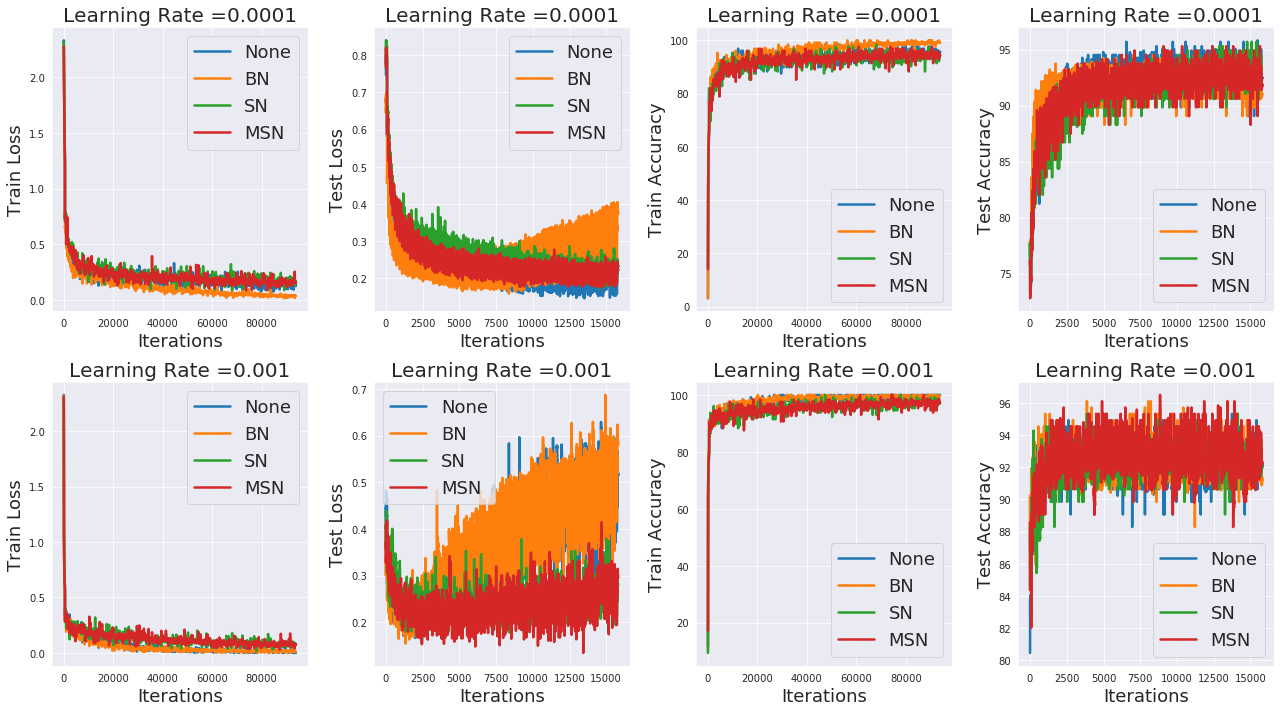

In [10]:
k = 0
LRS = [0.0001, 0.001]
plt.figure(figsize=(18, 10))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook([None,'BN', 'SN', 'MSN'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"MobileNet_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"MobileNet_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"MobileNet_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"MobileNet_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(2,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(2,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(2,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(2,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Act_Norm_Results.pdf', dpi=400)

0
0
0


/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarn

4
4
4



/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


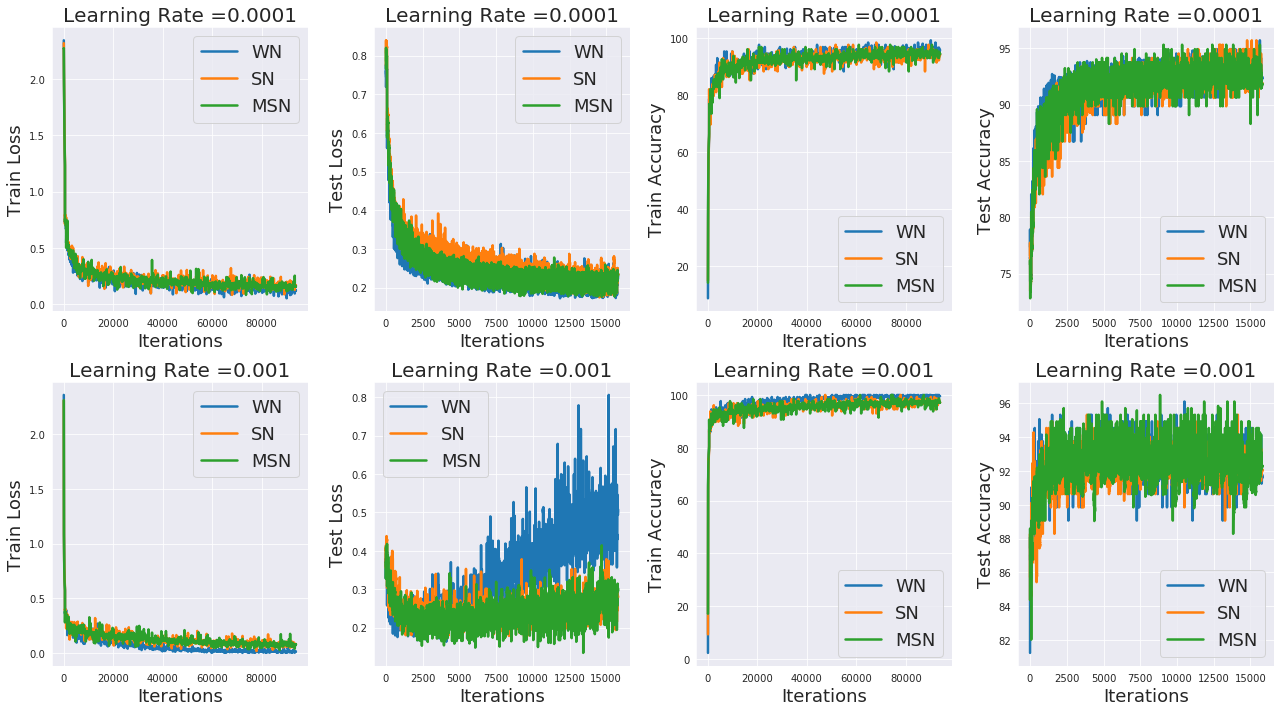

In [11]:
k = 0
plt.figure(figsize=(18, 10))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook(['WN', 'SN', 'MSN'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"MobileNet_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"MobileNet_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"MobileNet_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"MobileNet_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(2,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(2,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(2,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(2,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Weight_reparam_Results.pdf', dpi=400)

0
0


/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/robot/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarn

4
4



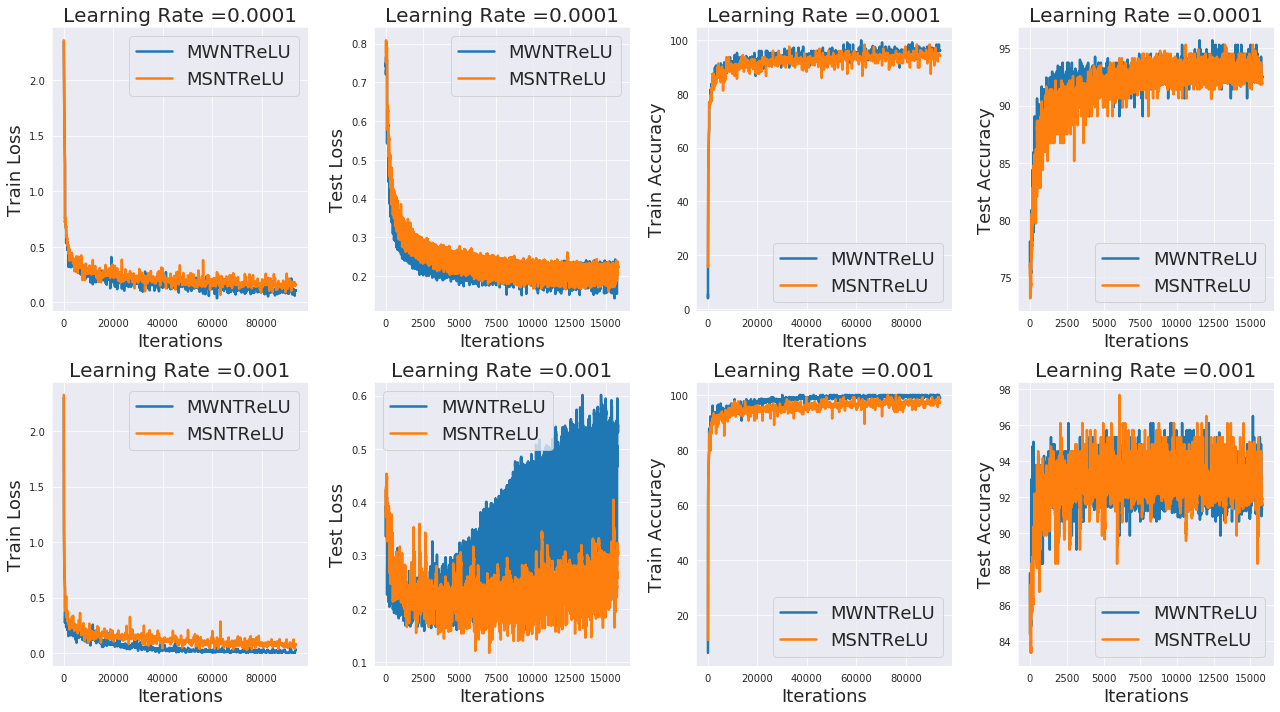

In [8]:
k = 0
plt.figure(figsize=(18, 10))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook(['MWNTReLU', 'MSNTReLU'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"MobileNet_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"MobileNet_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"MobileNet_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"MobileNet_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(2,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(2,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(2,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(2,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Weight_reparam_act_Results.pdf', dpi=400)